In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import geopandas as gpd


sns.set_theme(font='Victor Mono',style='whitegrid',palette='Pastel2')


In [2]:
df_hoteles = gpd.read_file(r'data\geodata_historicos\df_hoteles.shp')
df_cuartos = gpd.read_file(r'data\geodata_historicos\df_cuartos.shp')
df_servicios = gpd.read_file(r'data\geodata_historicos\df_servicios.shp')



In [3]:
# Cast columns
object_columns = ['municipio','region','geometry']
new_dfs = []

for df in (df_servicios,df_cuartos,df_hoteles):

    df = df.replace('N/D','0')
    df = df.replace('ND','0')

    for col in df.columns:
        if col in object_columns:
            continue
        df[col] = df[col].astype('int64')
    new_dfs.append(df)
    
(df_servicios,df_cuartos,df_hoteles) = new_dfs


# Series de tiempo


A continuacion se muestran series de tiempo del cambio de oferta de establecimientos y cuartos separados por region

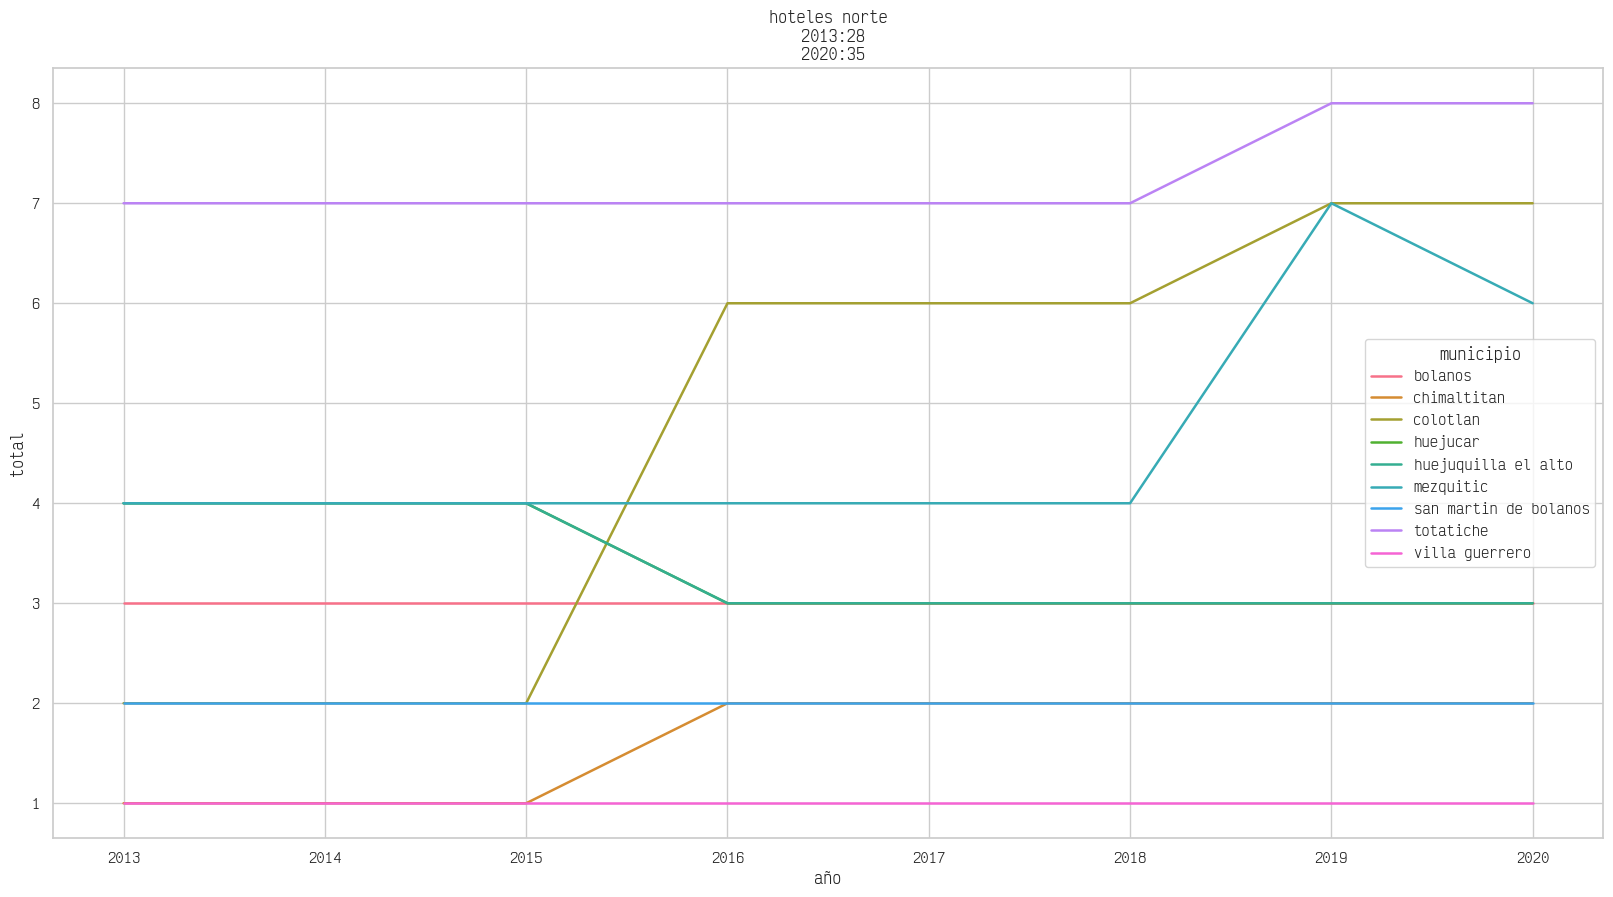

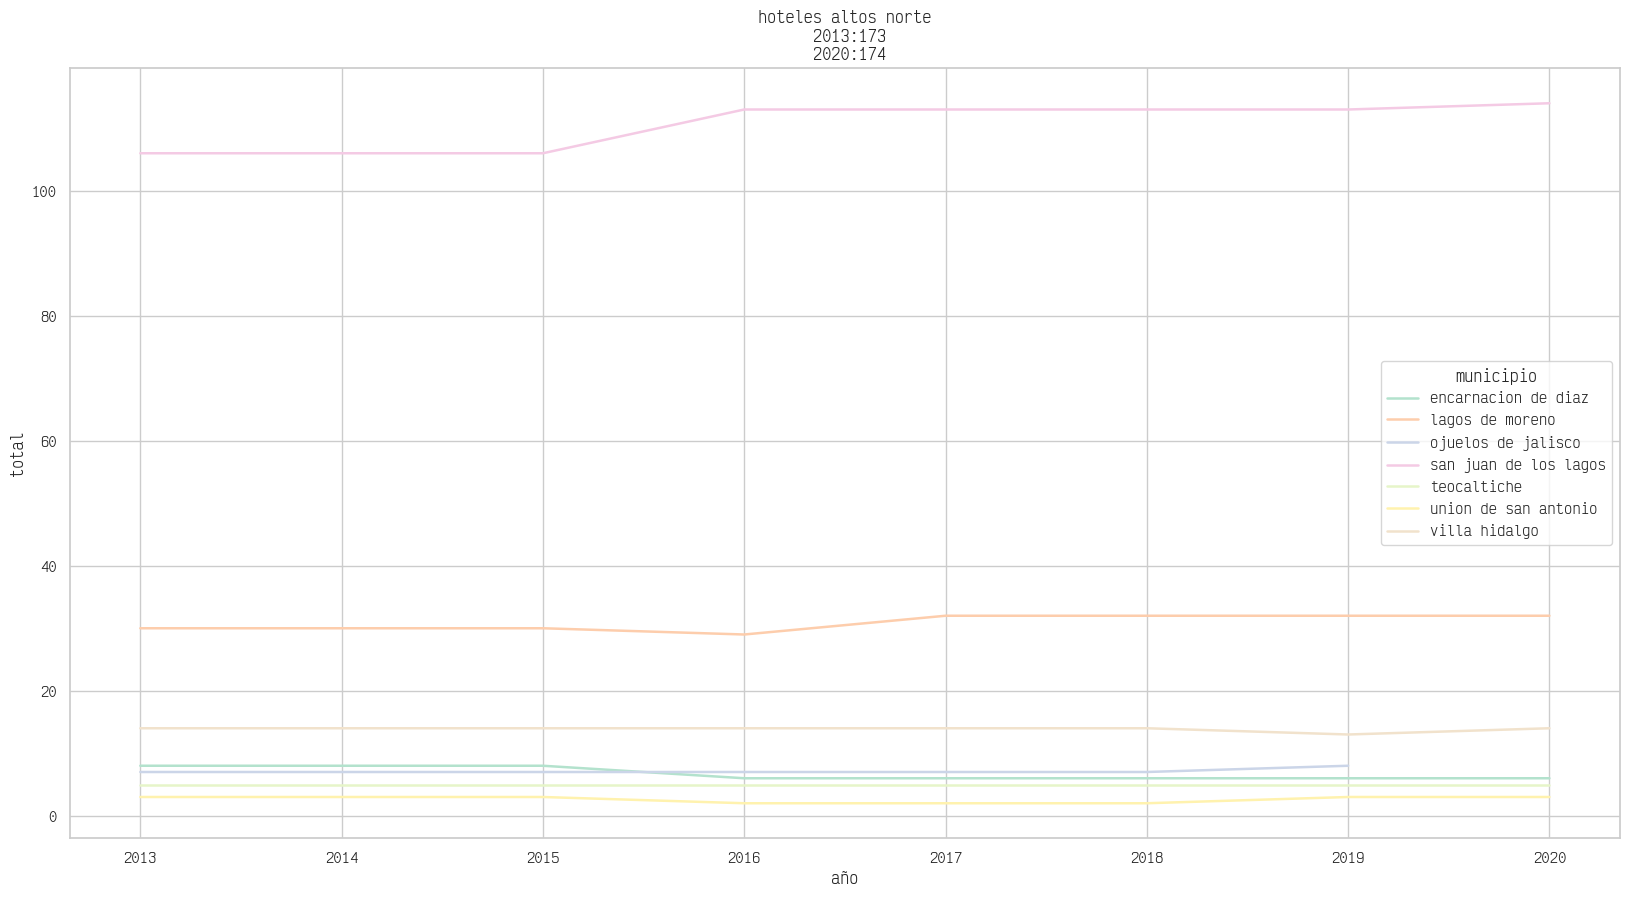

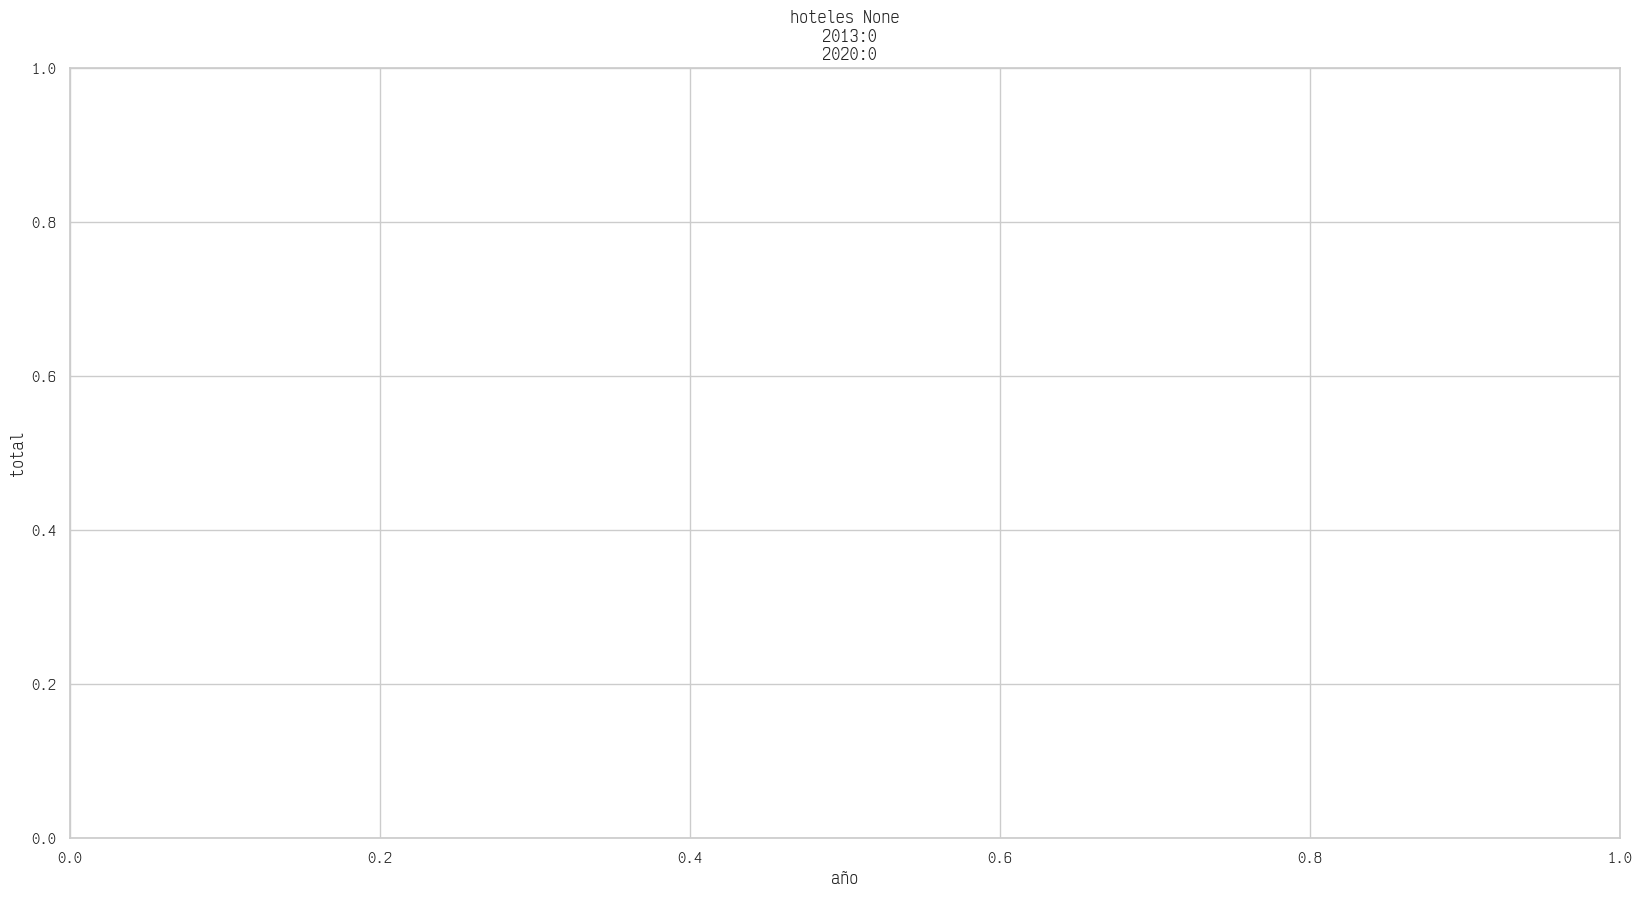

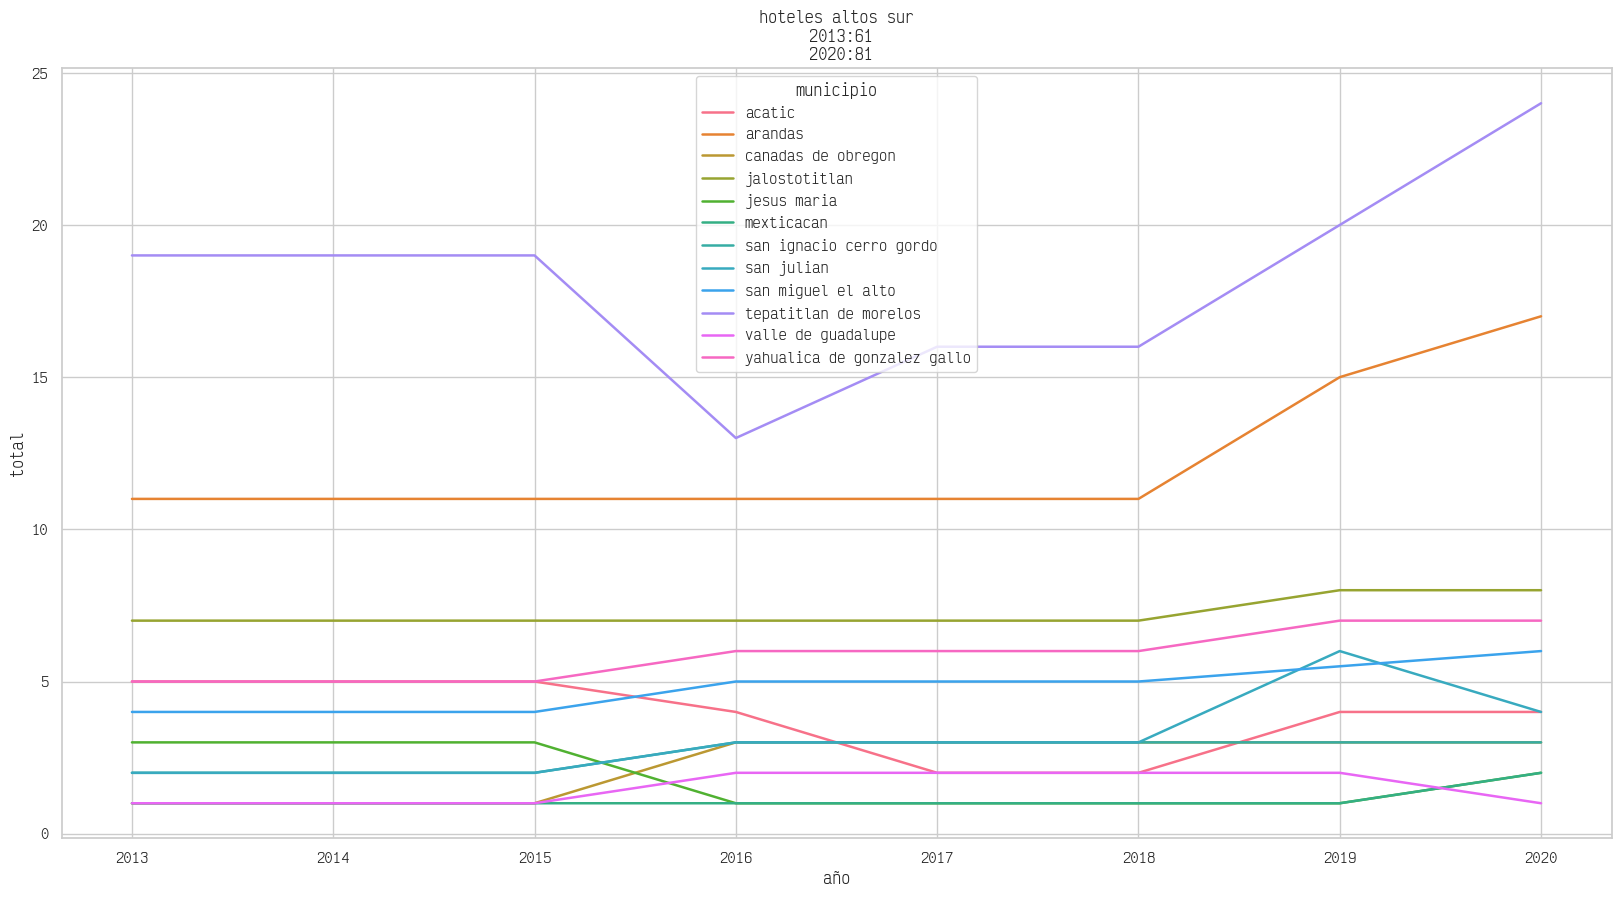

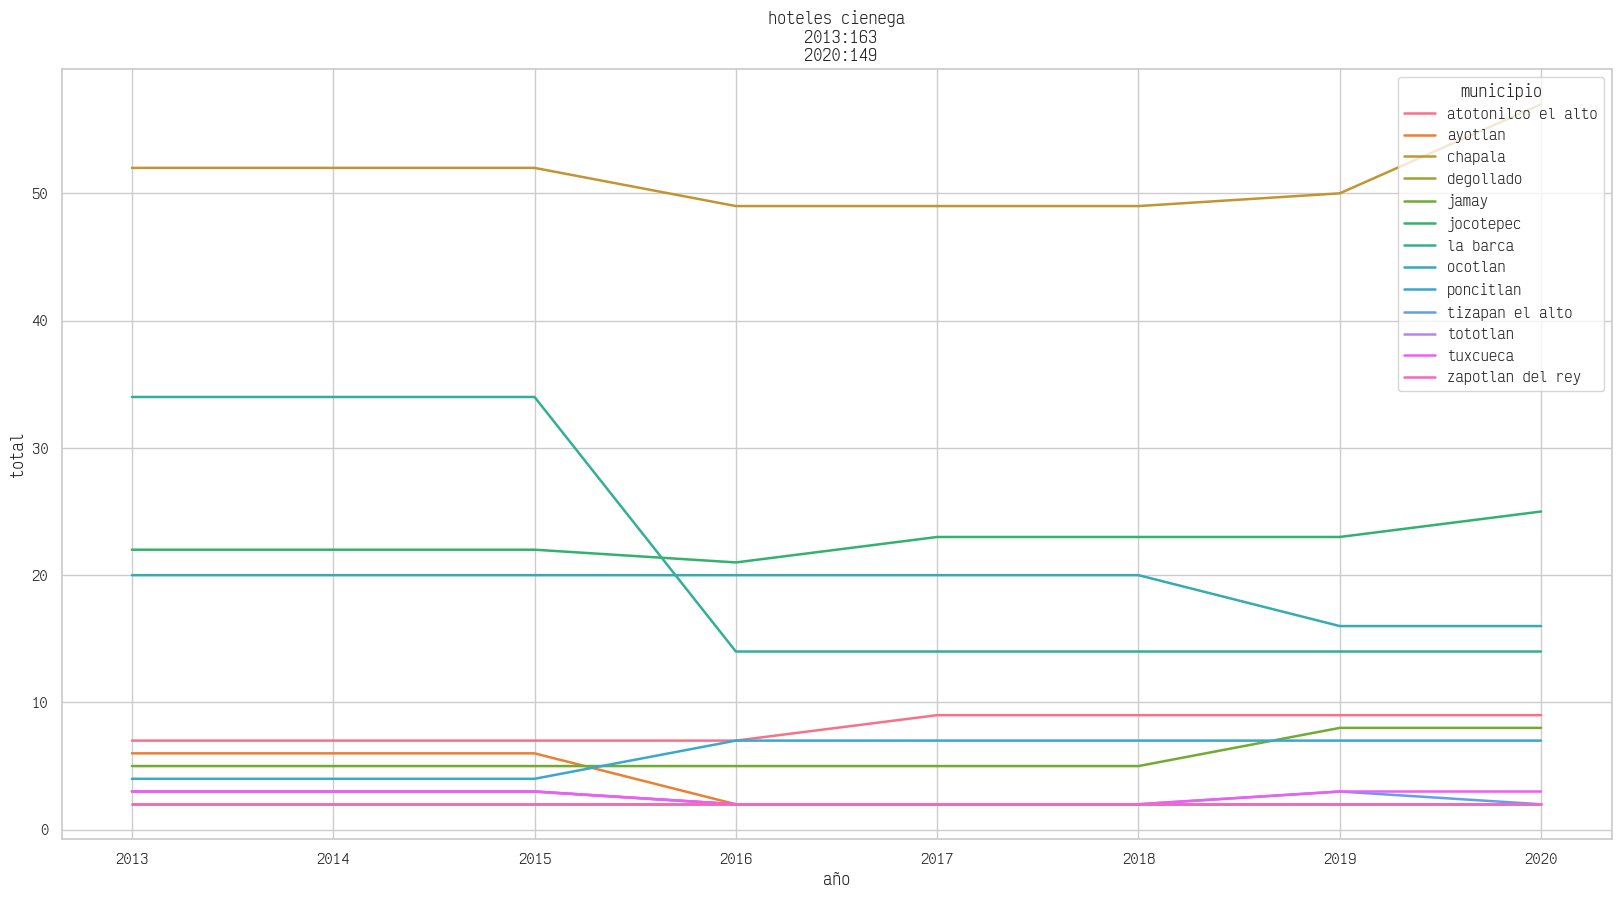

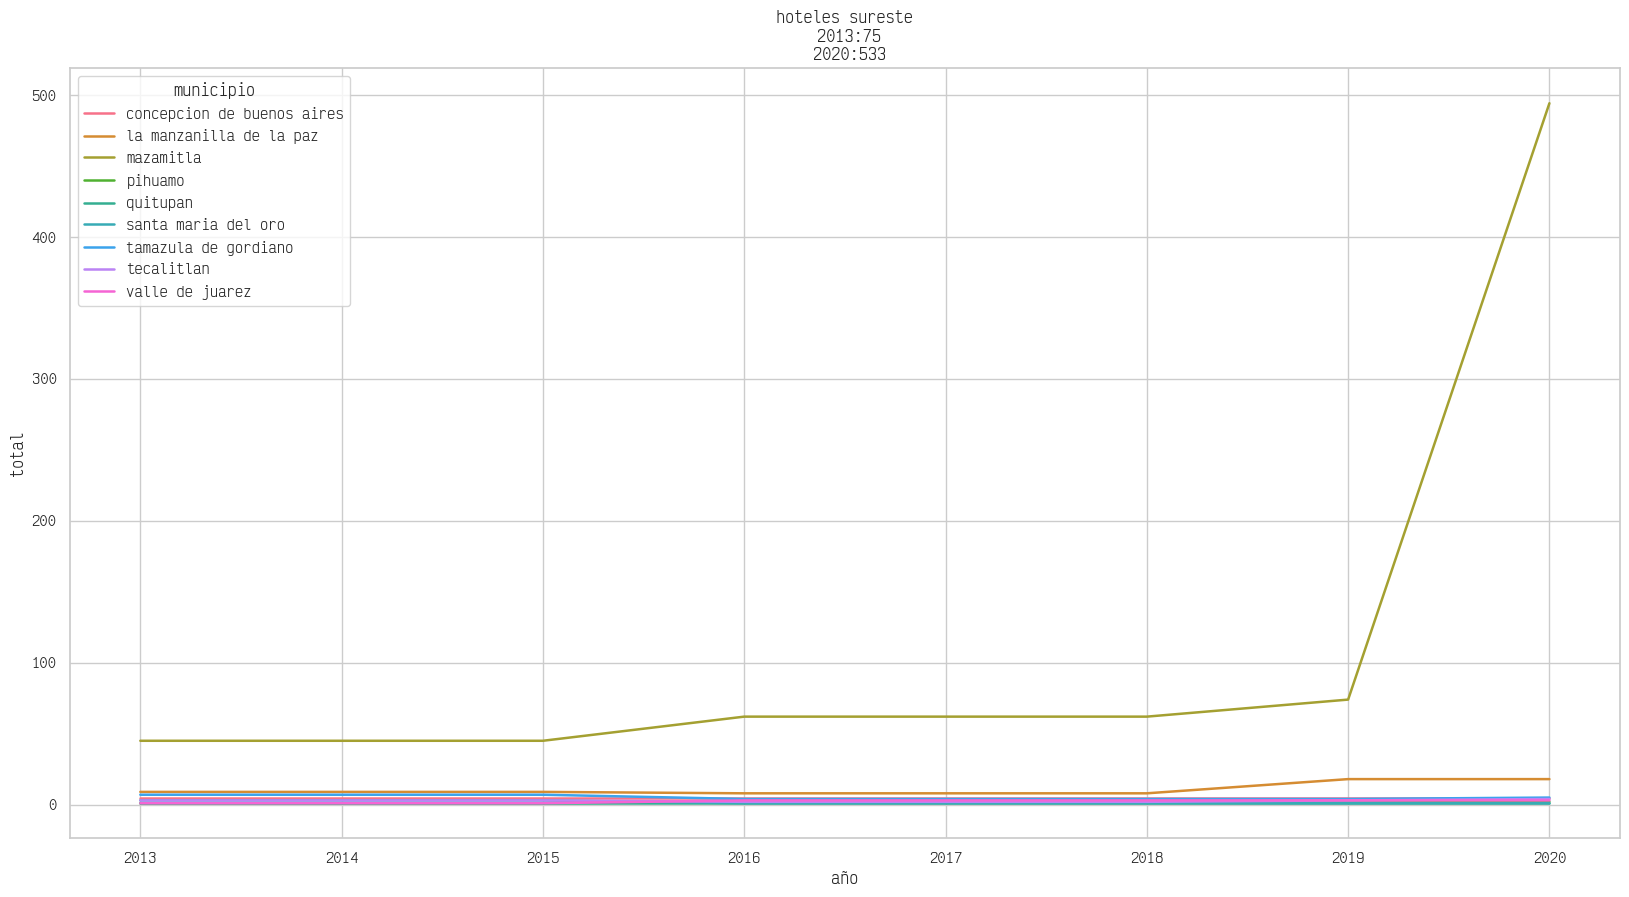

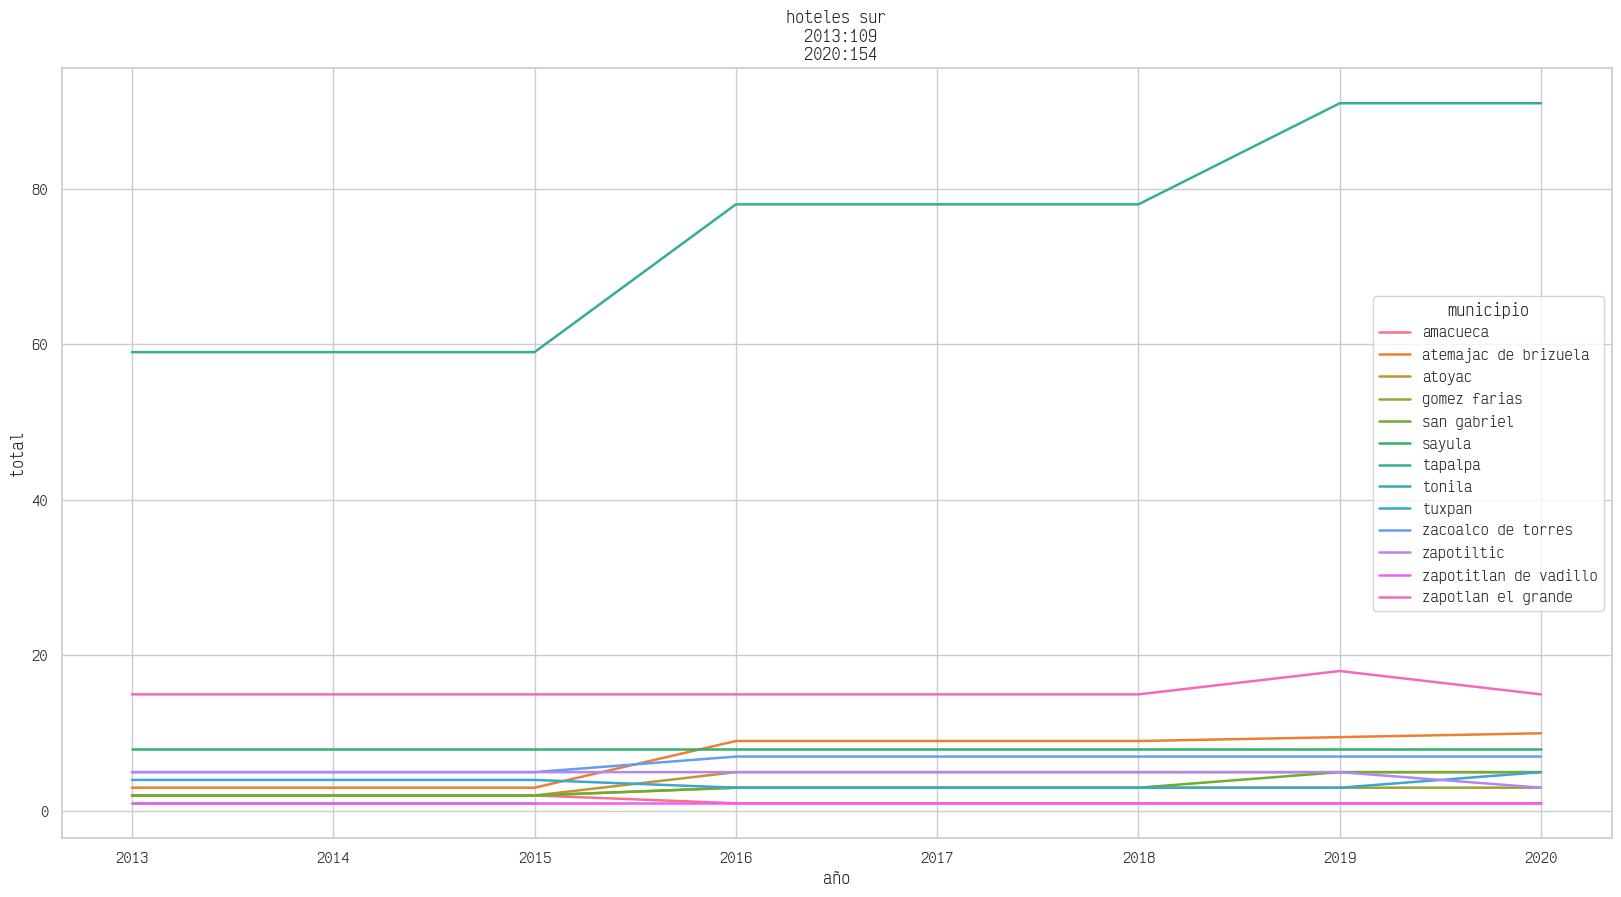

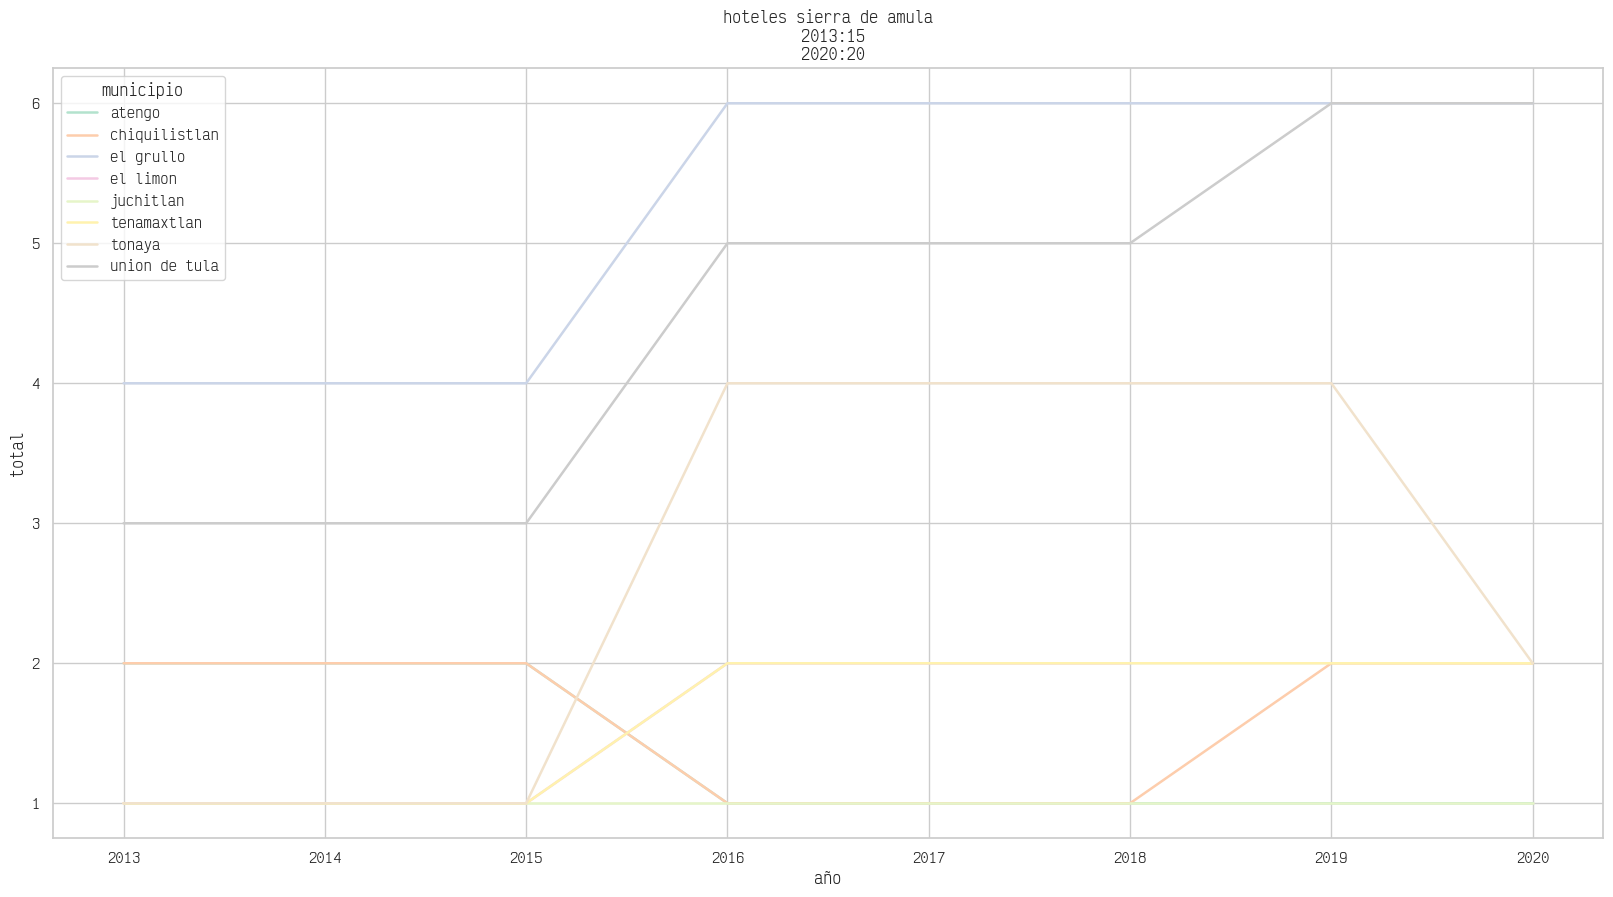

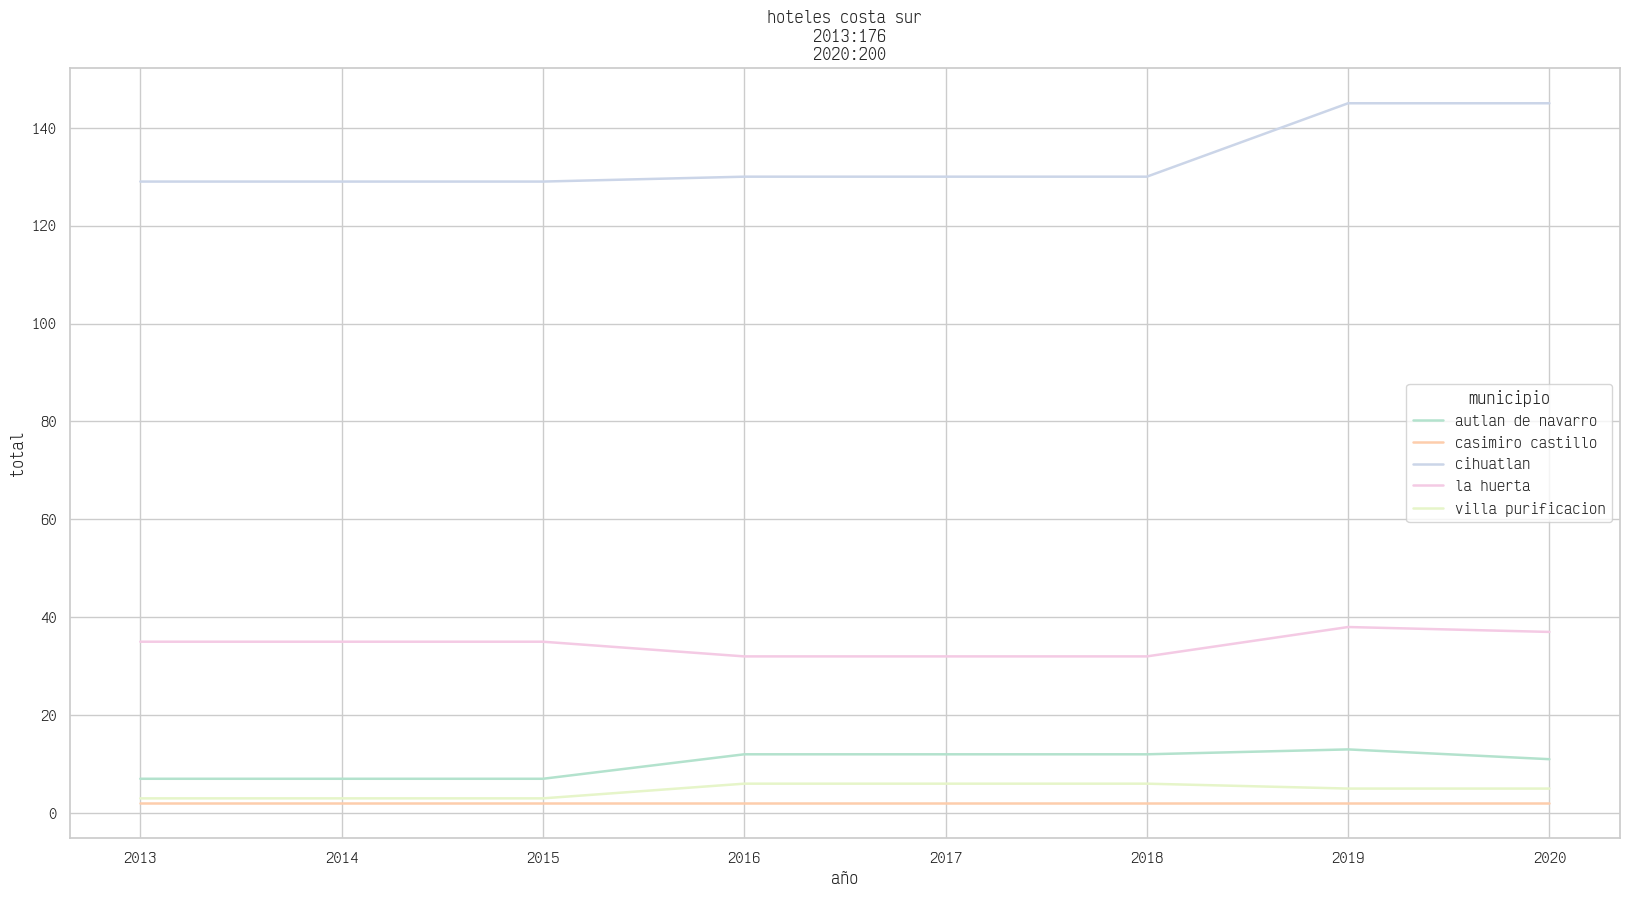

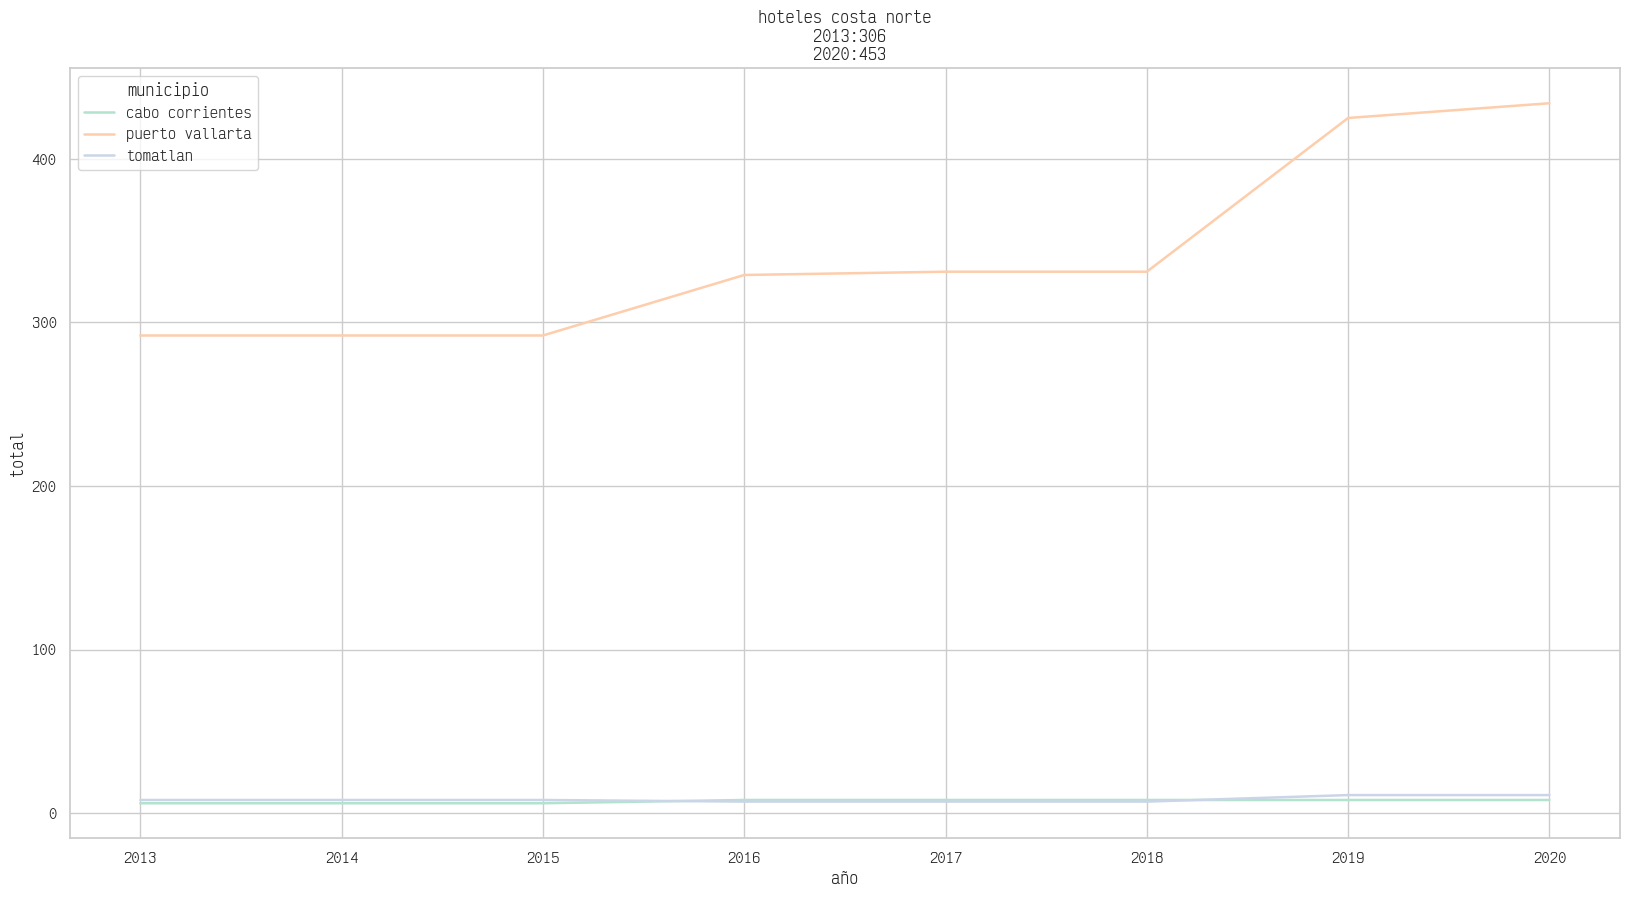

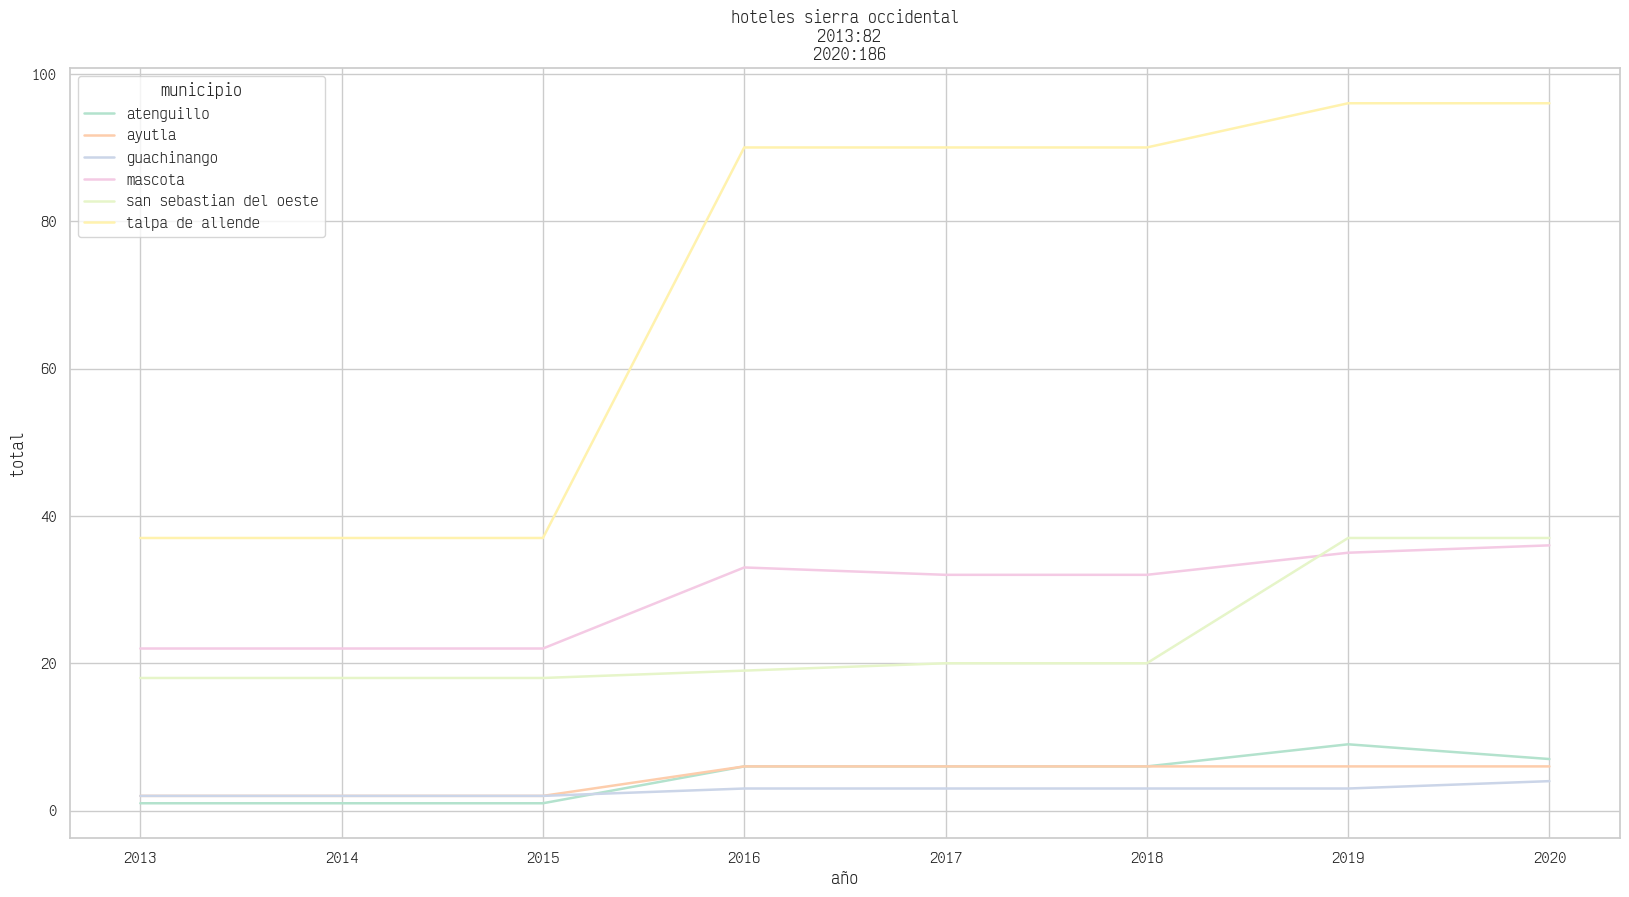

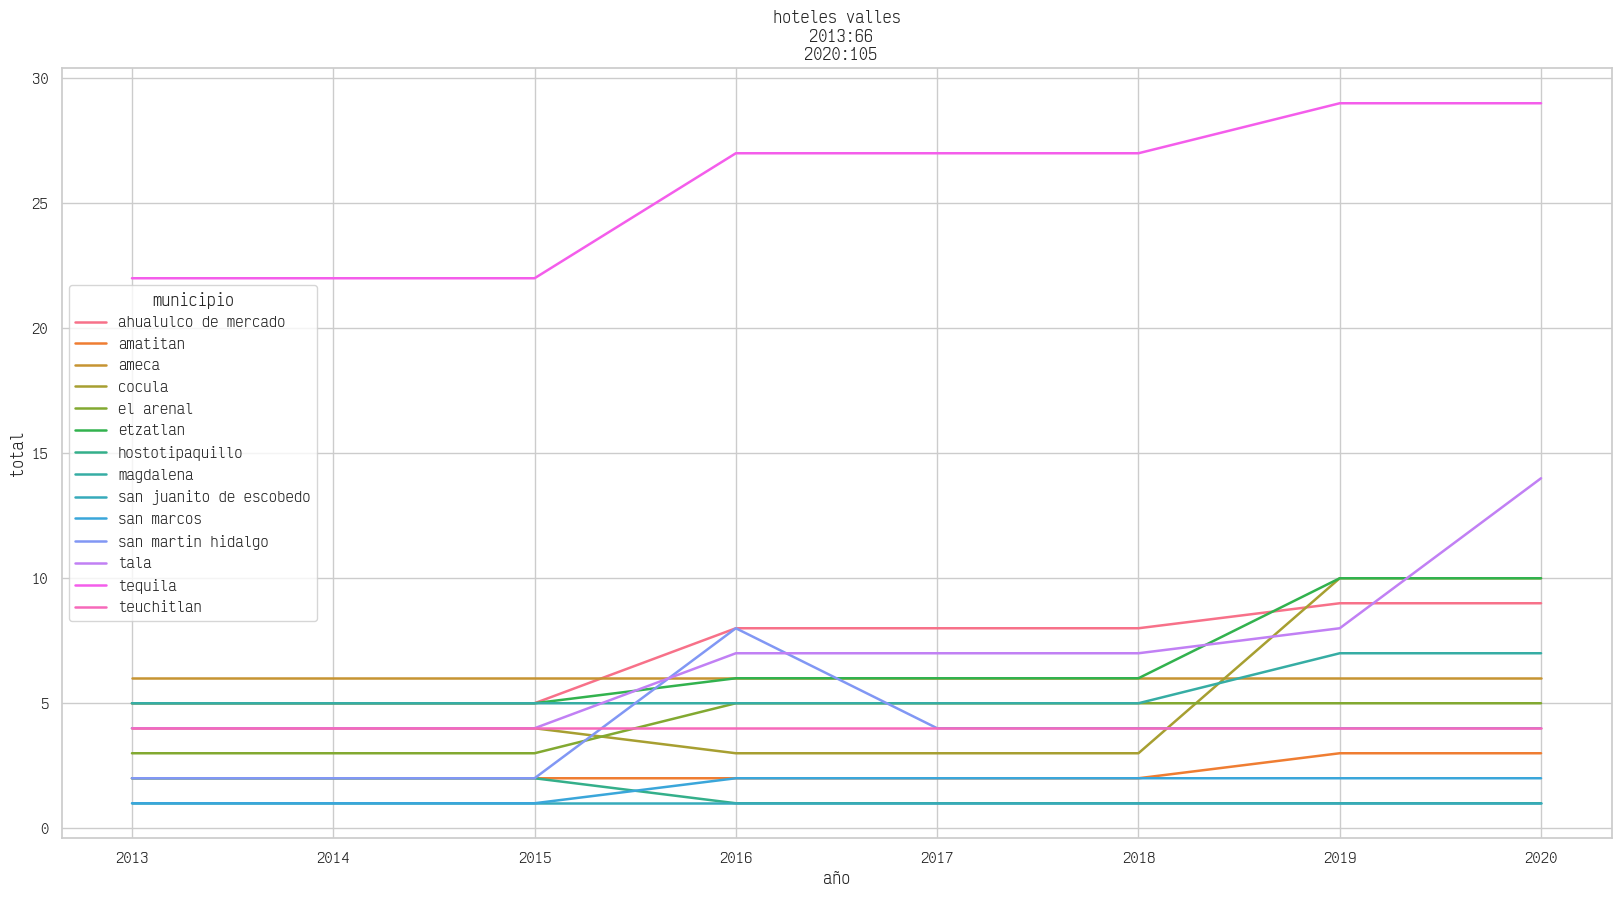

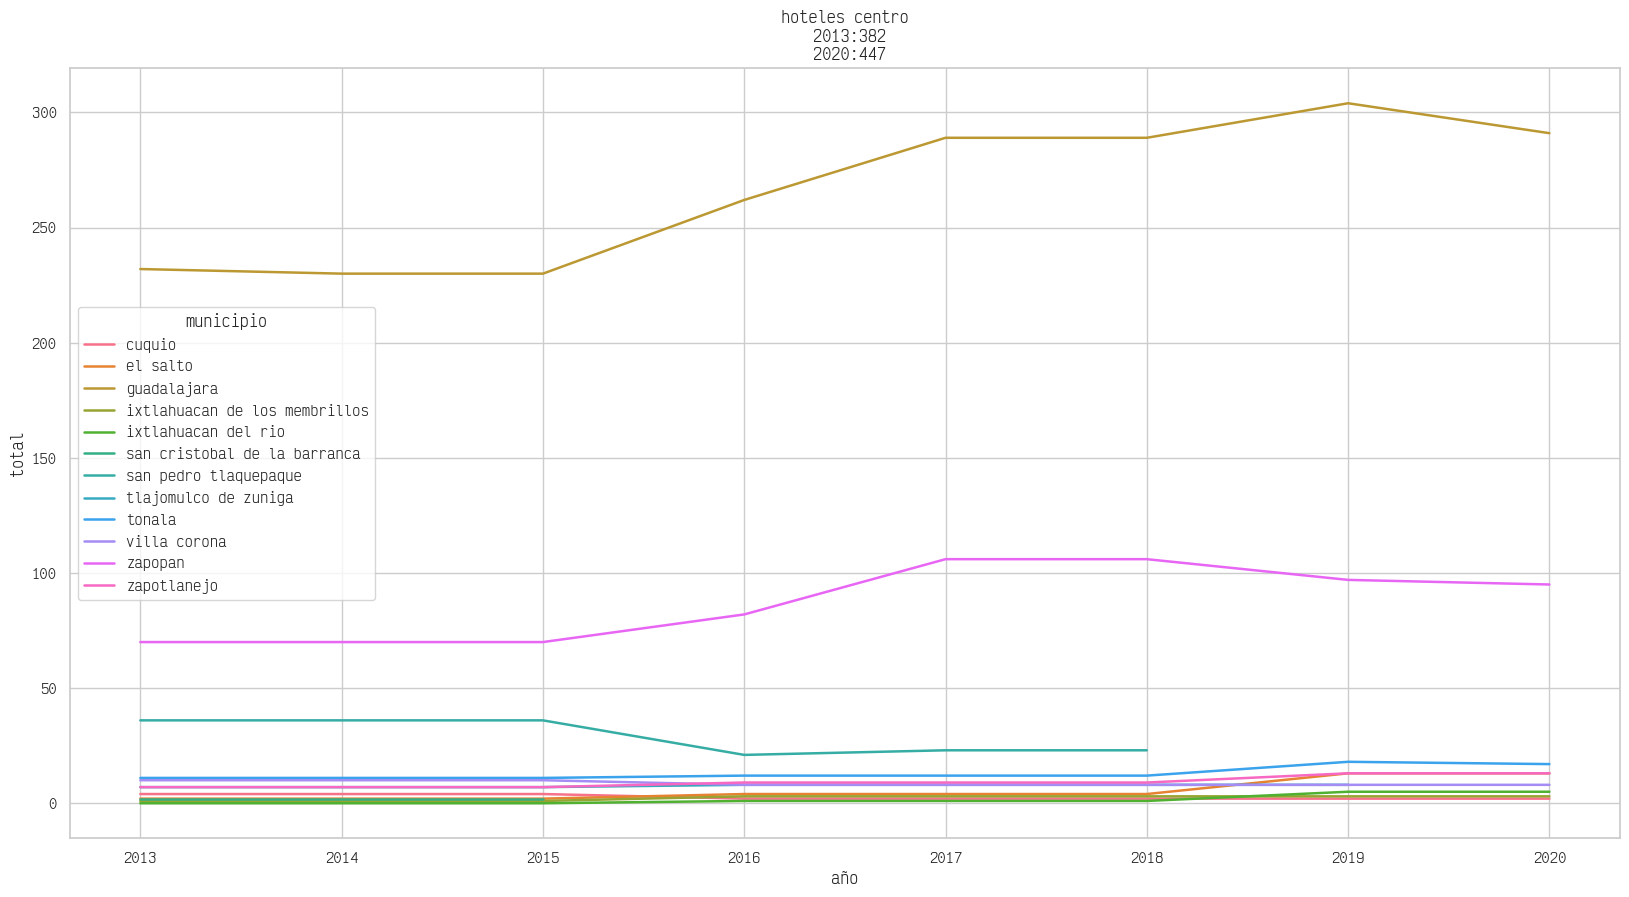

In [4]:

for region in df_hoteles['region'].unique():
    
    df = df_hoteles[df_hoteles['region'] == region]
    total_2013 = df[df['año'] == 2013]['total'].sum()
    total_2020 = df[df['año'] == 2020]['total'].sum()

    fig,ax = plt.subplots(1,1,figsize=(20,10))
    sns.lineplot(df,x='año',y='total',hue='municipio',ax=ax,linewidth=1.8)
    ax.set_title(f'hoteles {region}\n 2013:{total_2013}\n 2020:{total_2020}')

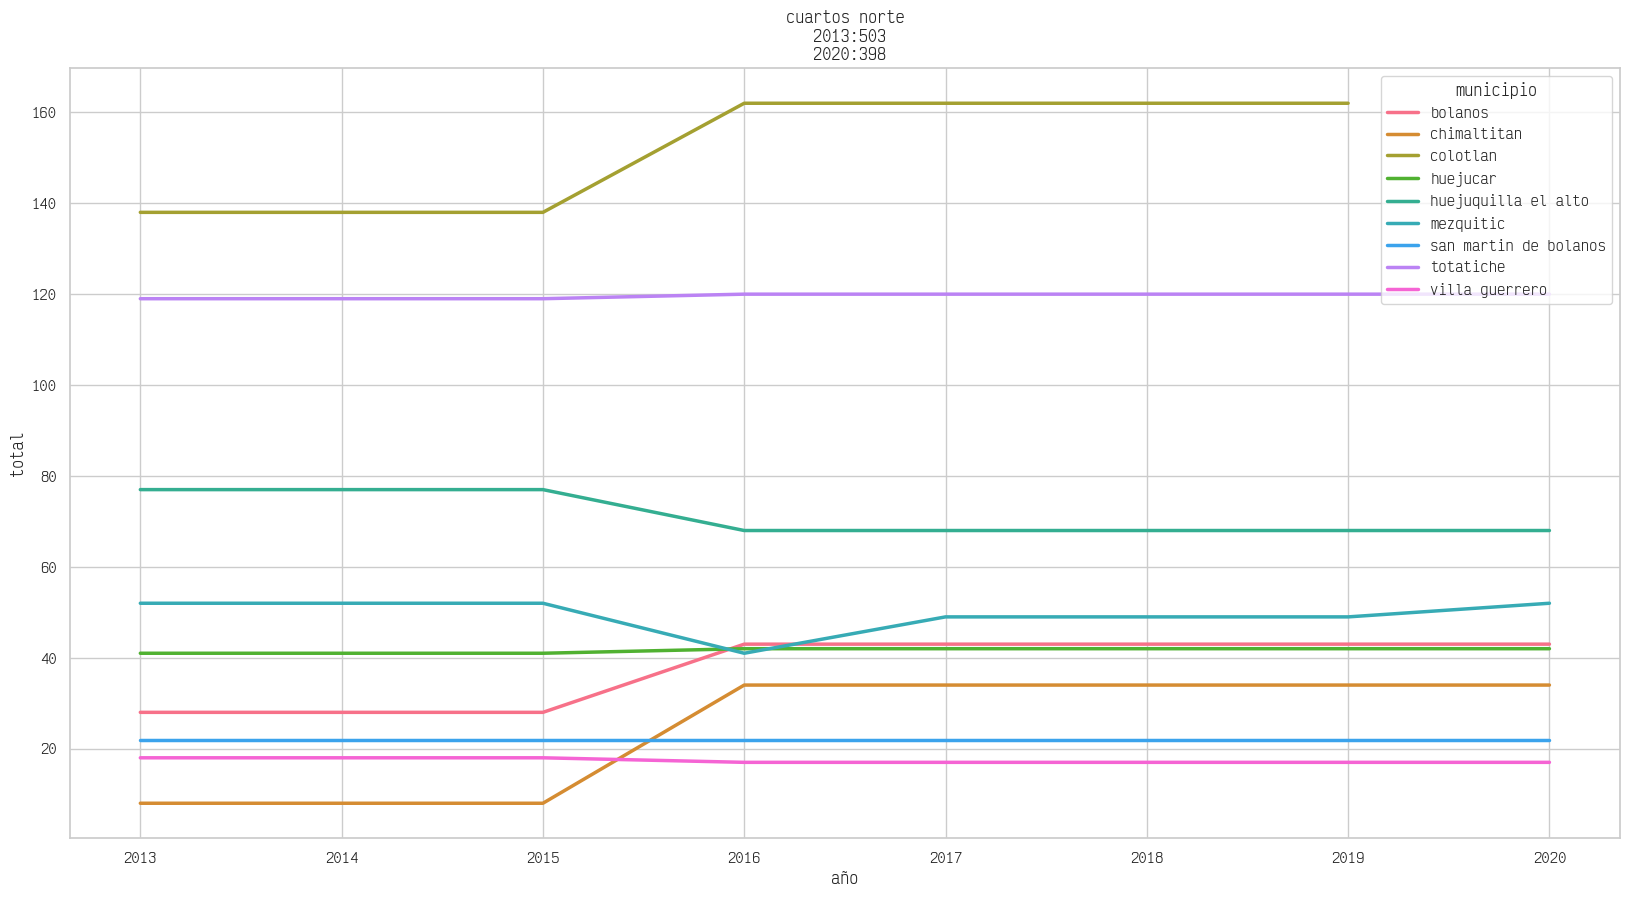

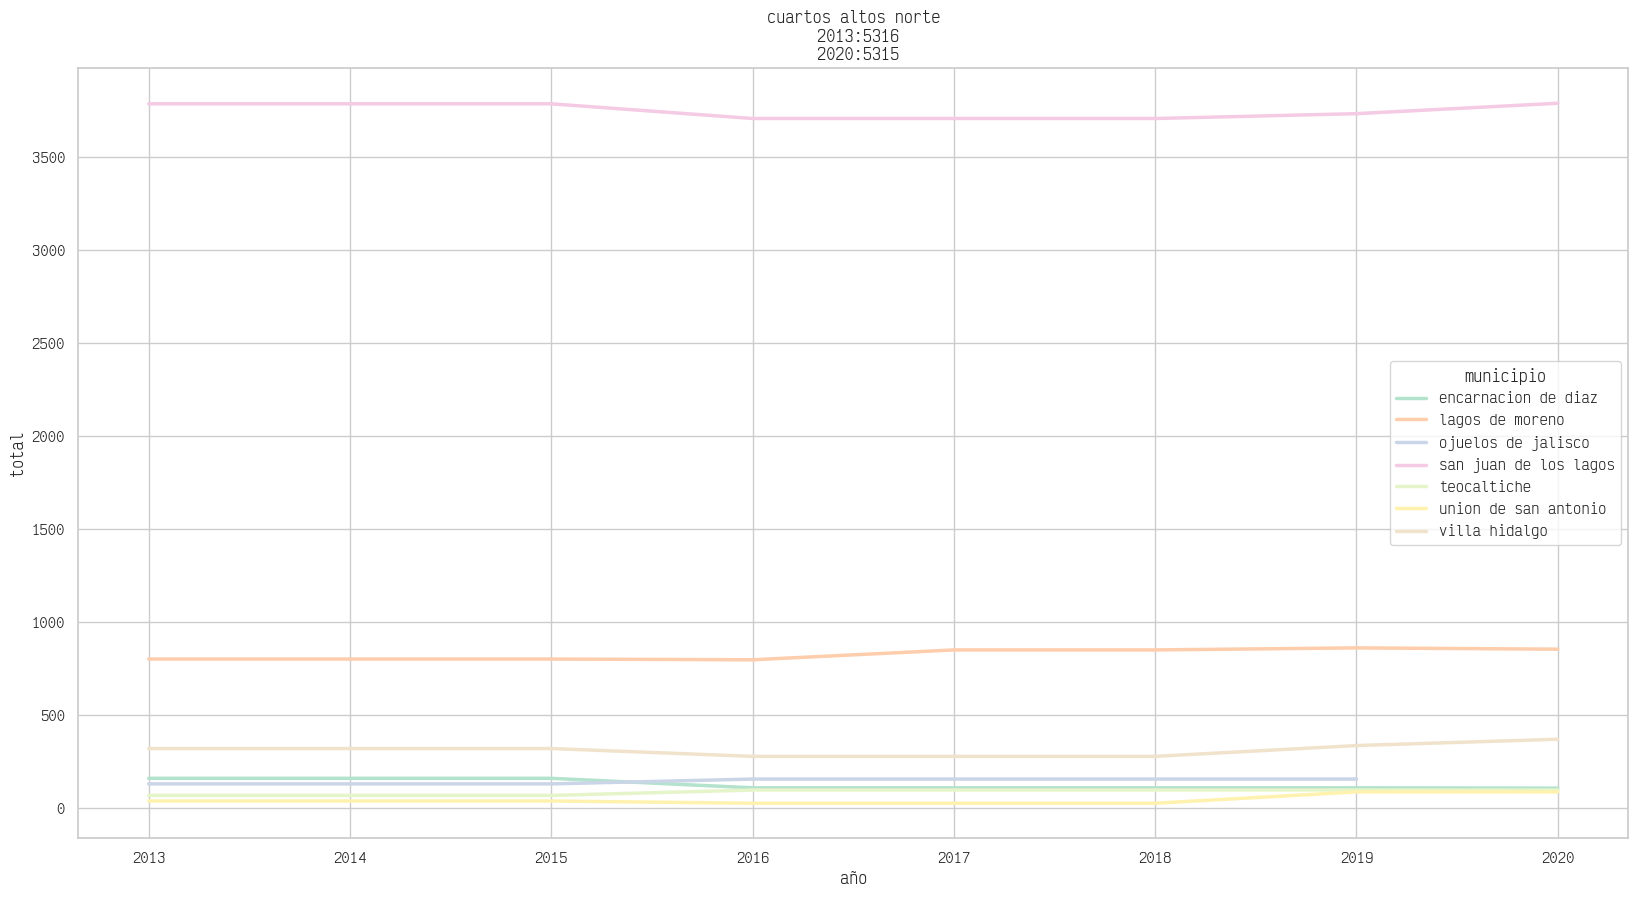

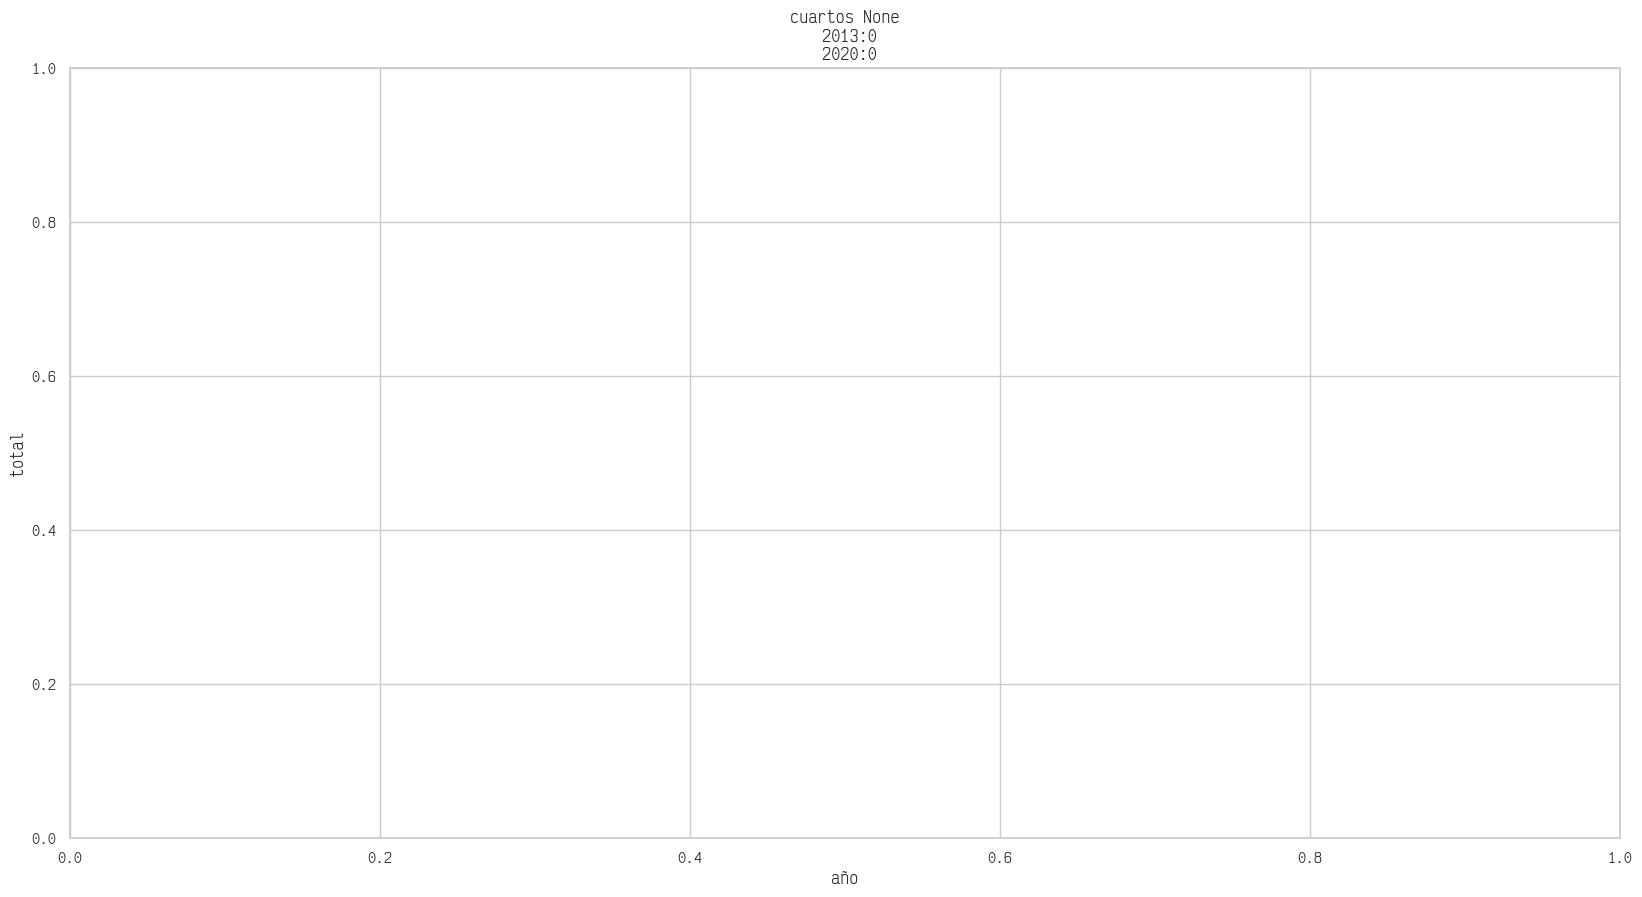

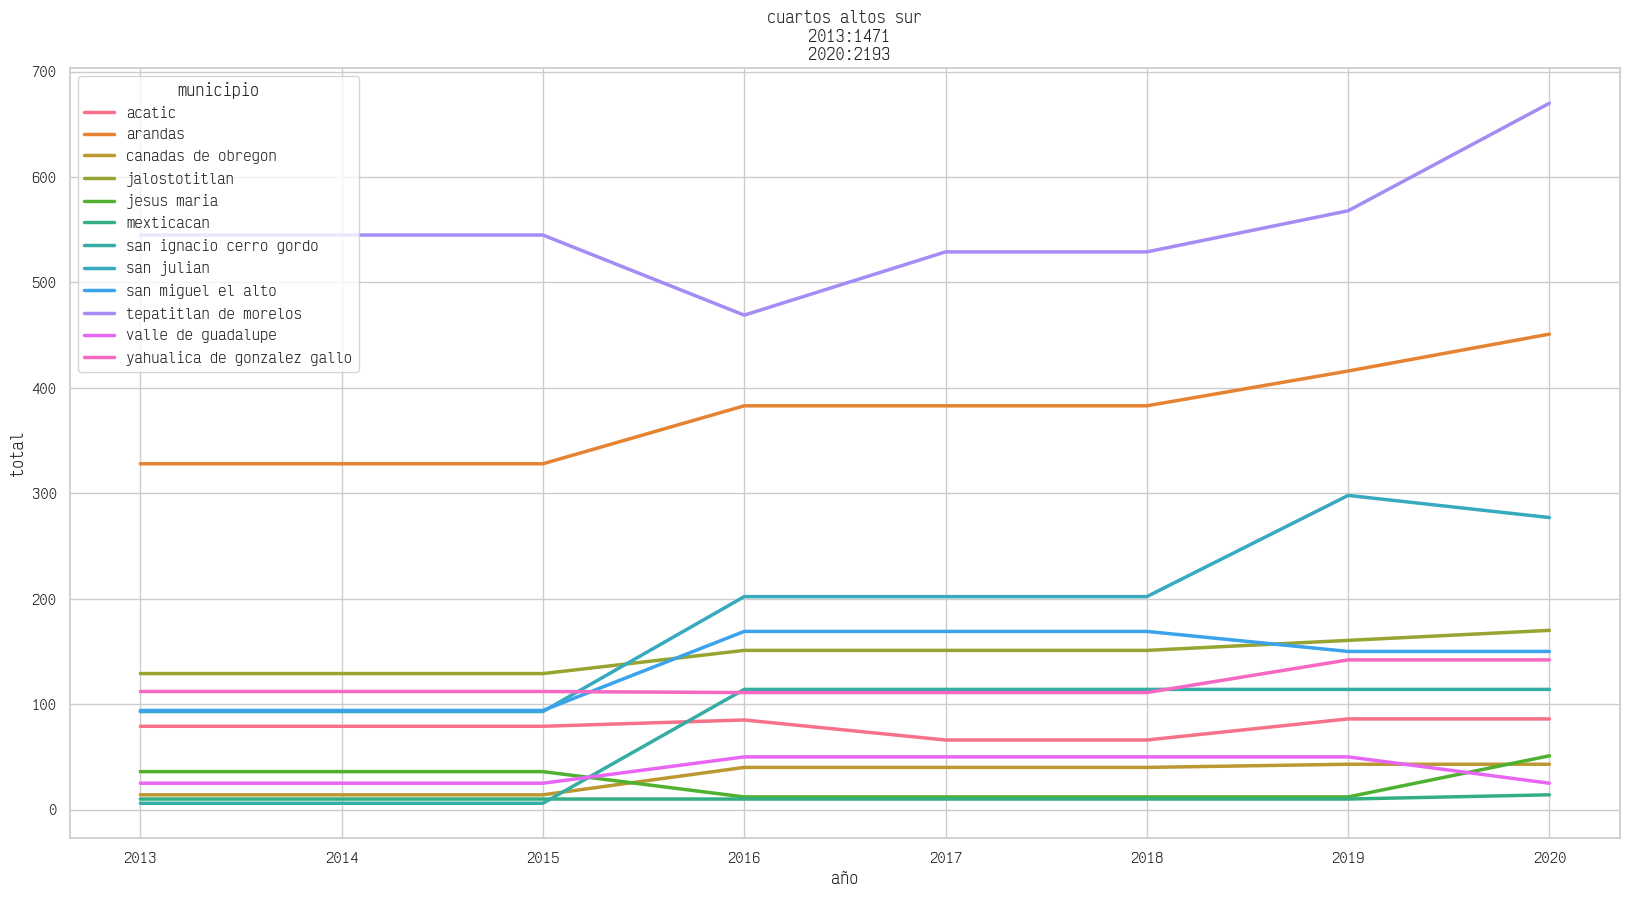

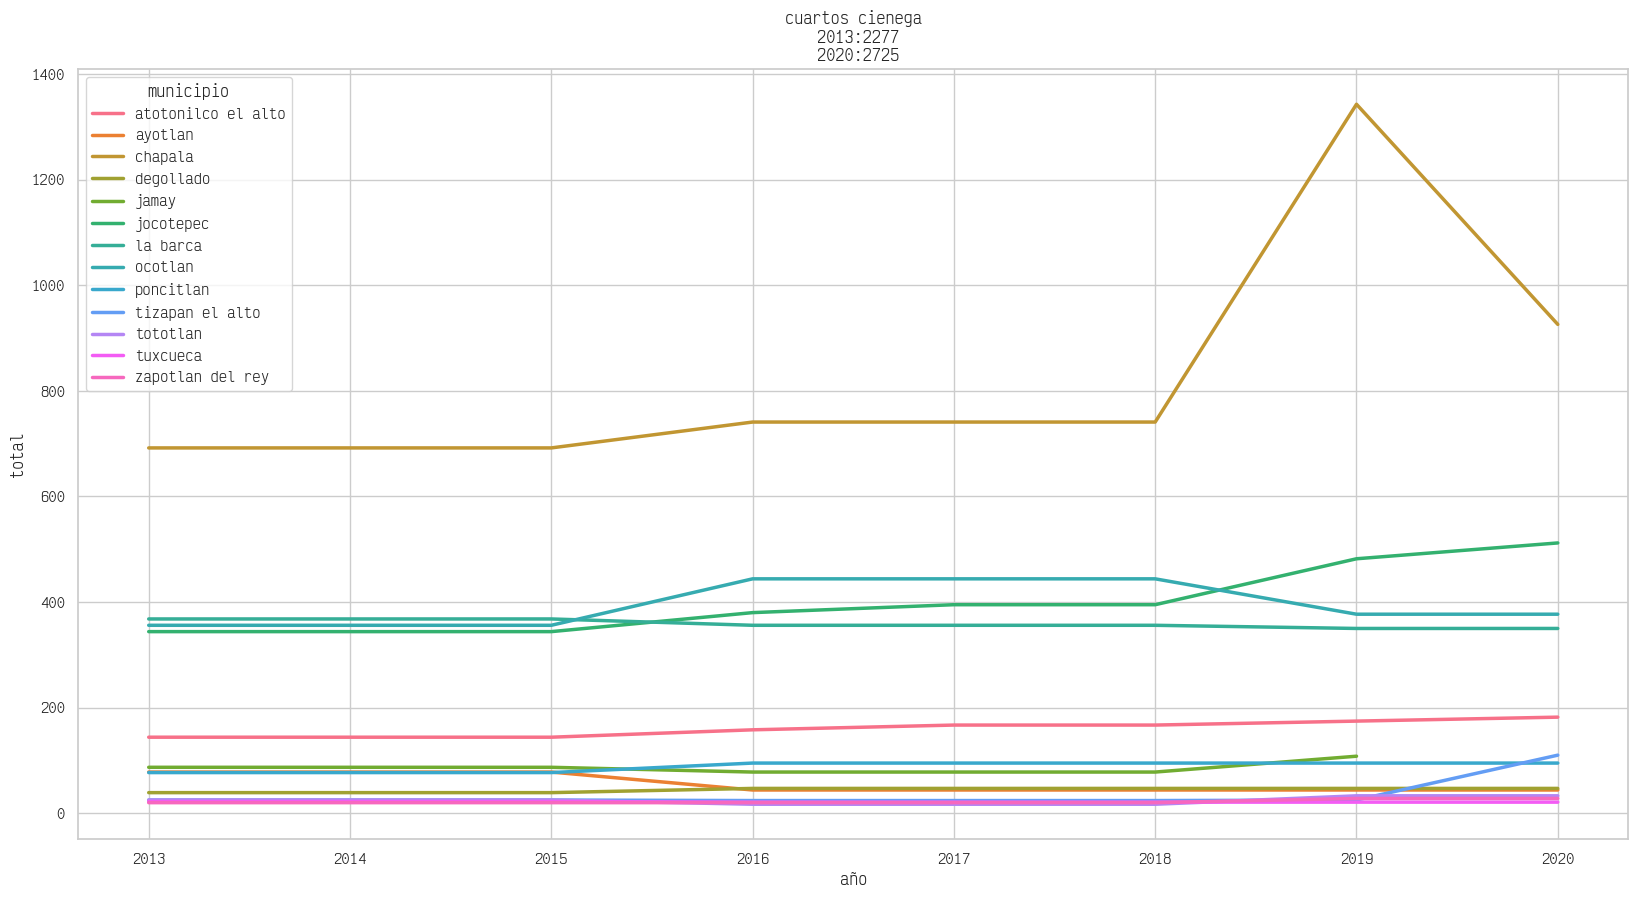

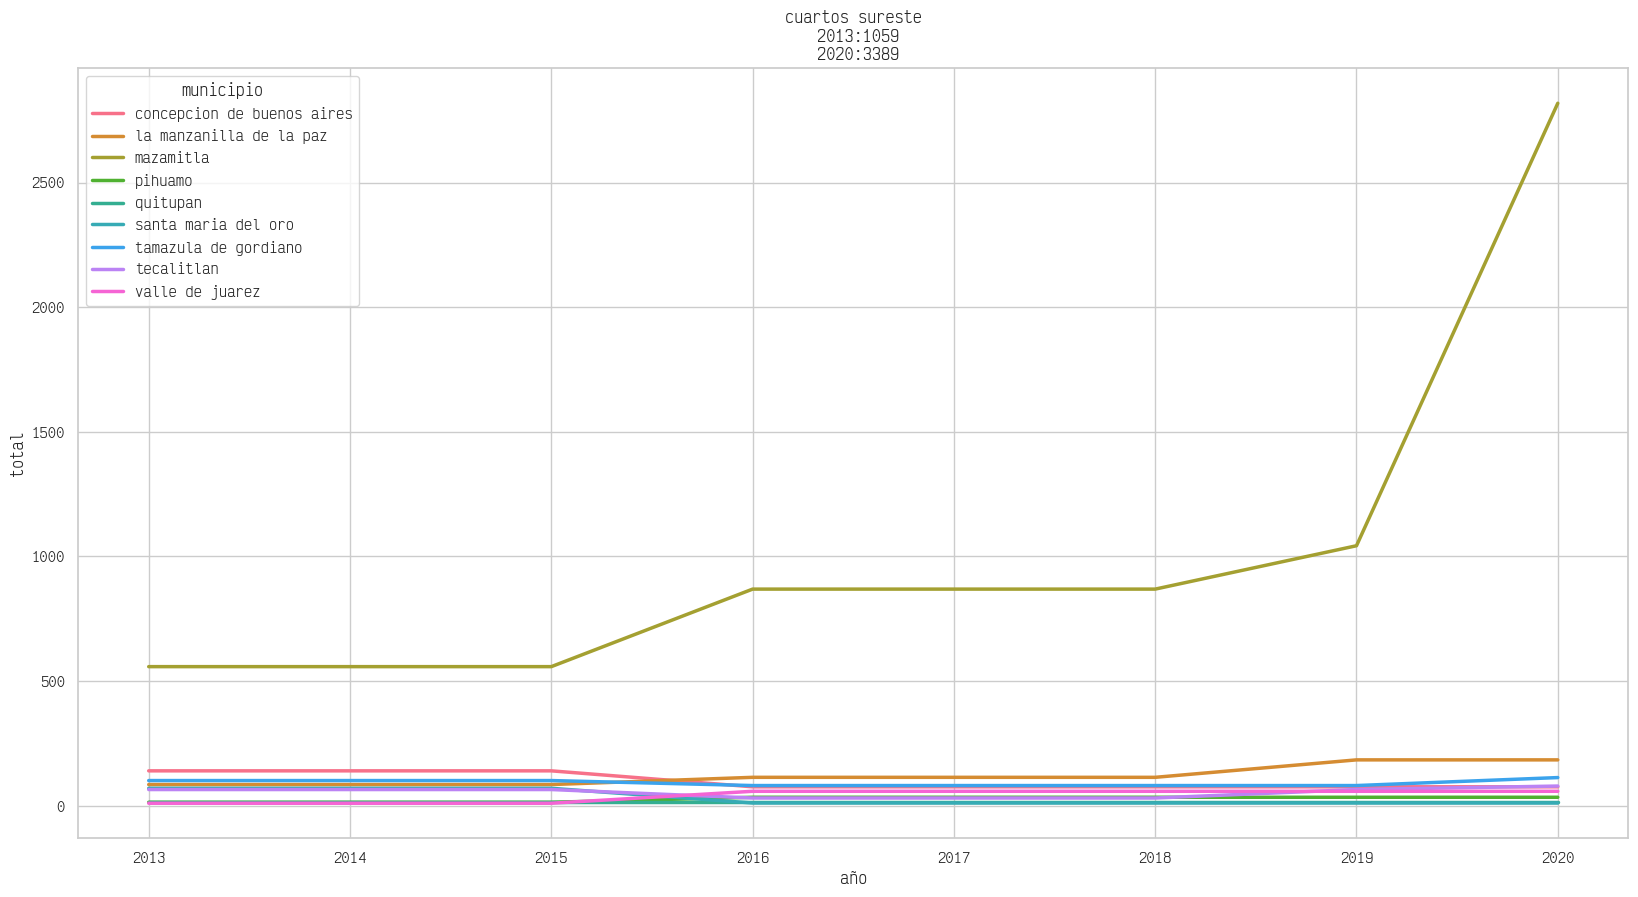

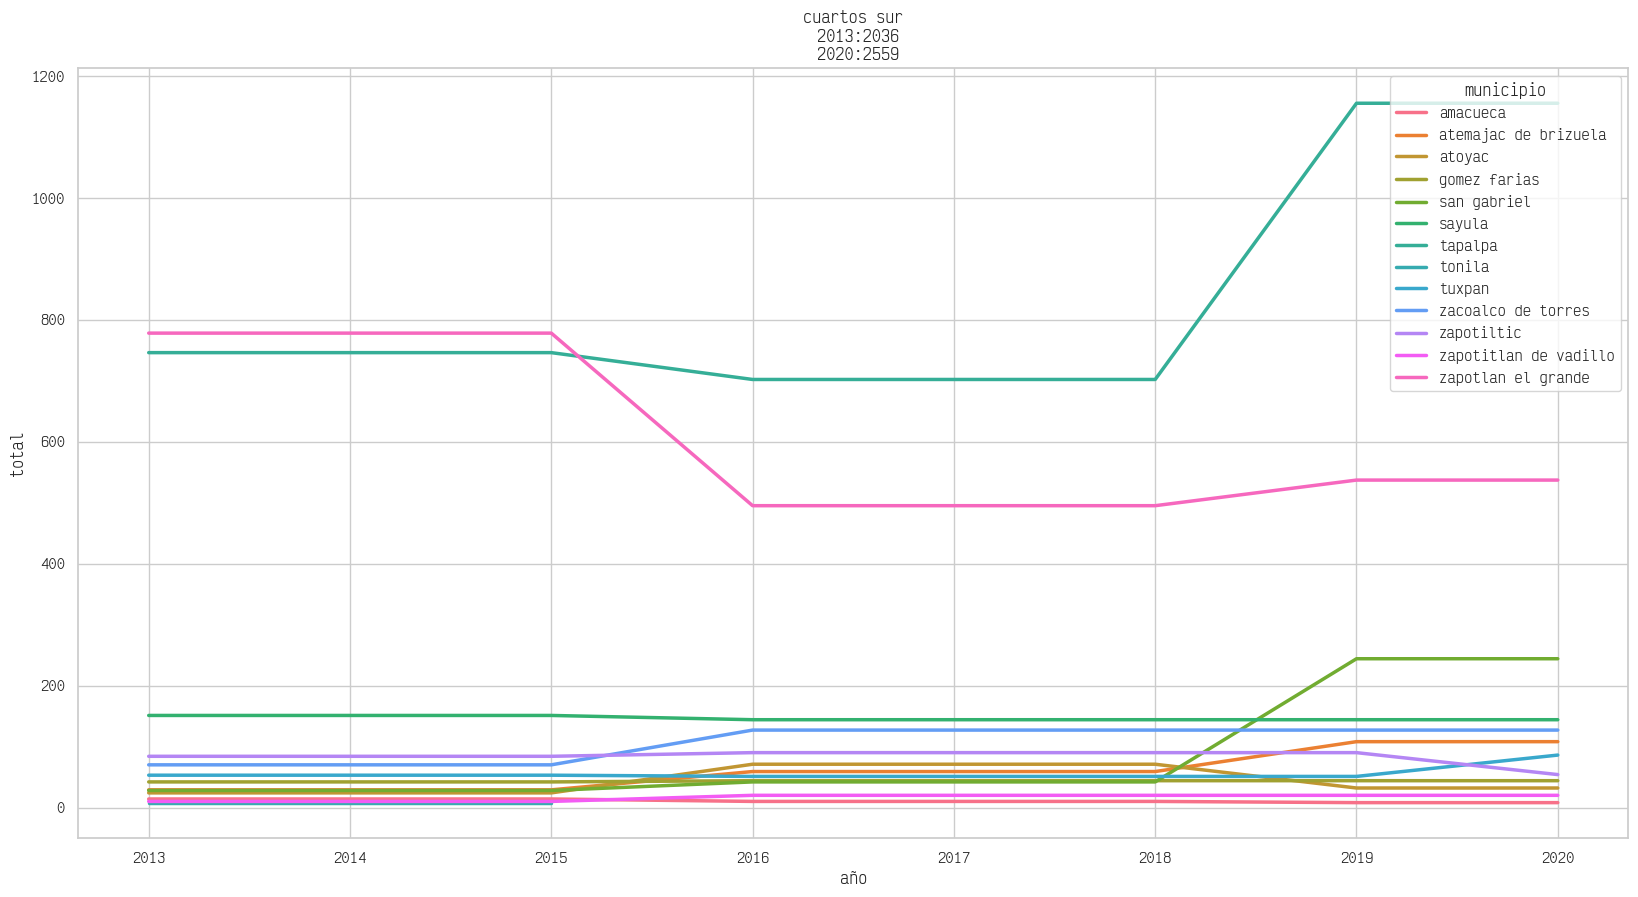

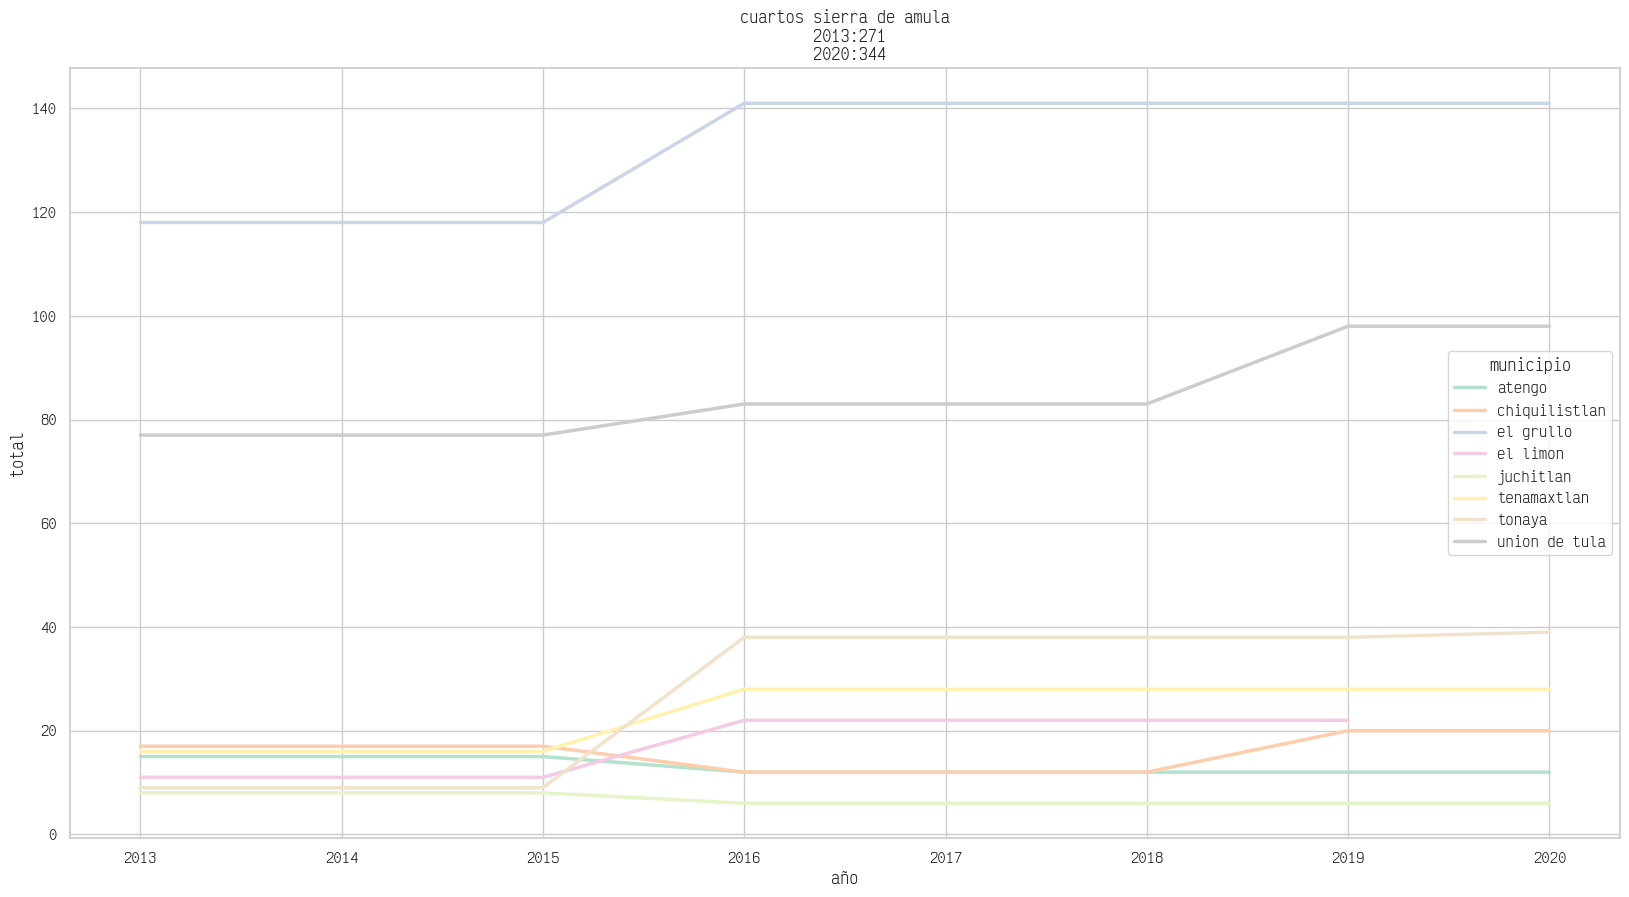

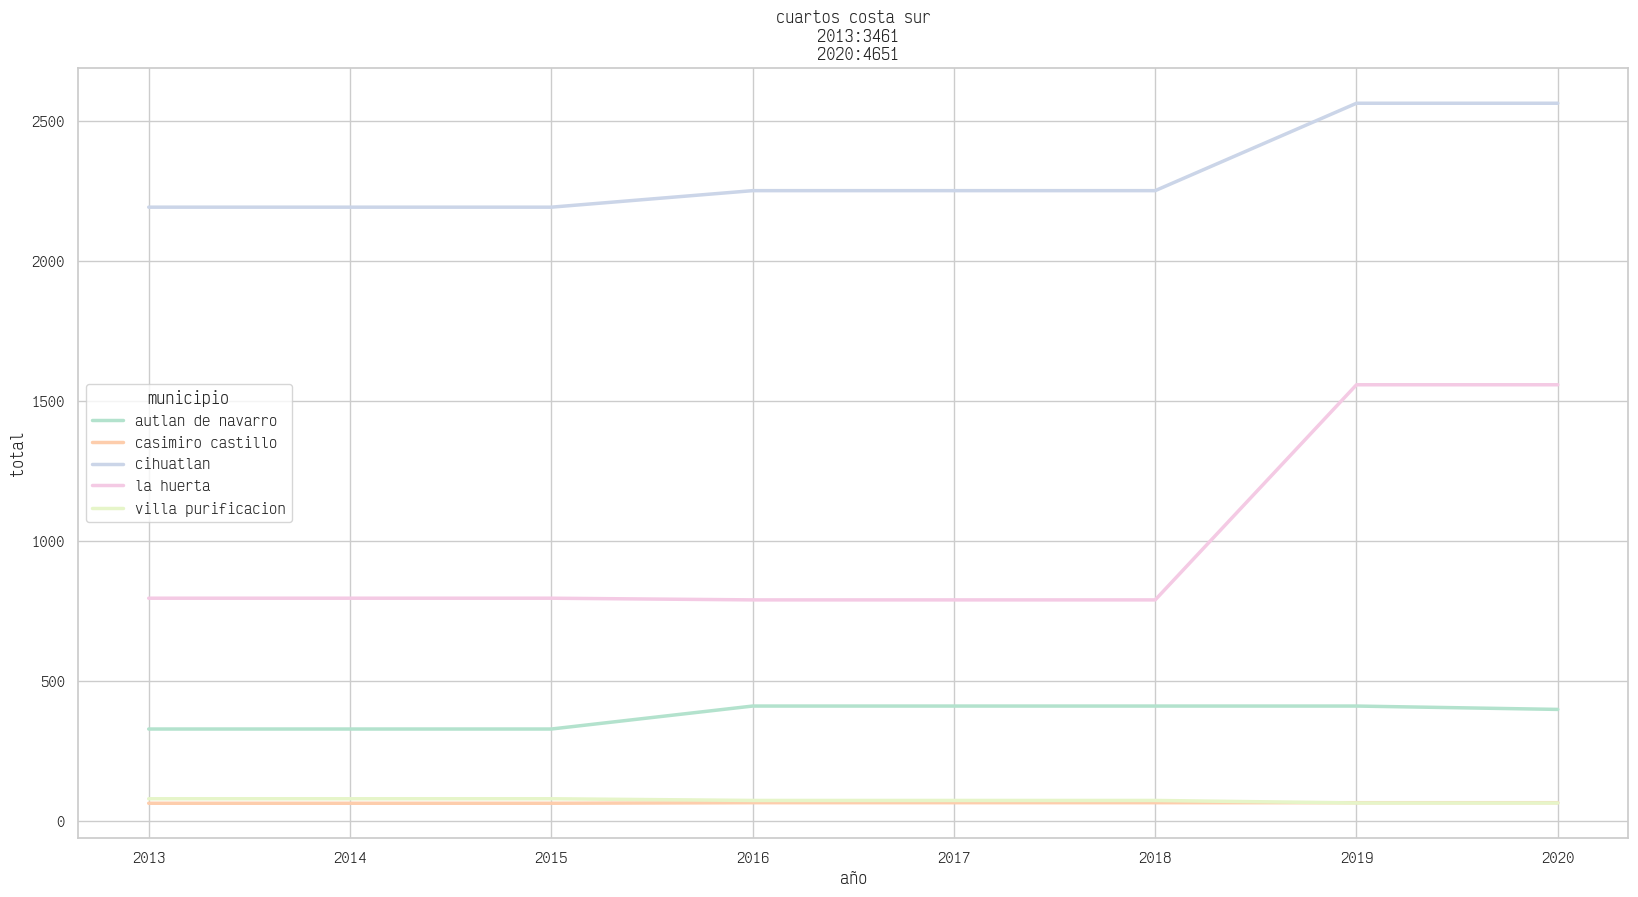

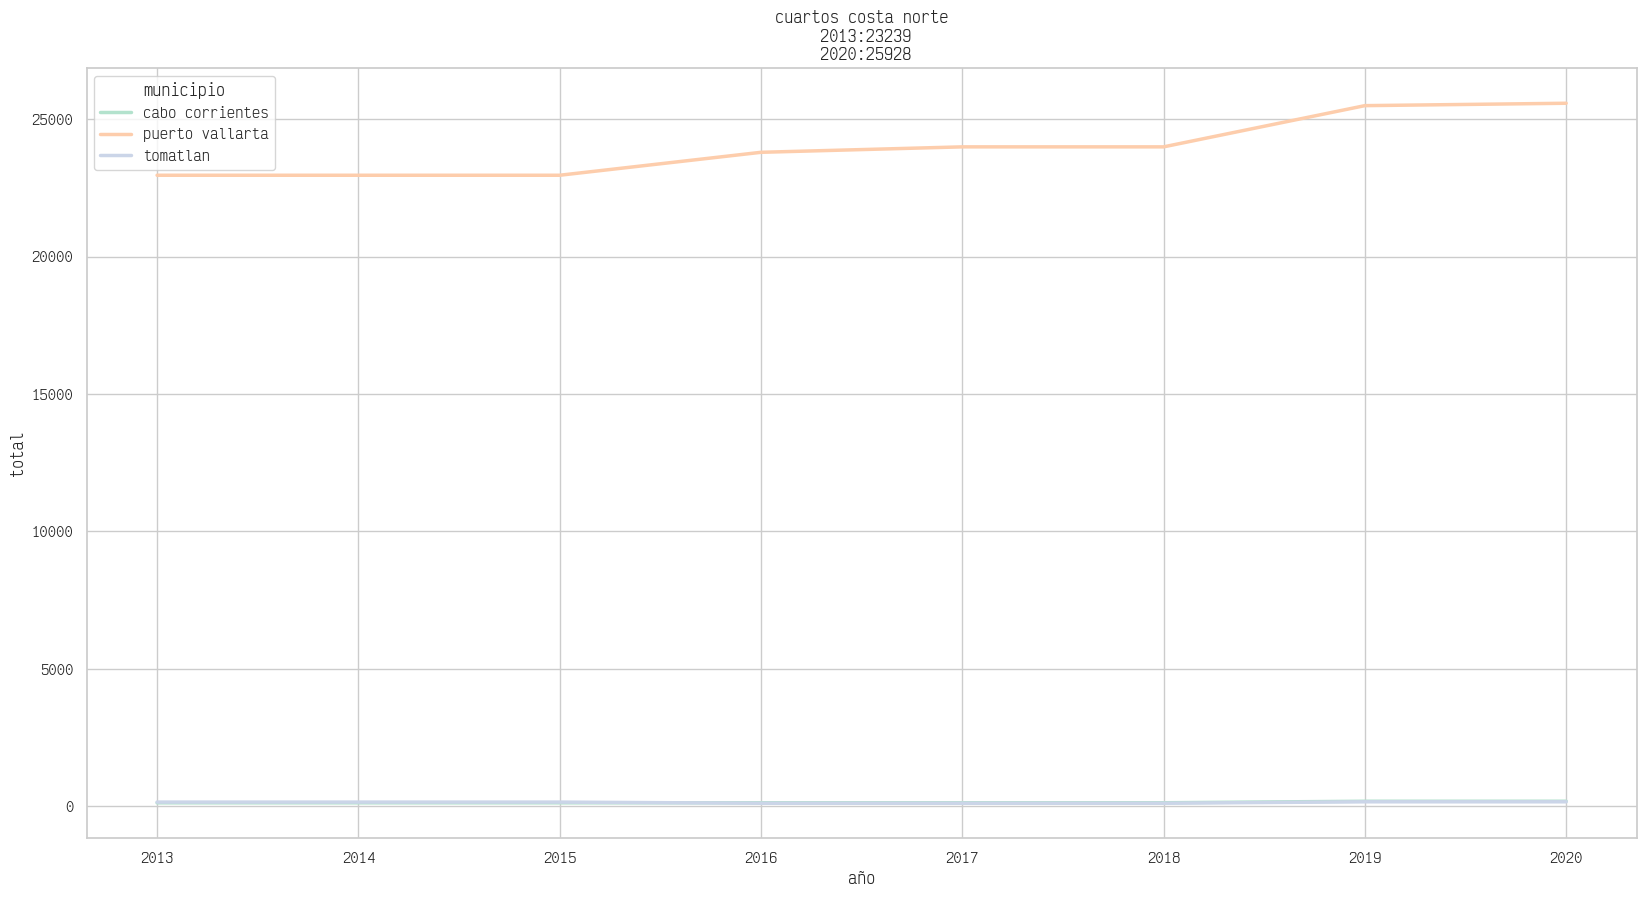

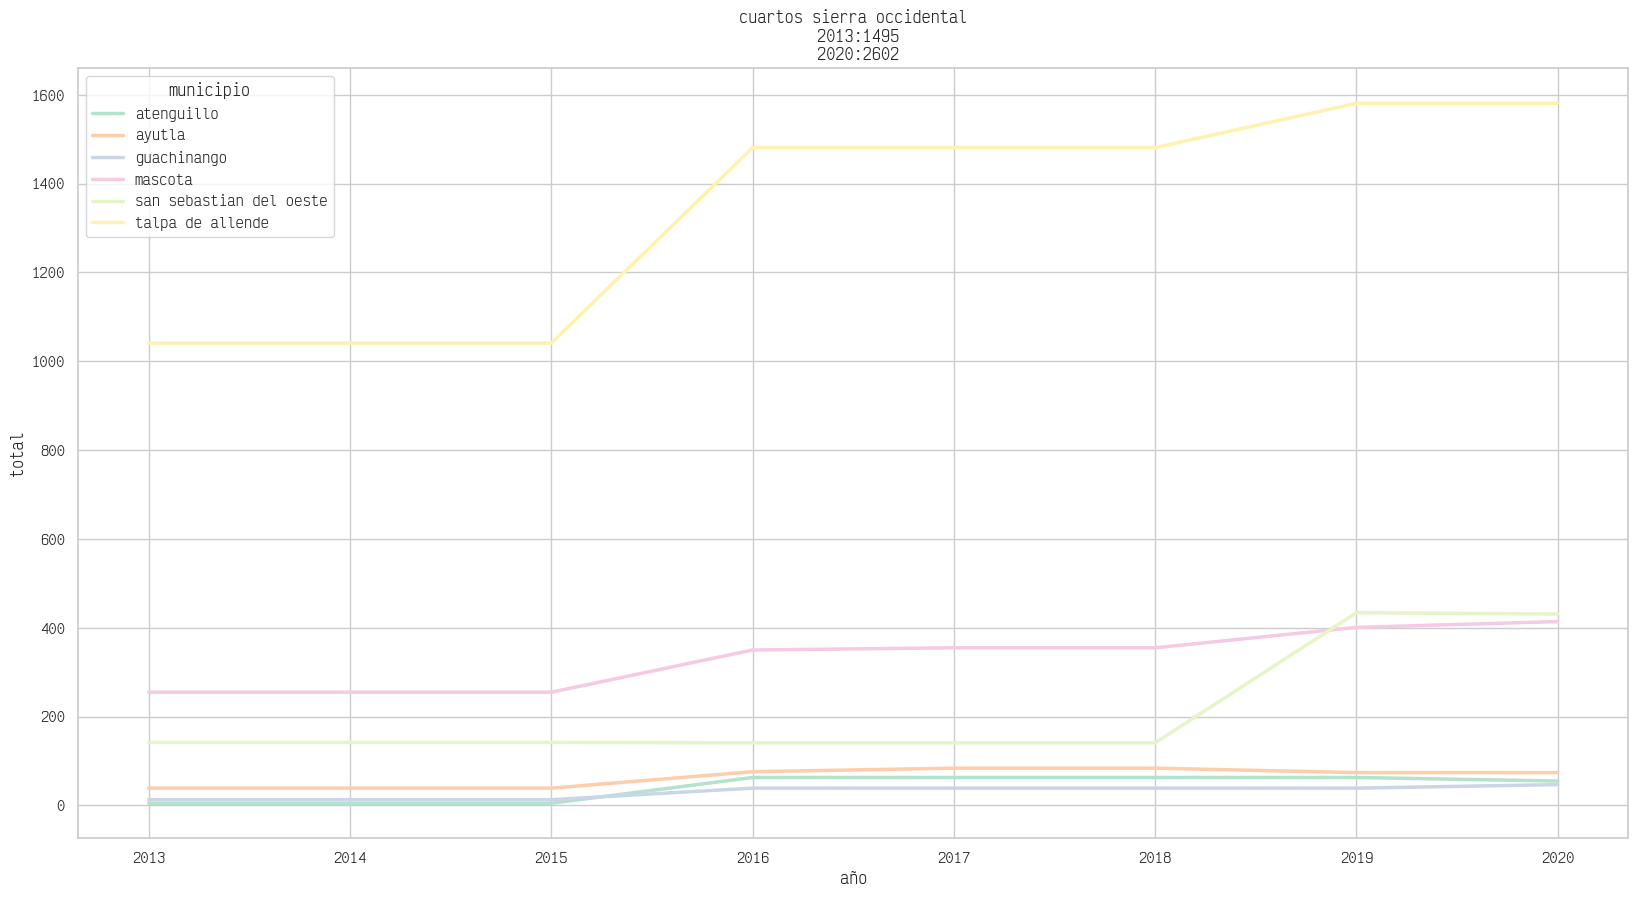

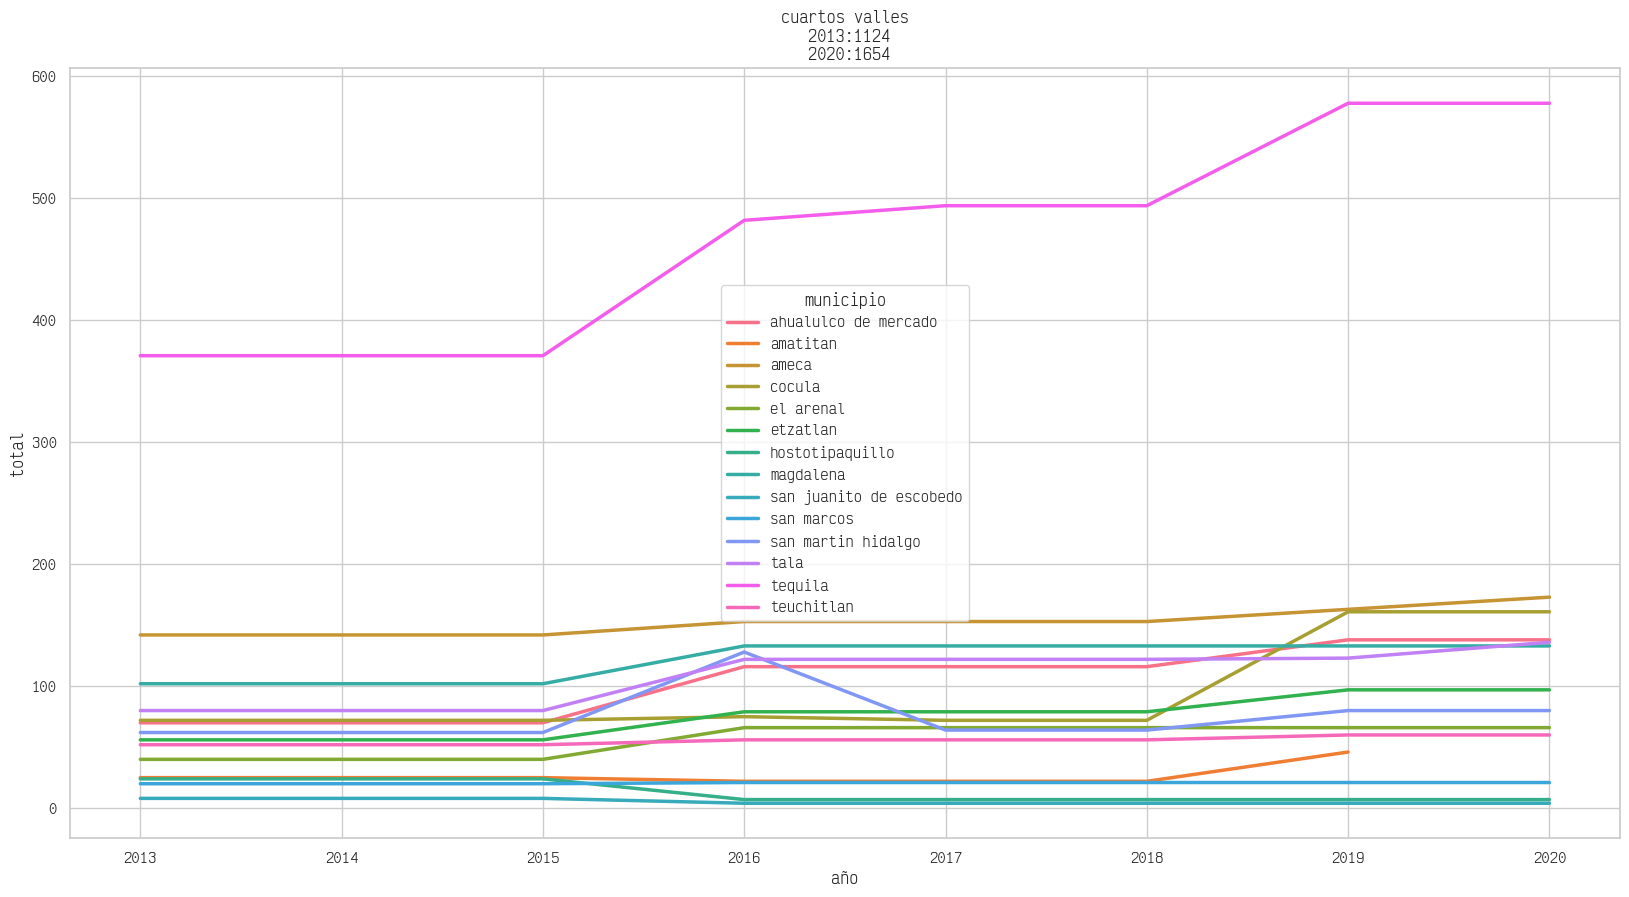

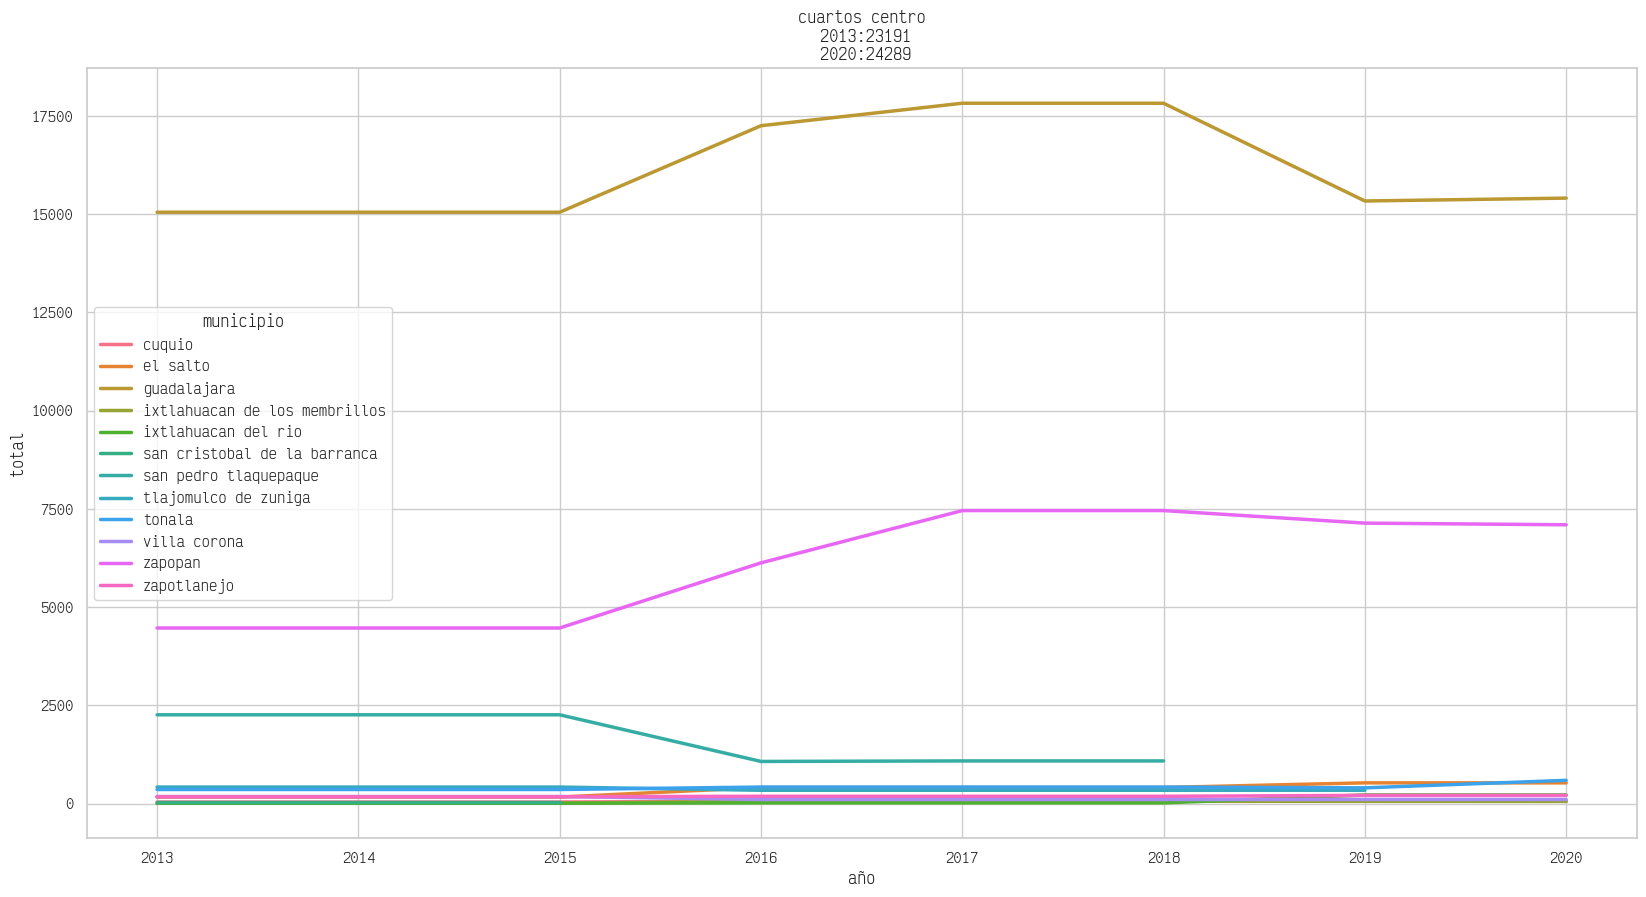

In [5]:
for region in df_cuartos['region'].unique():
    
    df = df_cuartos[df_cuartos['region'] == region]
    total_2013 = df[df['año'] == 2013]['total'].sum()
    total_2020 = df[df['año'] == 2020]['total'].sum()

    fig,ax = plt.subplots(1,1,figsize=(20,10))
    sns.lineplot(df,x='año',y='total',hue='municipio',ax=ax,linewidth=2.5)
    ax.set_title(f'cuartos {region}\n 2013:{total_2013}\n 2020:{total_2020}')

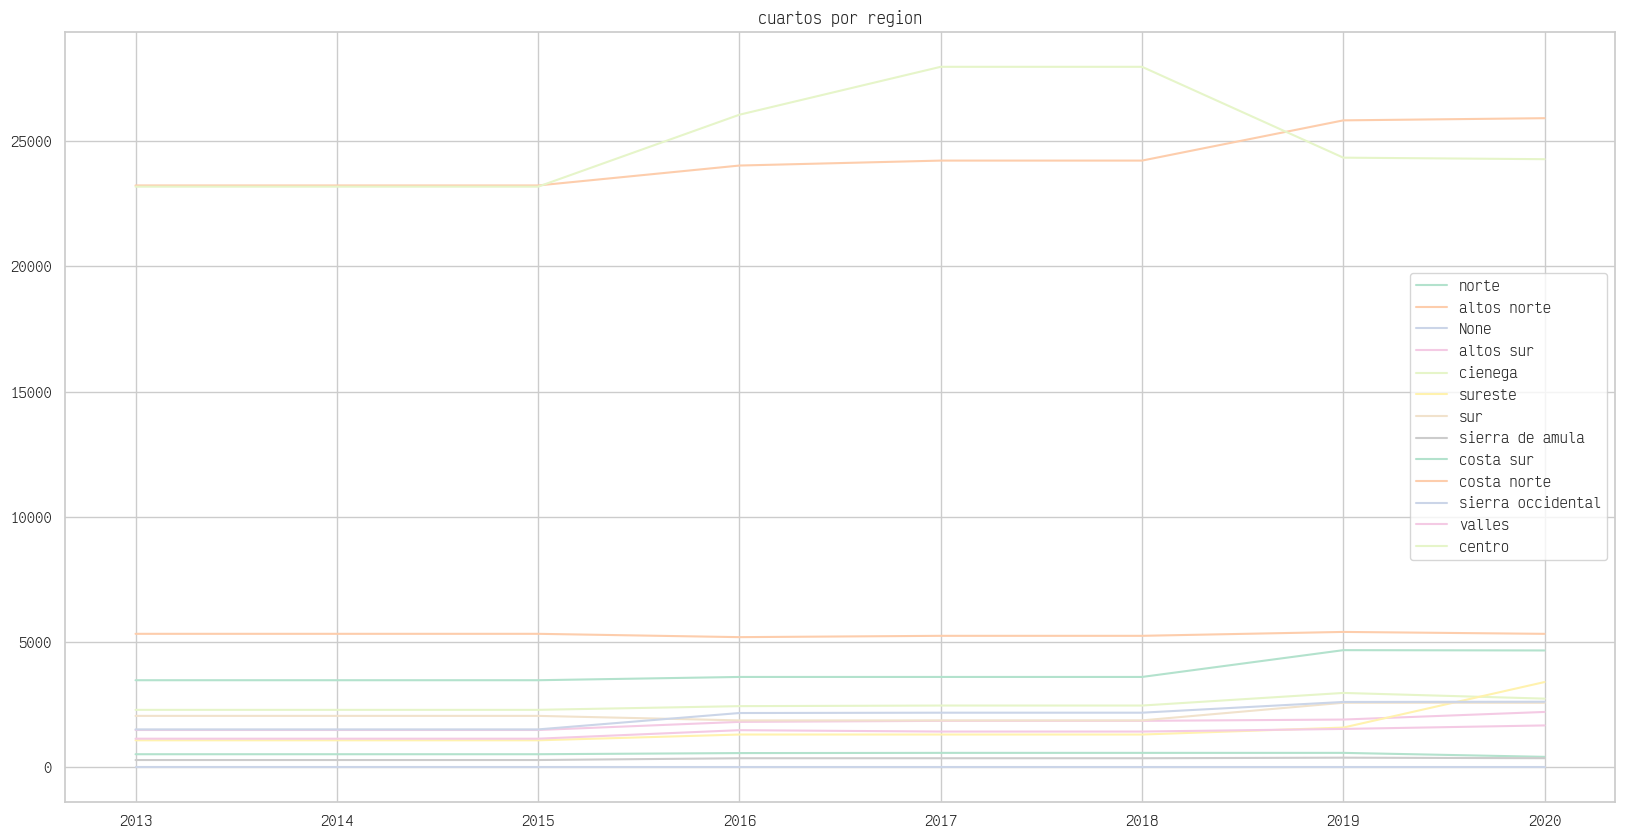

In [6]:
fig,ax = plt.subplots(1,1,figsize=(20,10))
for region in df_cuartos['region'].unique():
    

    df = df_cuartos[df_cuartos['region'] == region]
    totales = [df[df['año'] == year]['total'].sum() for year in range(2013,2021) ]
    

    sns.lineplot(x=[y for y in range(2013,2021)],y=totales,ax=ax,label=f'{region}')
ax.set_title('cuartos por region')
ax.legend()

In [7]:

df_hoteles_rel = df_hoteles.copy()
df_hoteles_rel = df_hoteles_rel.drop(df_hoteles_rel[(df_hoteles_rel['año'] != 2013) & (df_hoteles_rel['año'] != 2020)].index)


df_hoteles_rel = df_hoteles_rel.groupby('municipio')

C:\Users\fofoy\AppData\Local\Temp\ipykernel_20356\905332895.py:14: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig,ax = plt.subplots(1,1)


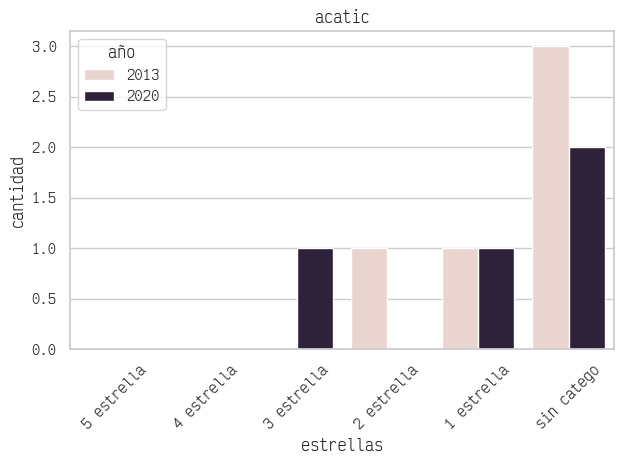

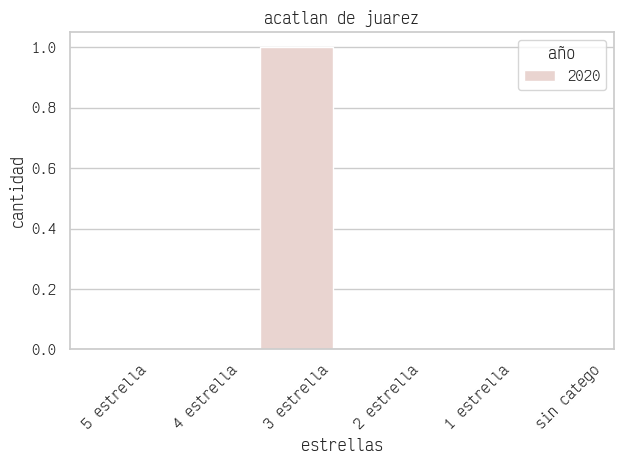

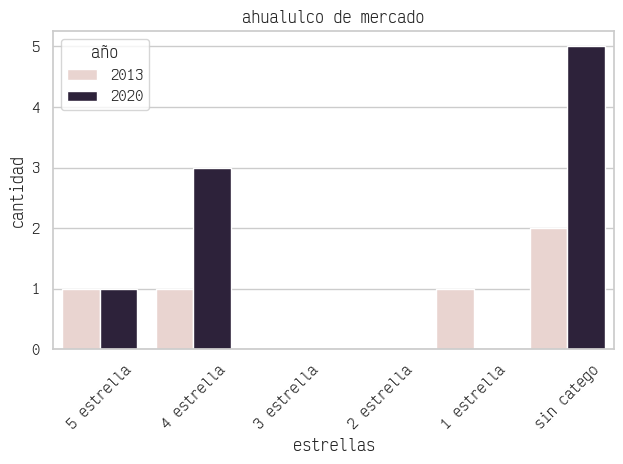

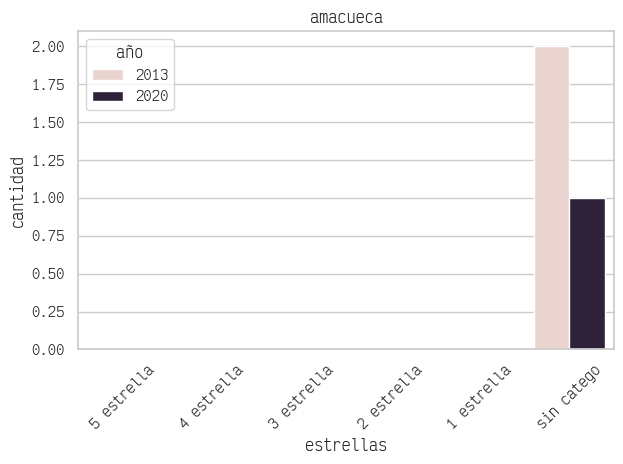

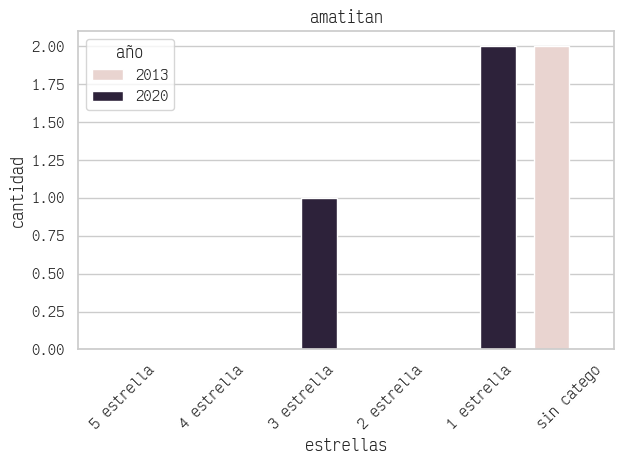

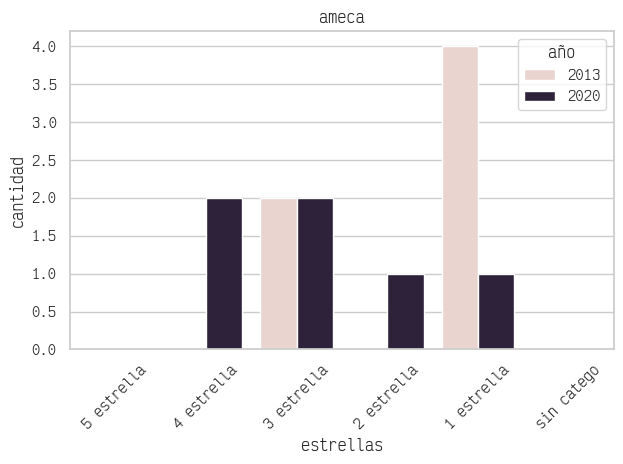

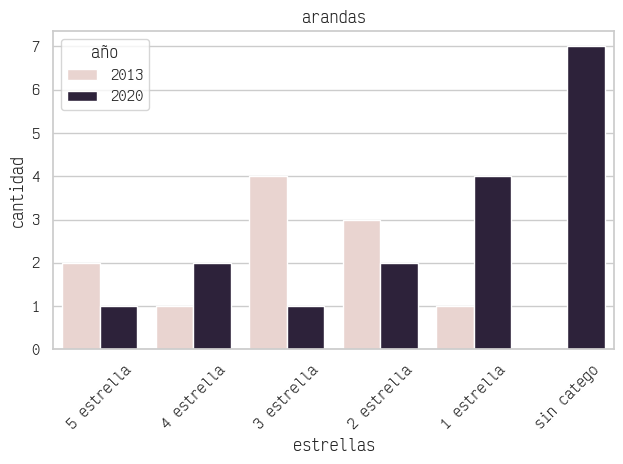

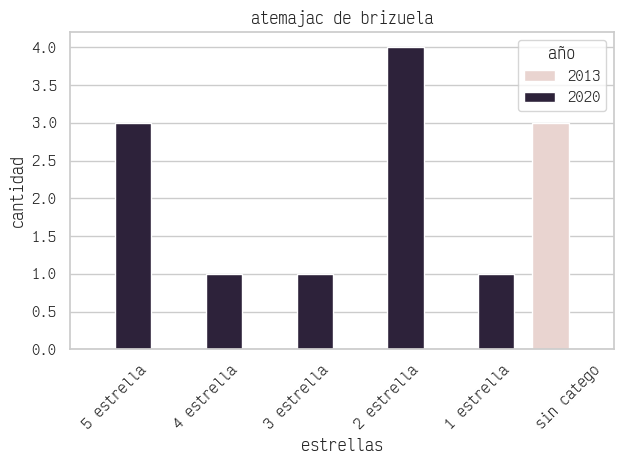

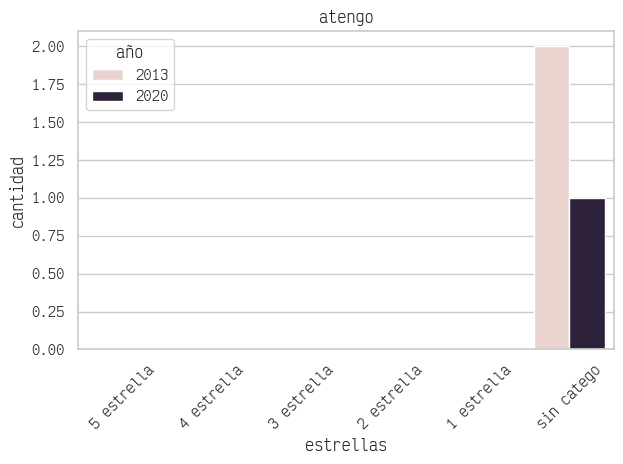

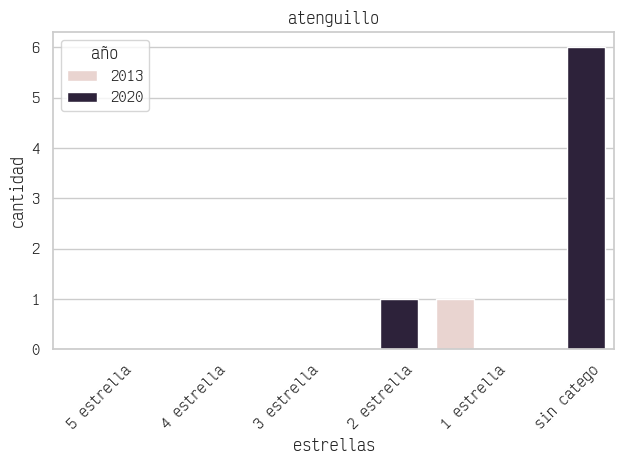

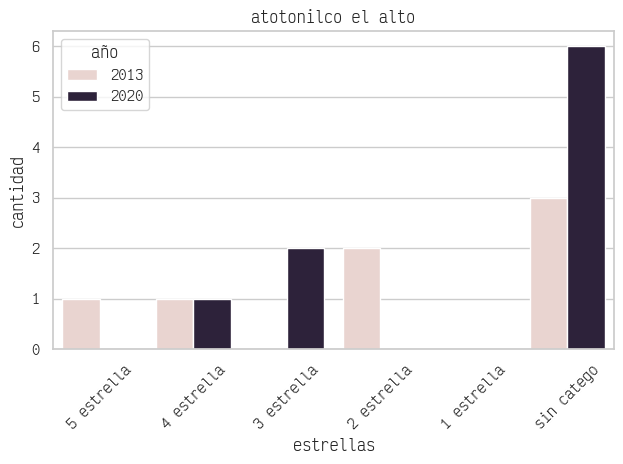

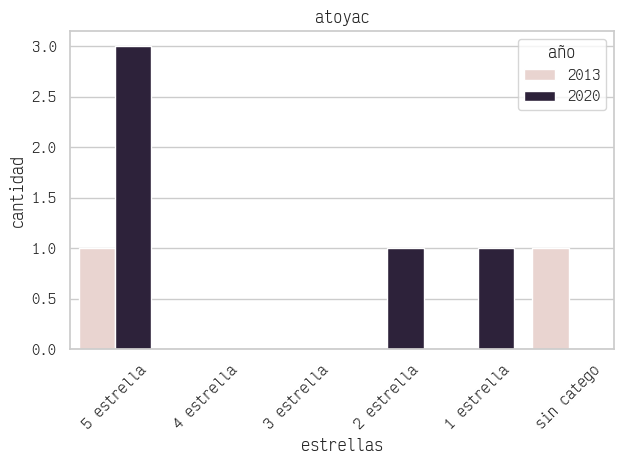

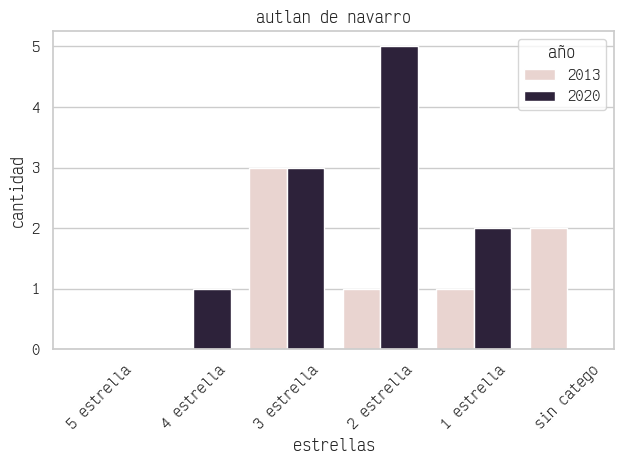

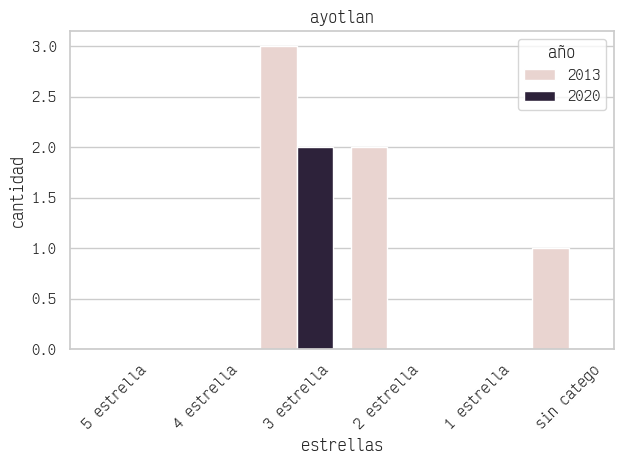

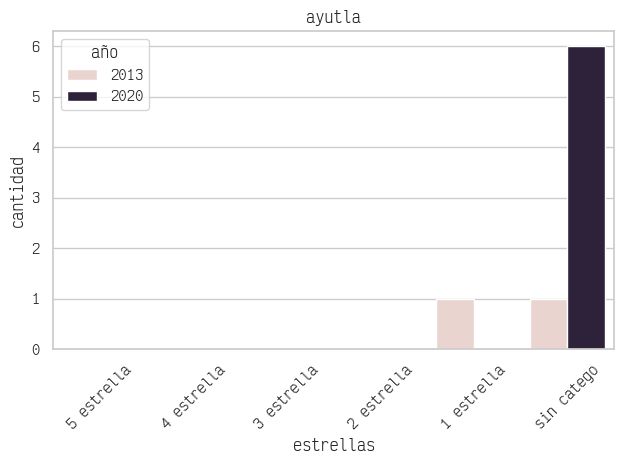

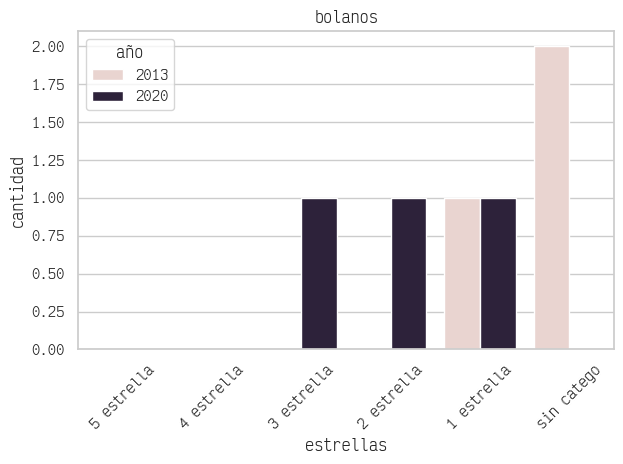

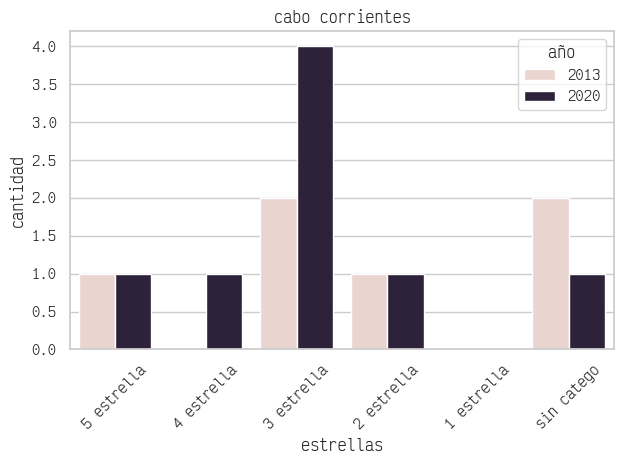

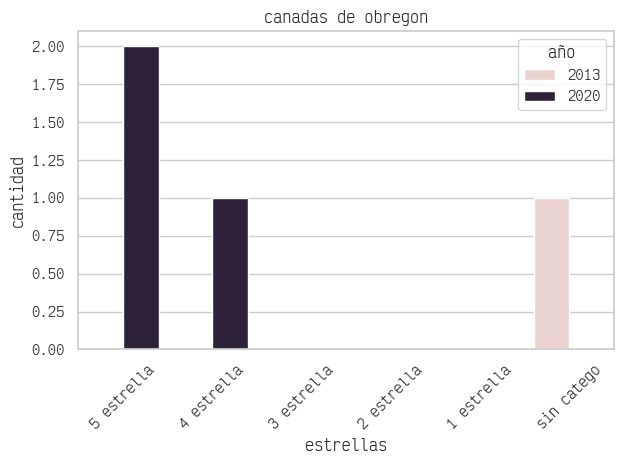

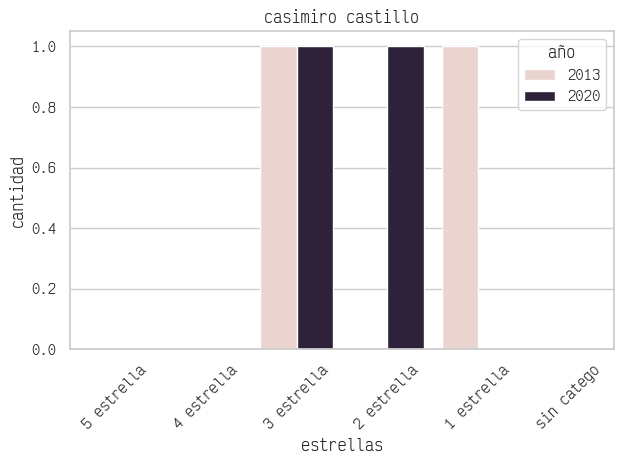

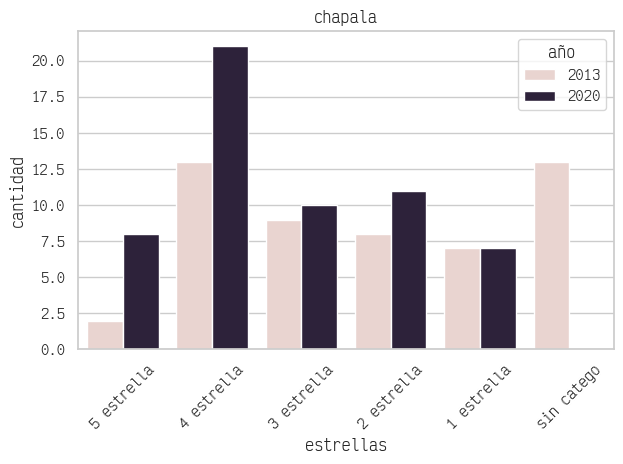

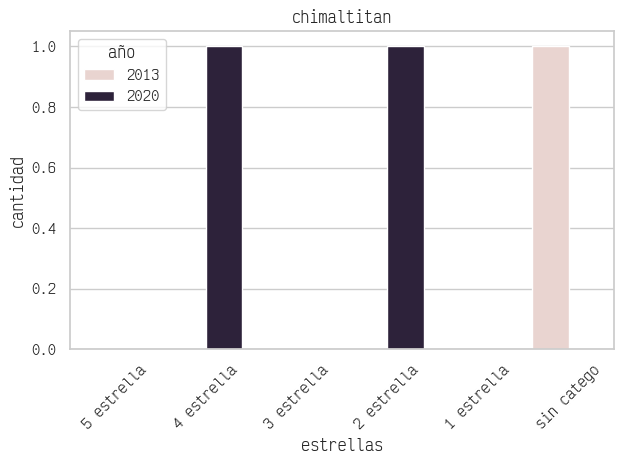

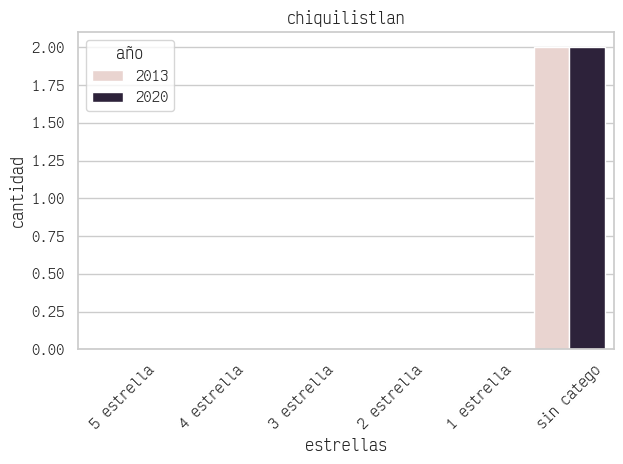

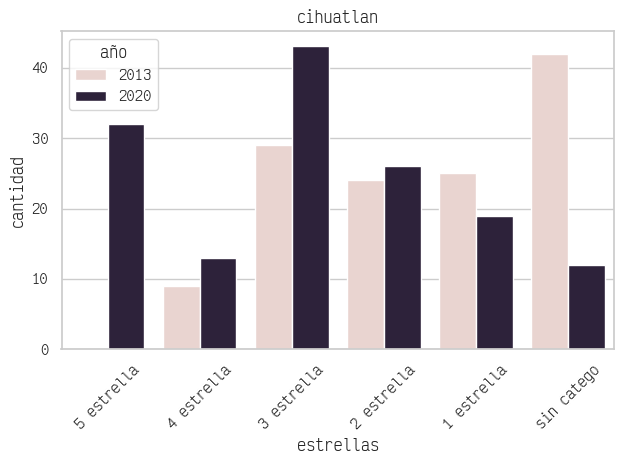

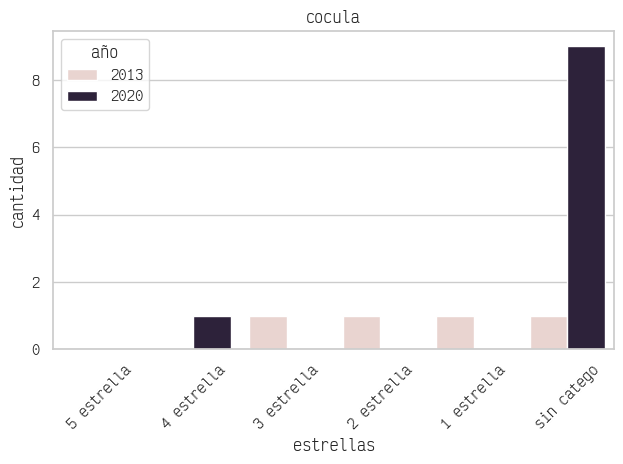

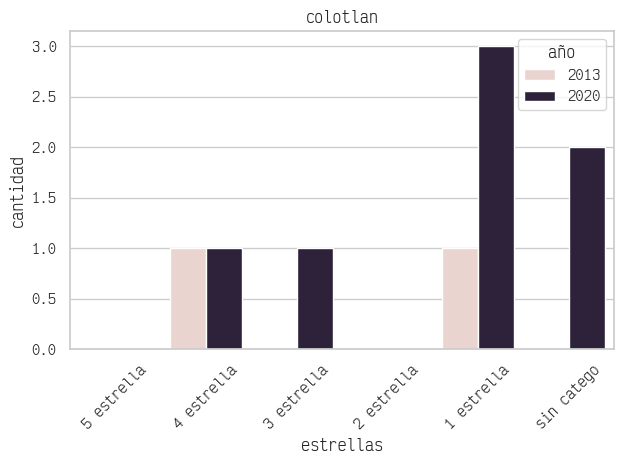

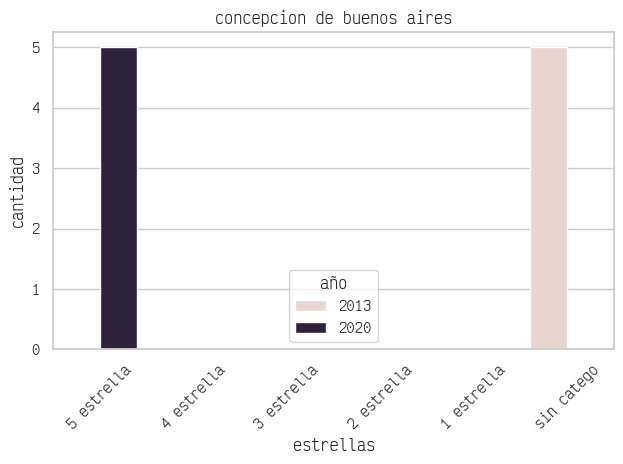

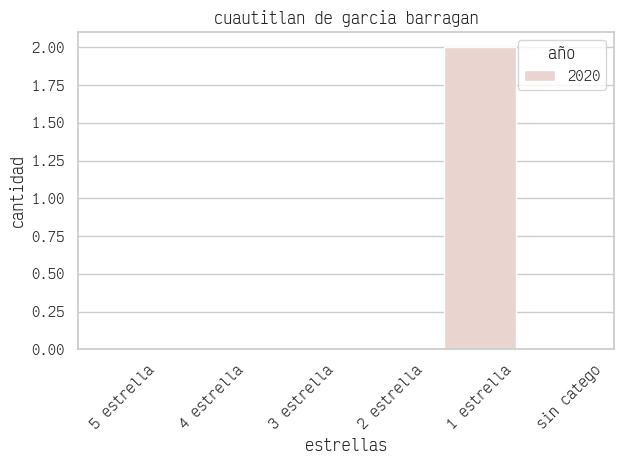

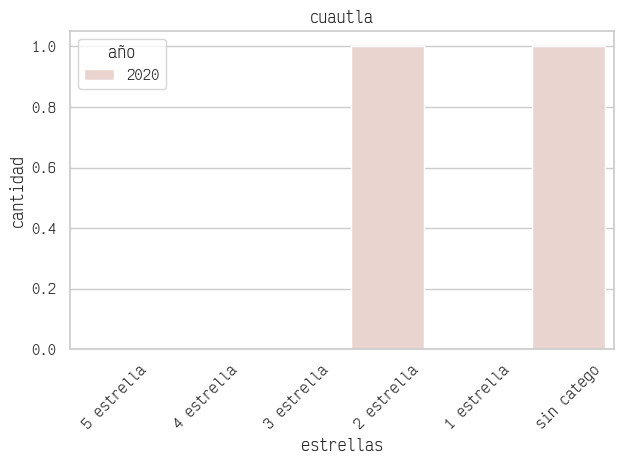

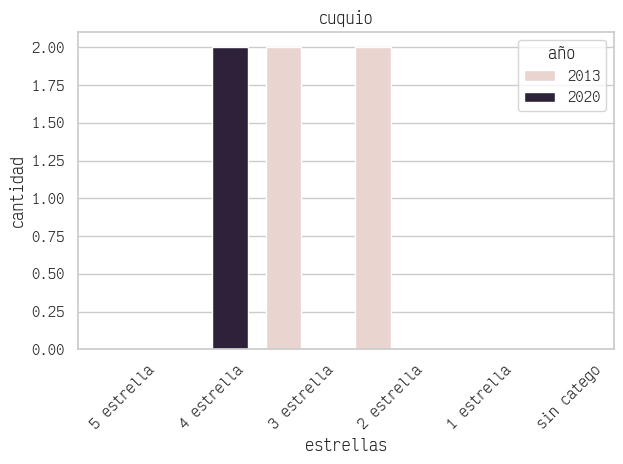

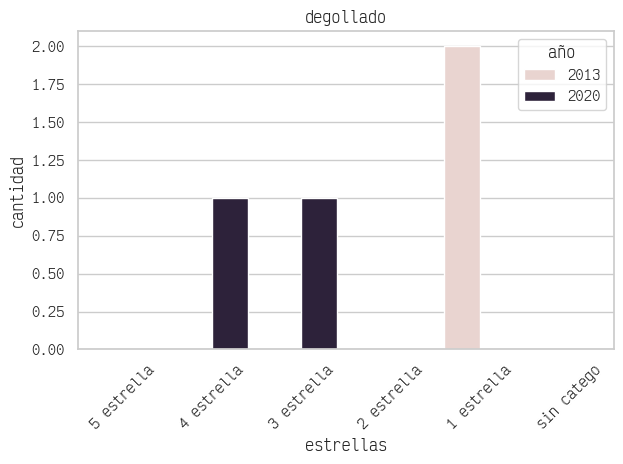

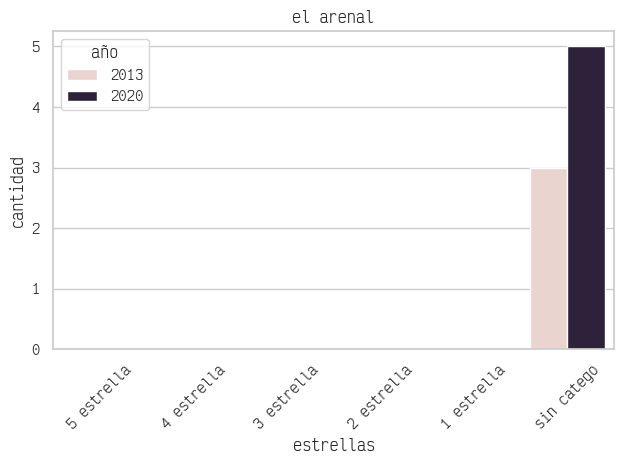

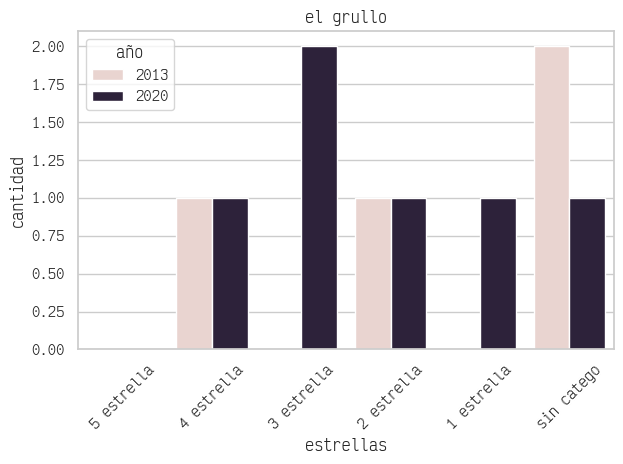

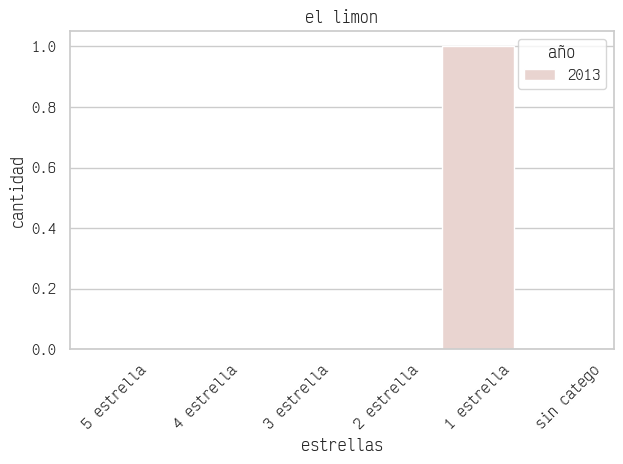

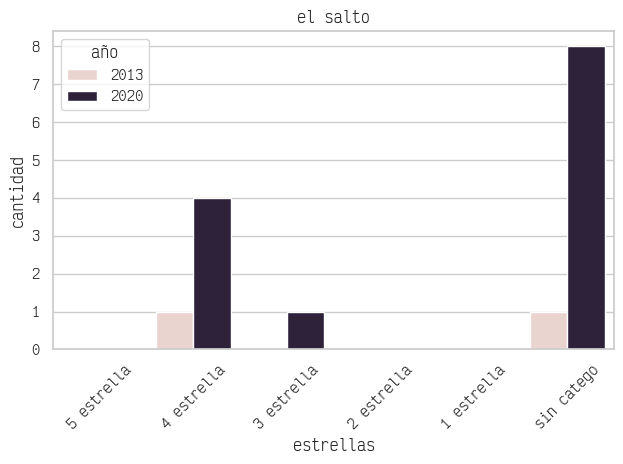

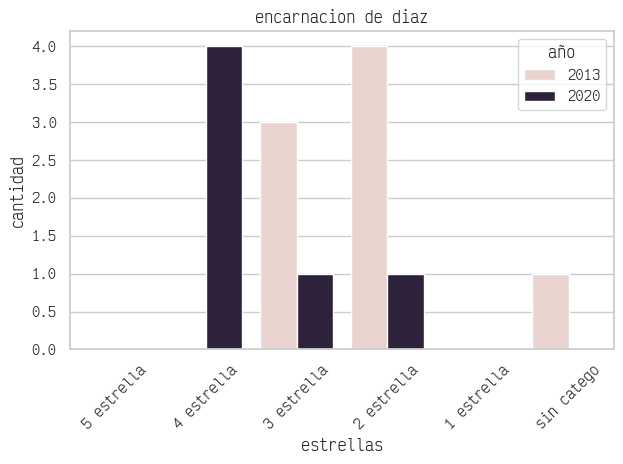

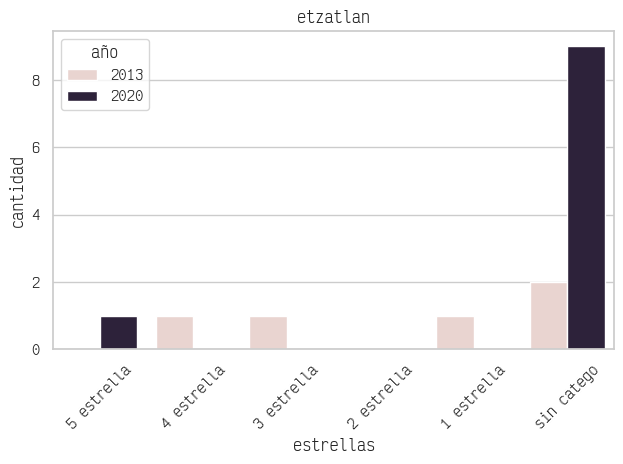

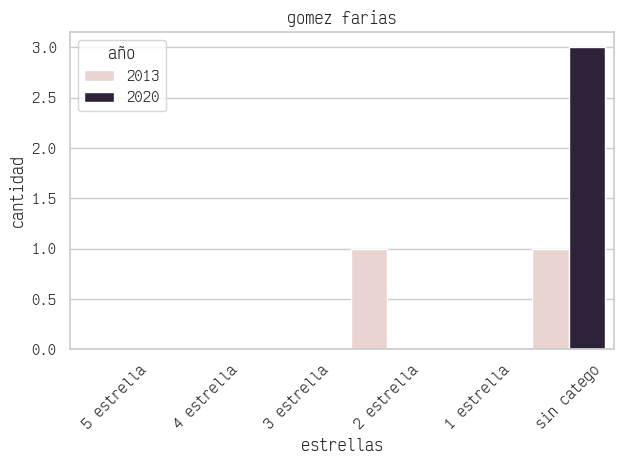

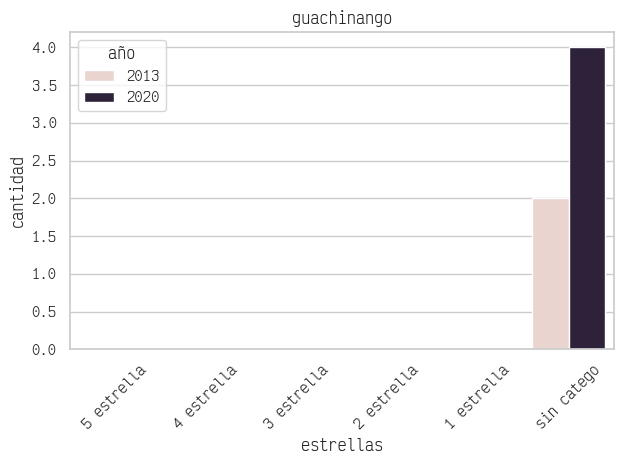

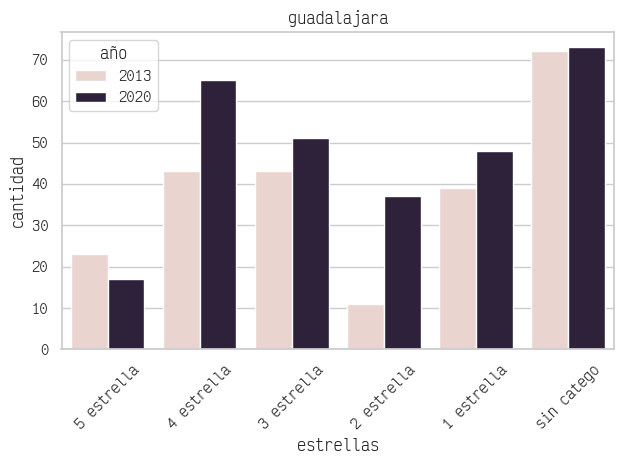

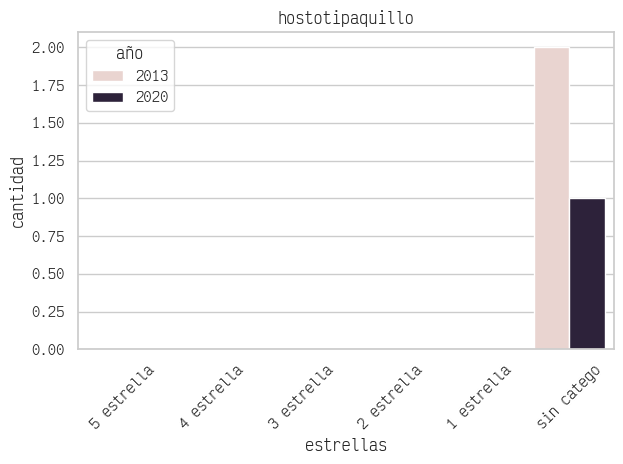

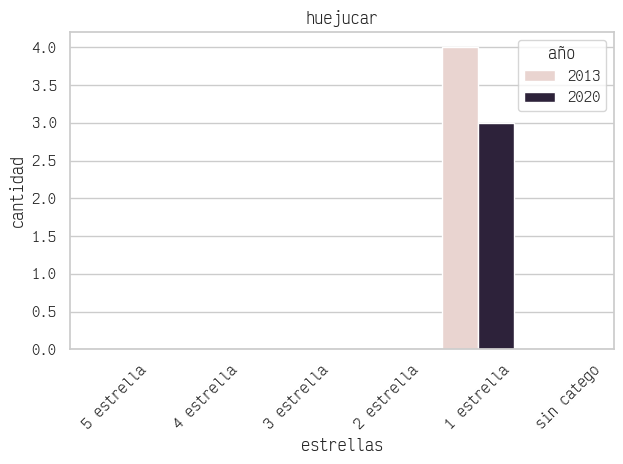

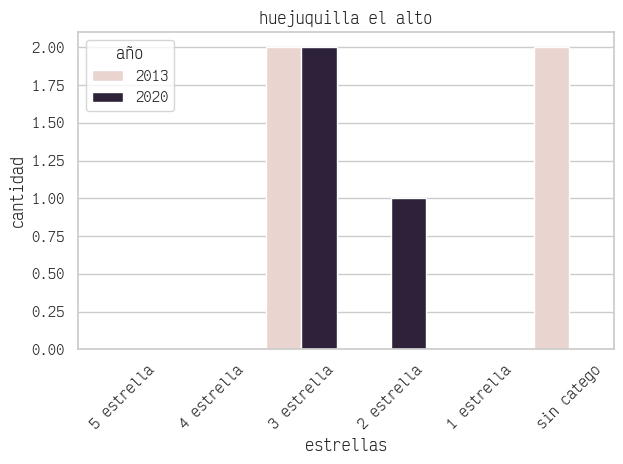

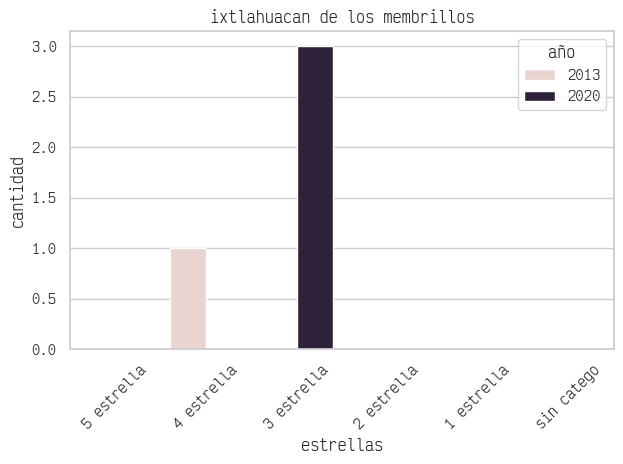

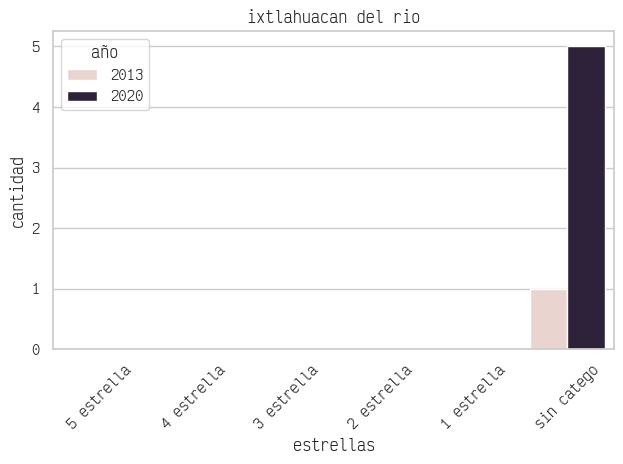

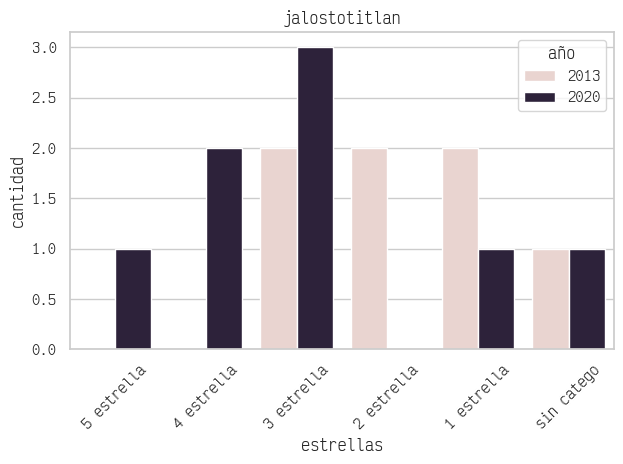

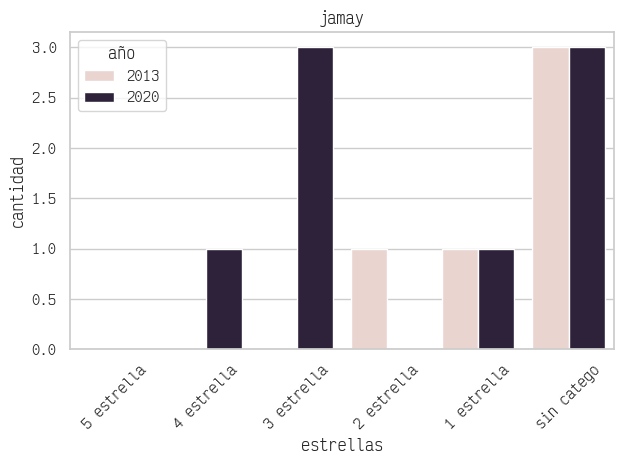

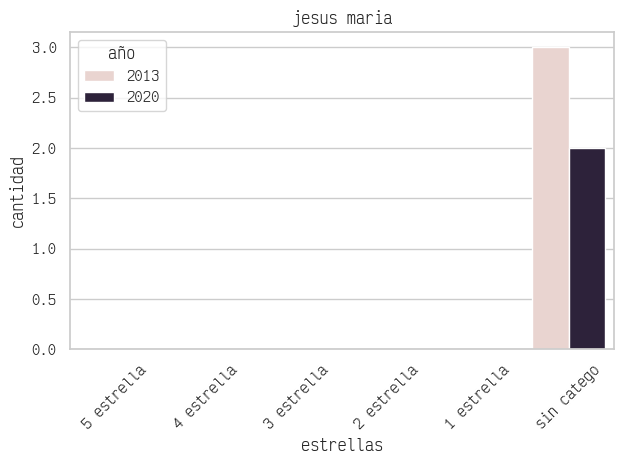

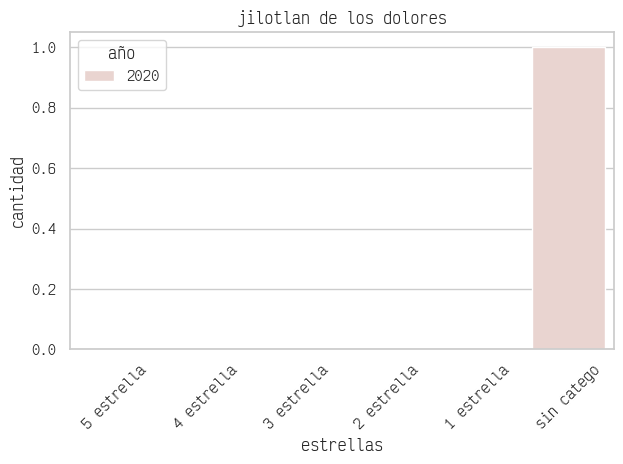

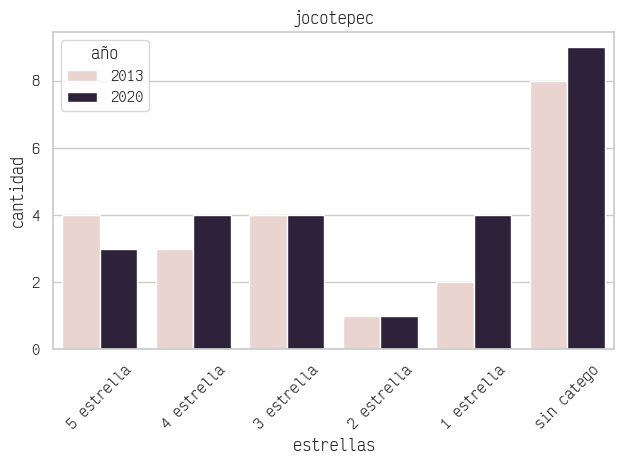

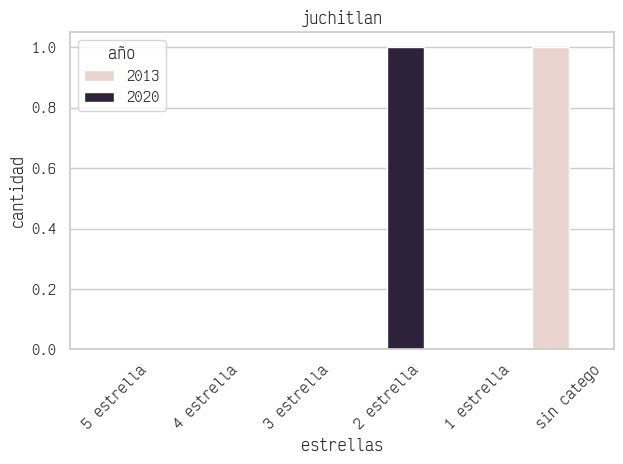

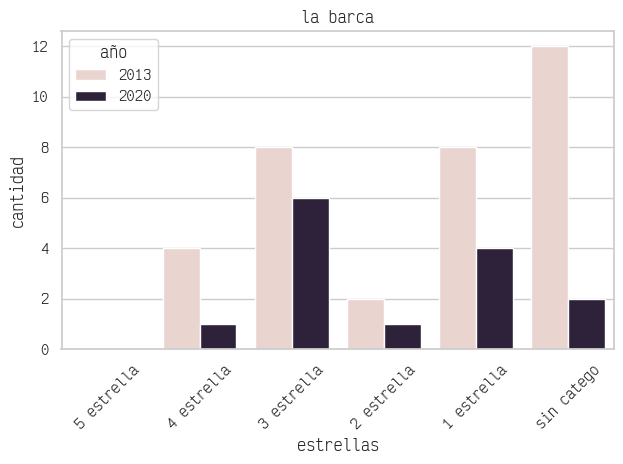

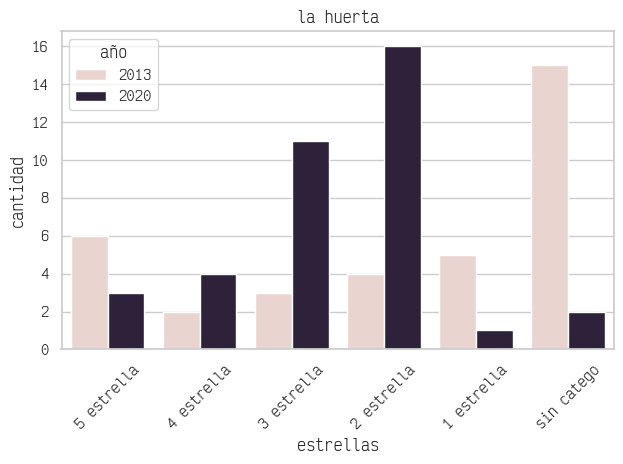

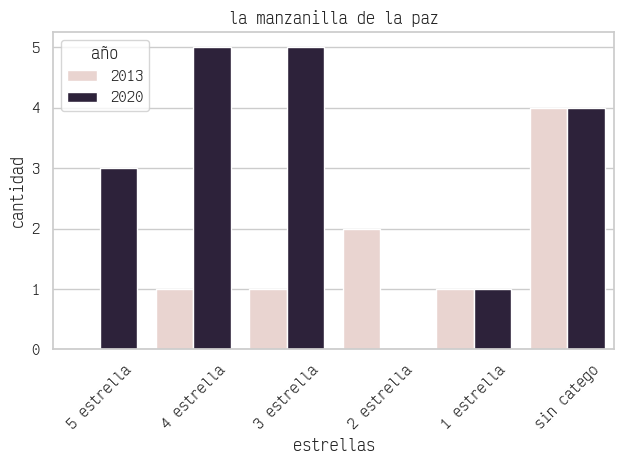

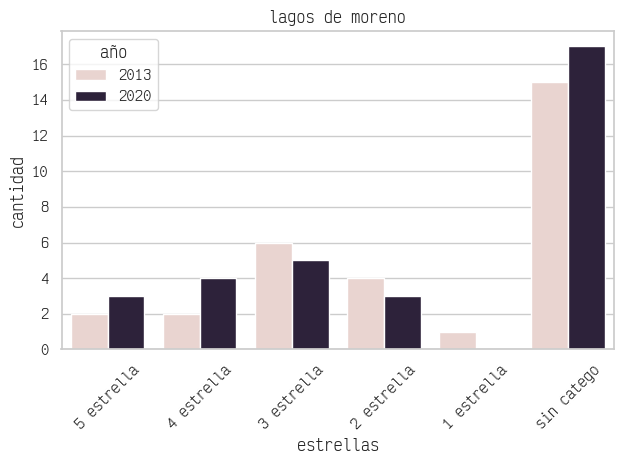

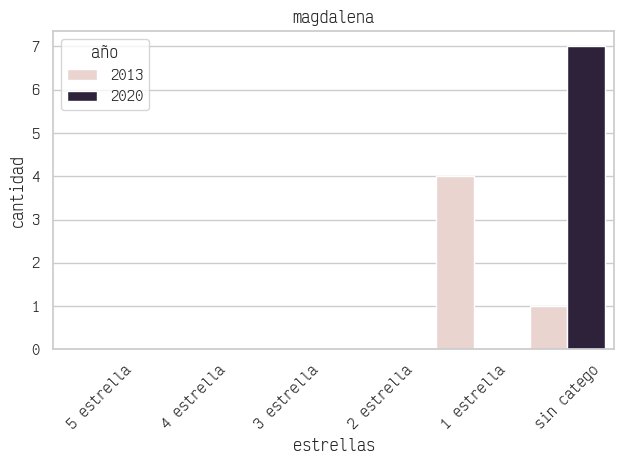

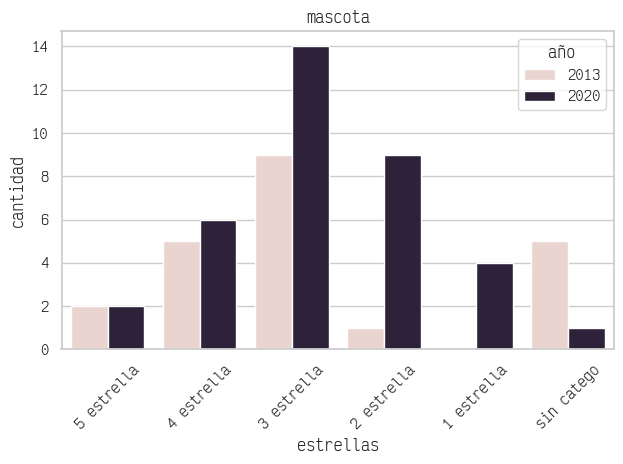

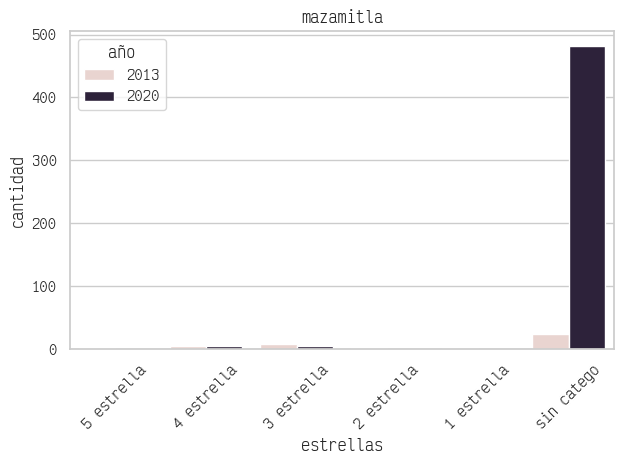

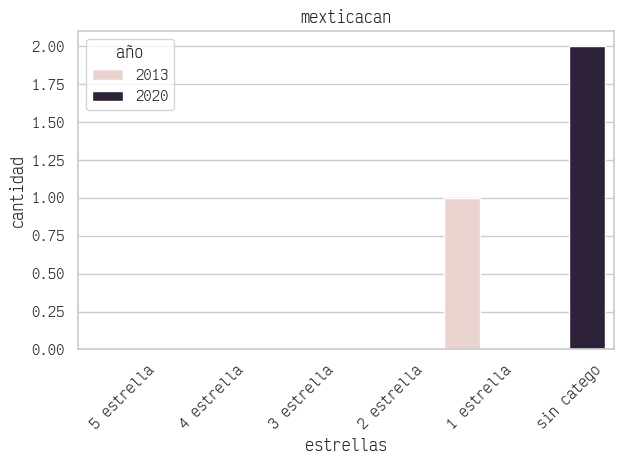

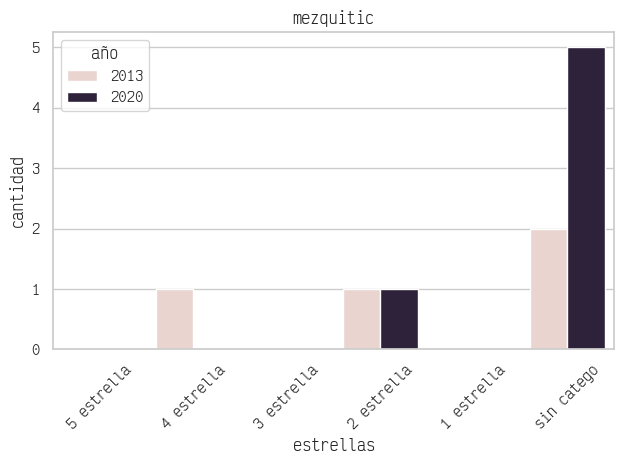

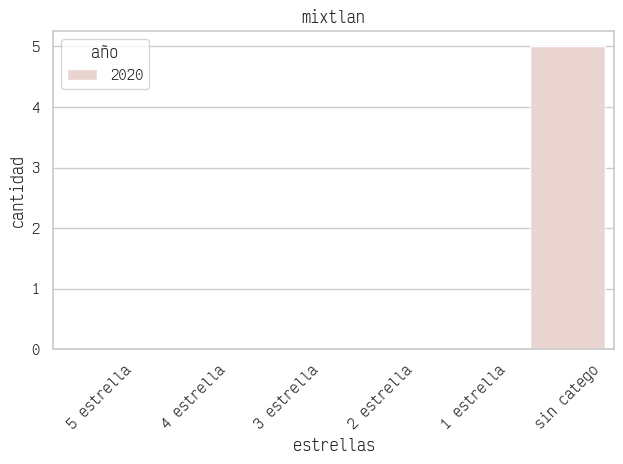

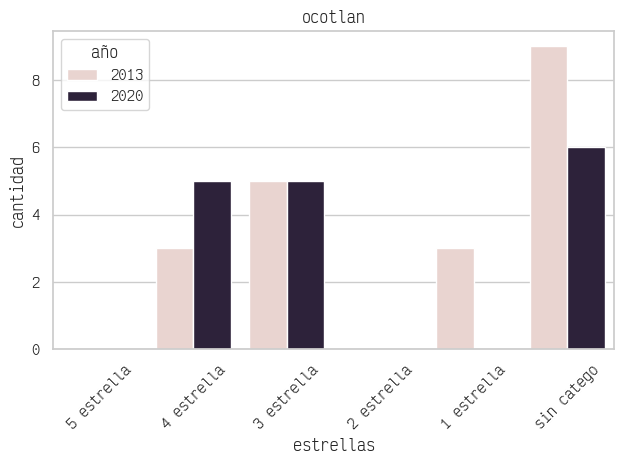

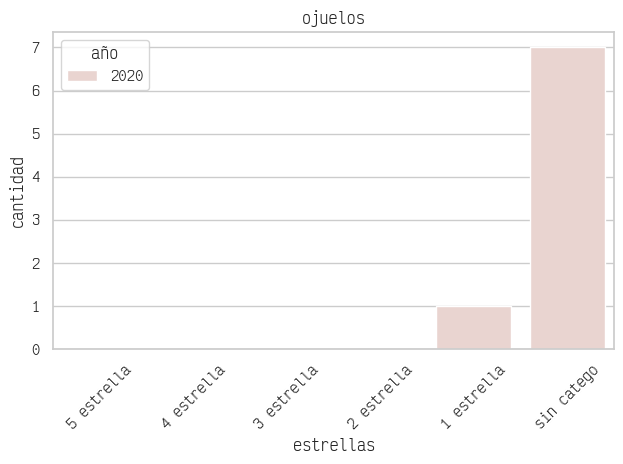

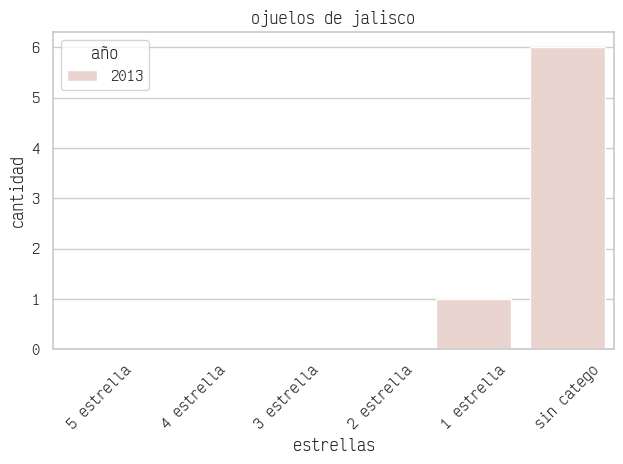

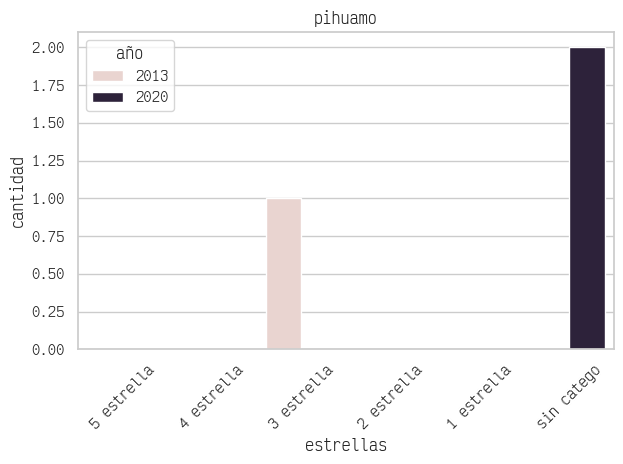

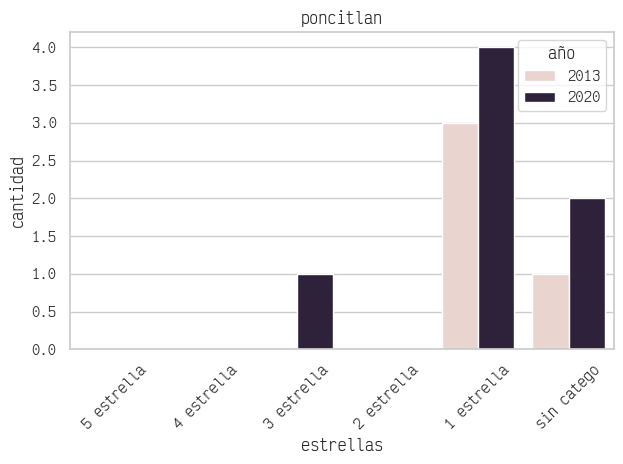

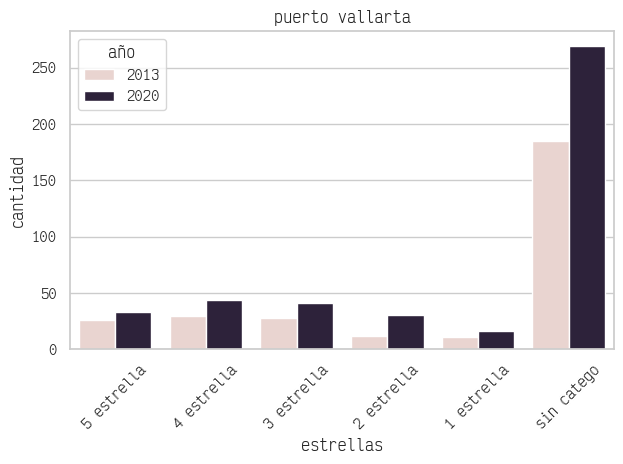

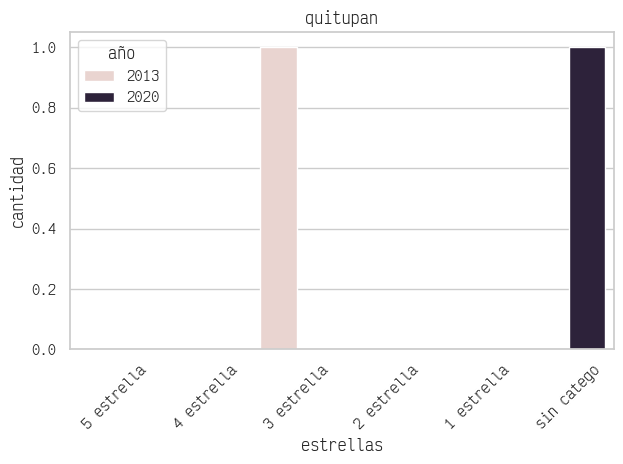

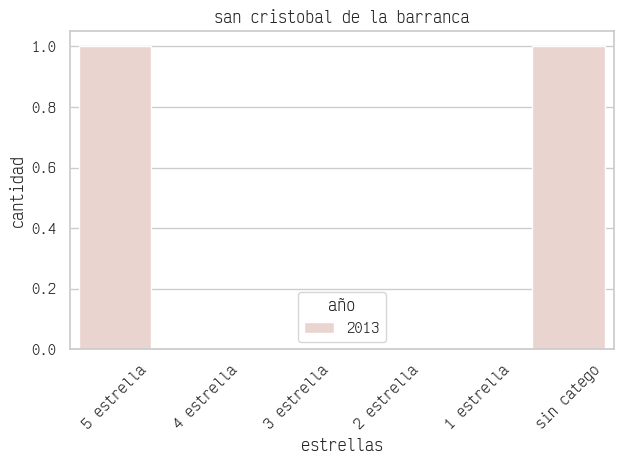

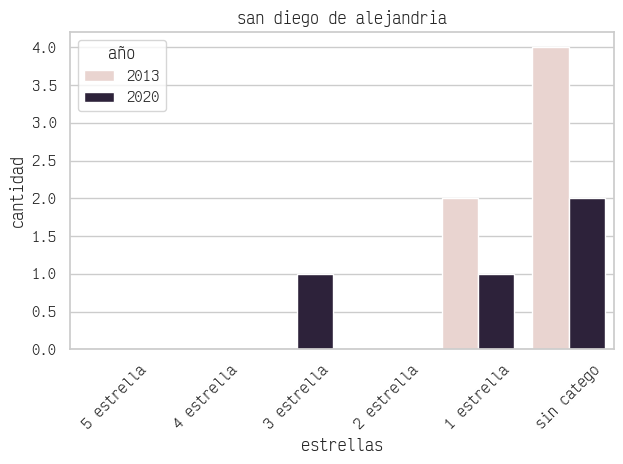

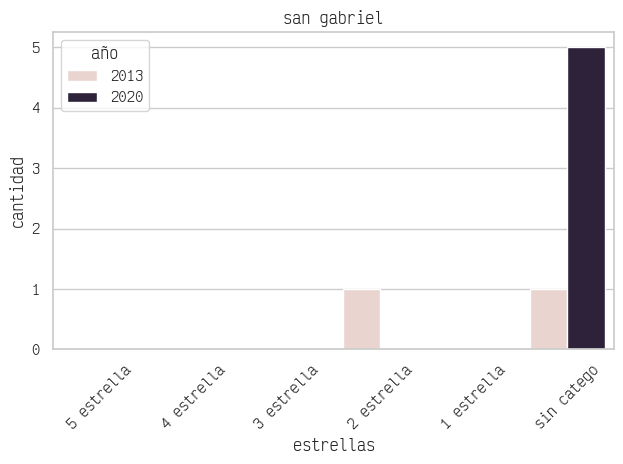

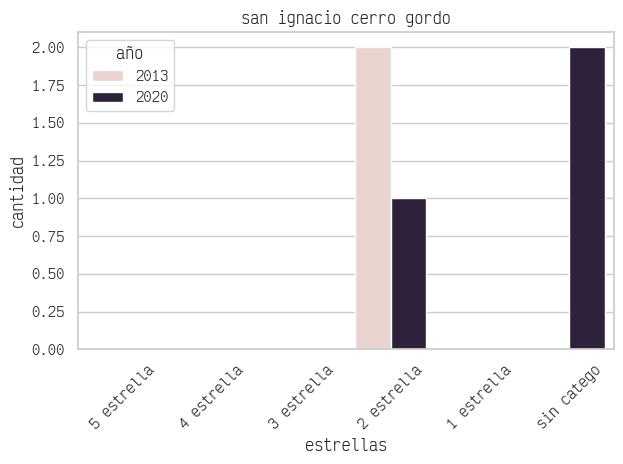

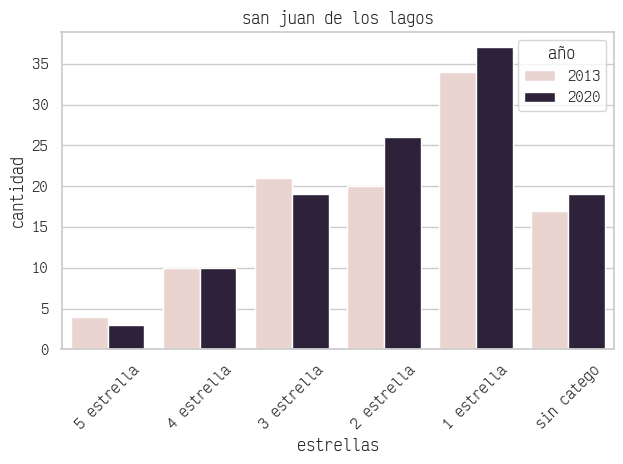

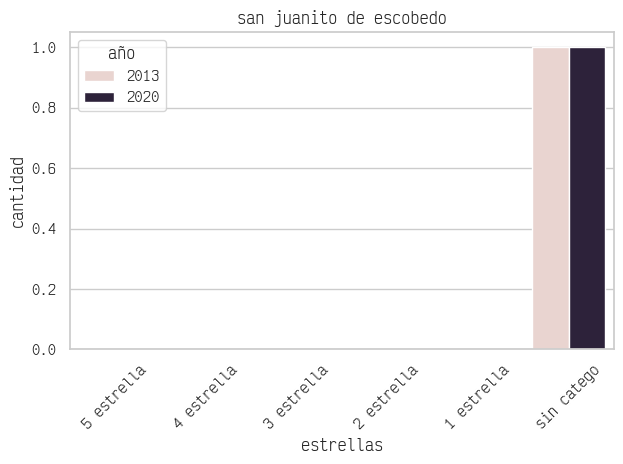

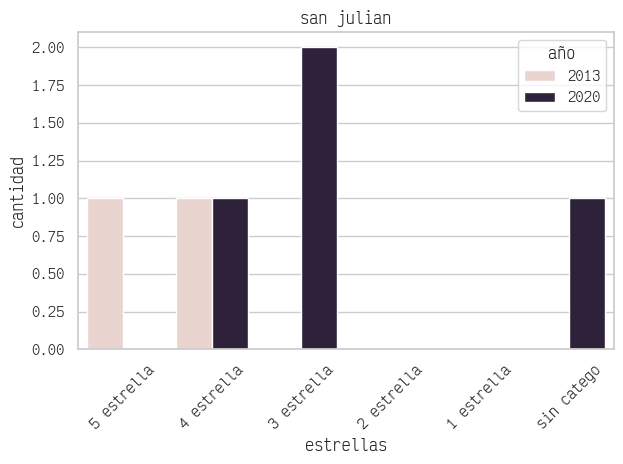

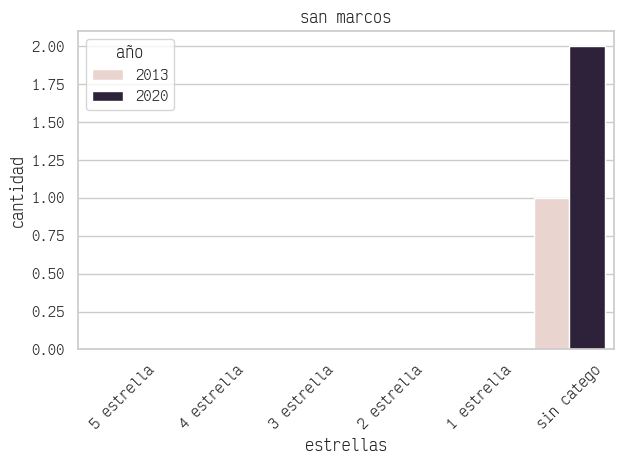

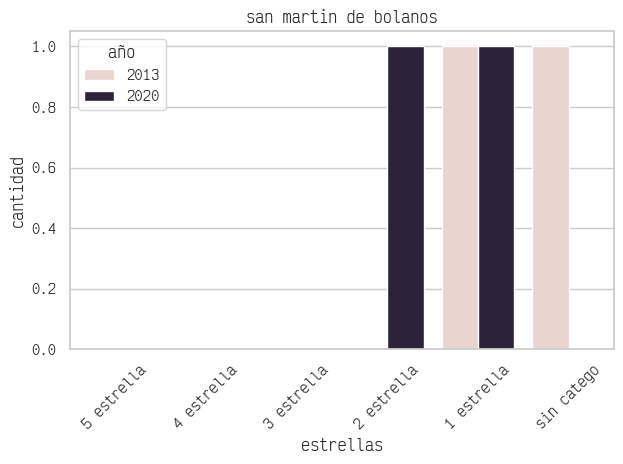

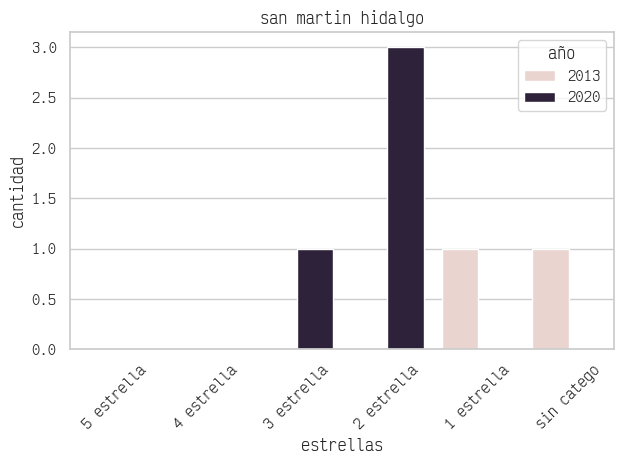

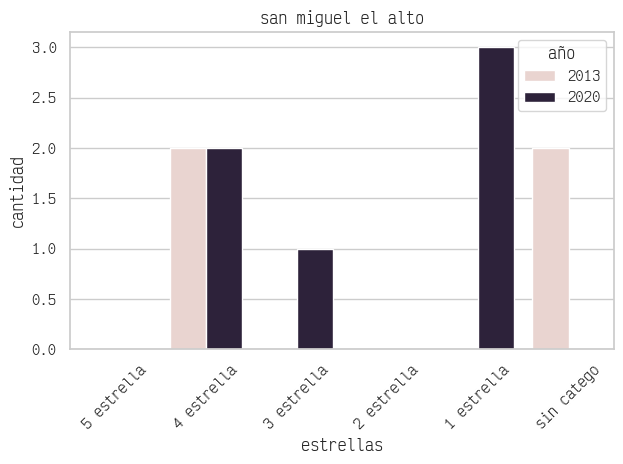

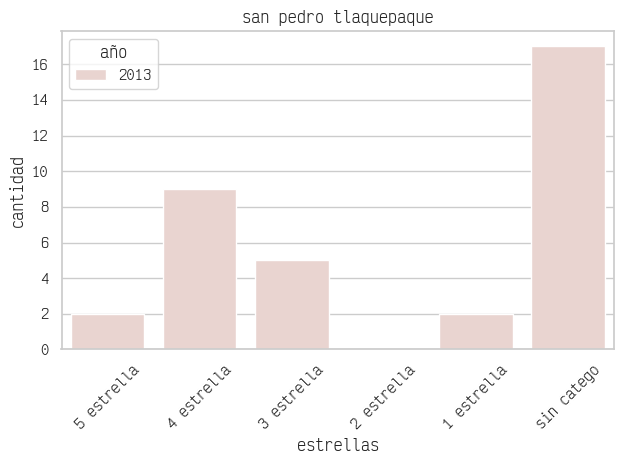

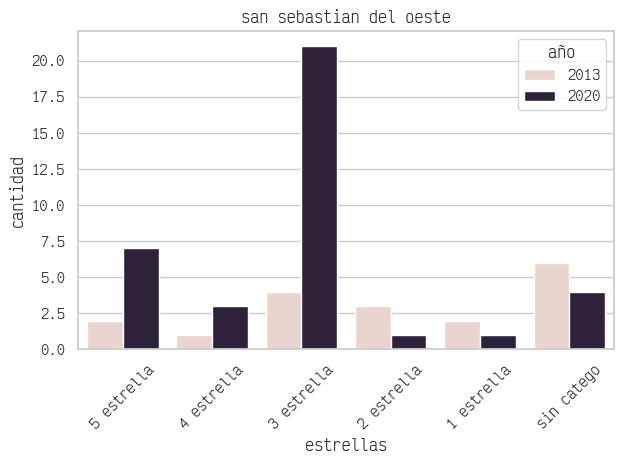

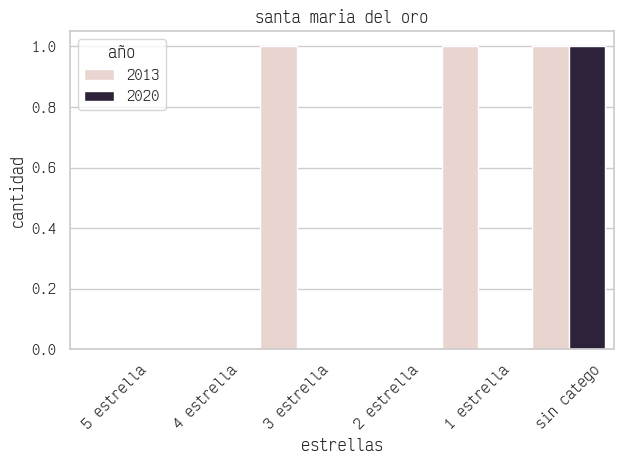

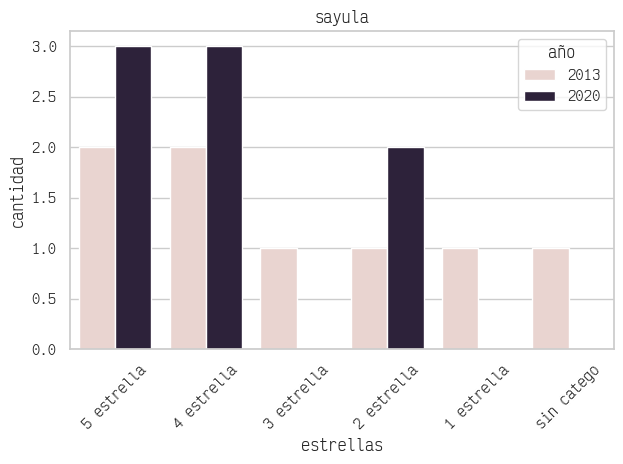

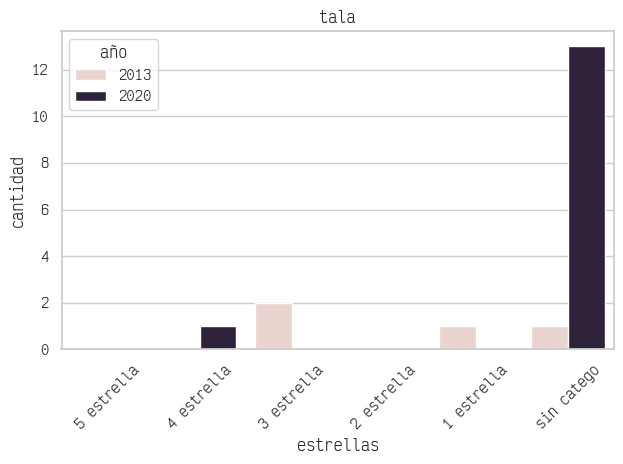

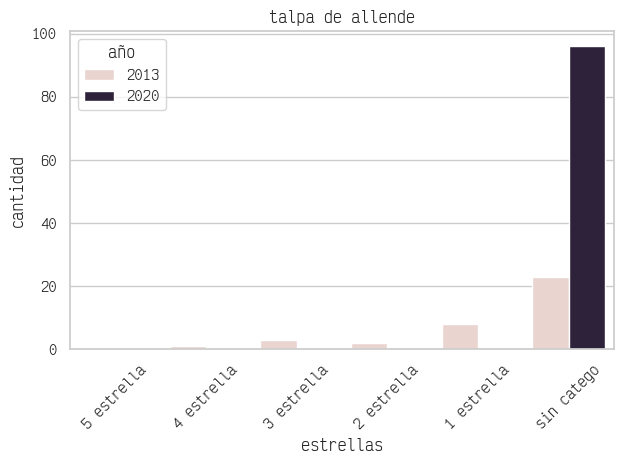

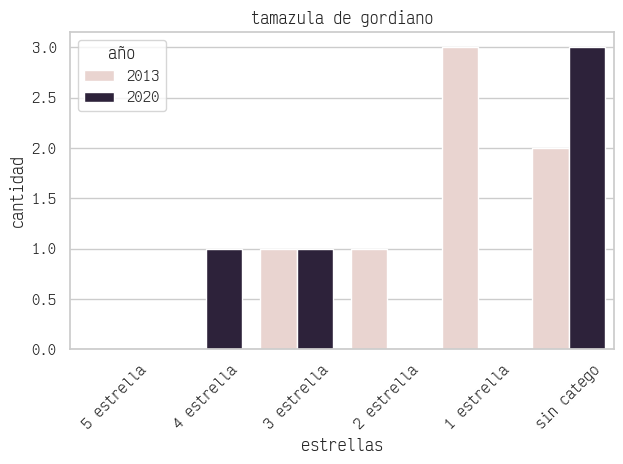

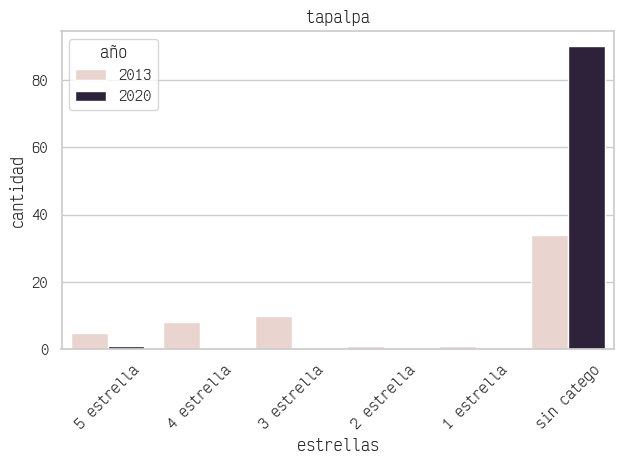

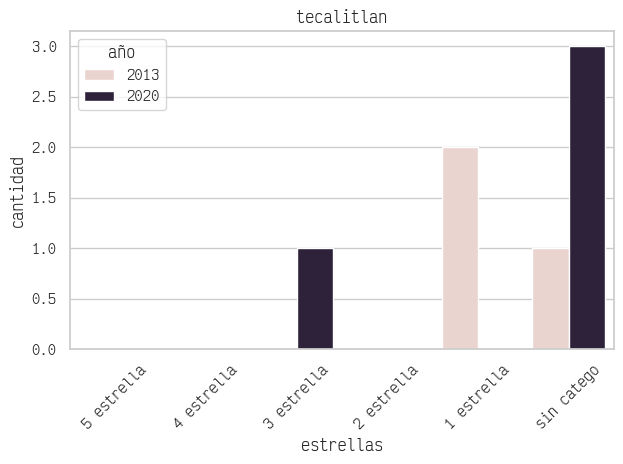

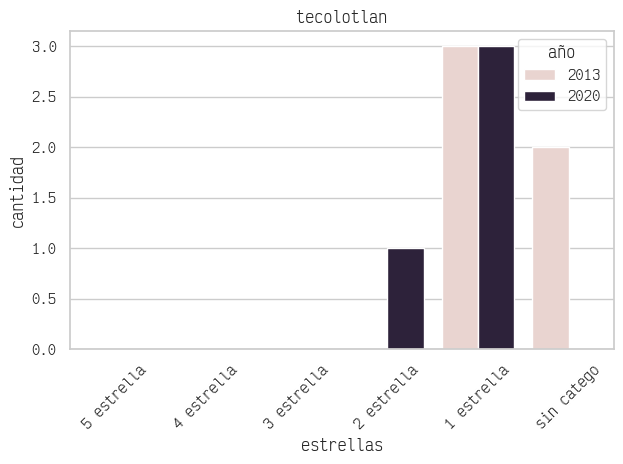

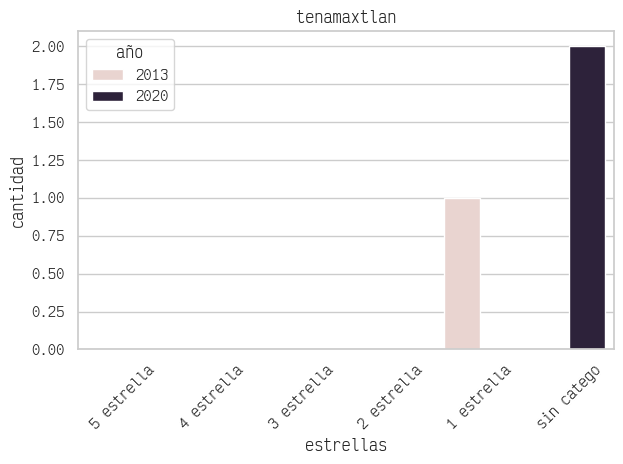

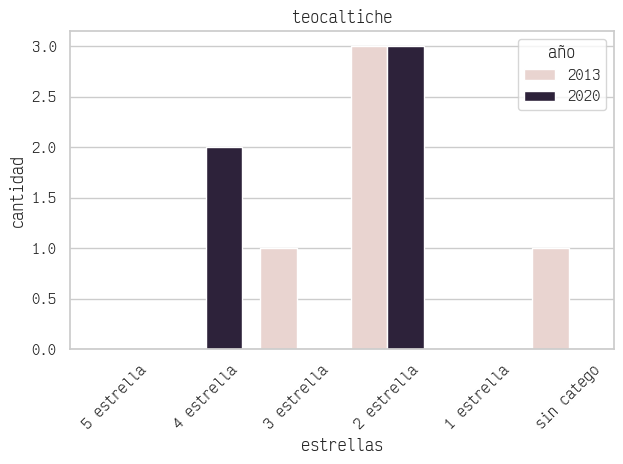

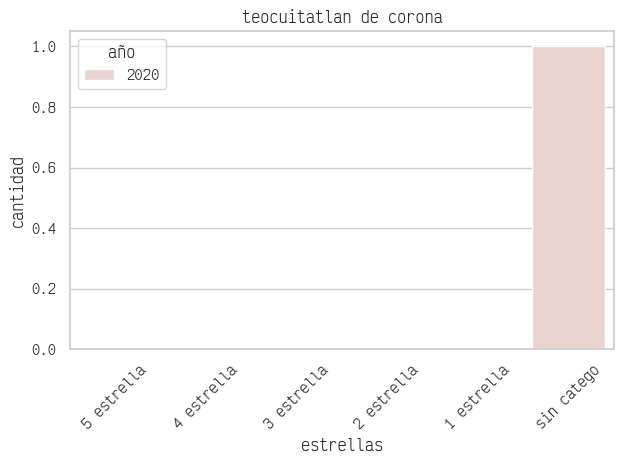

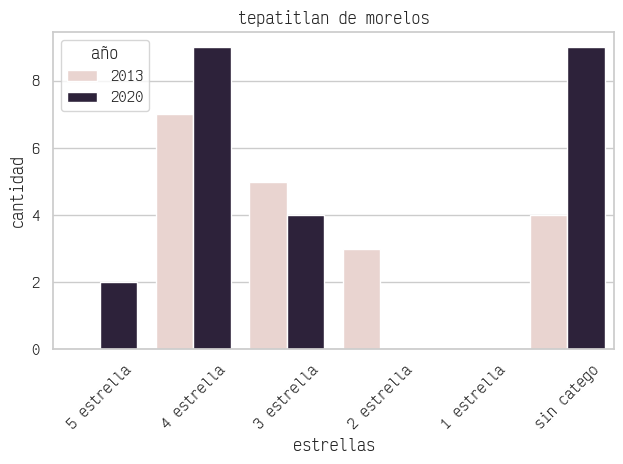

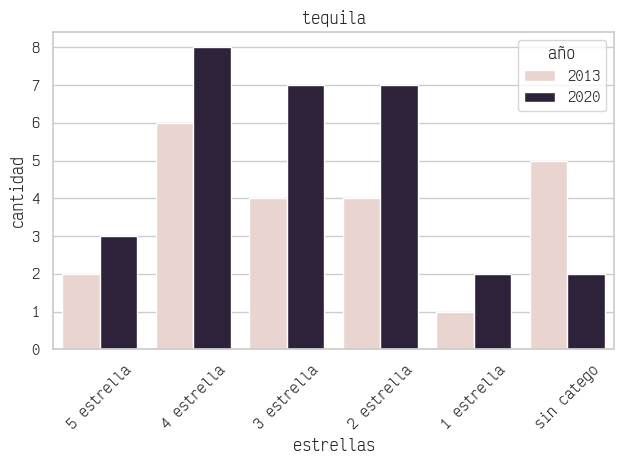

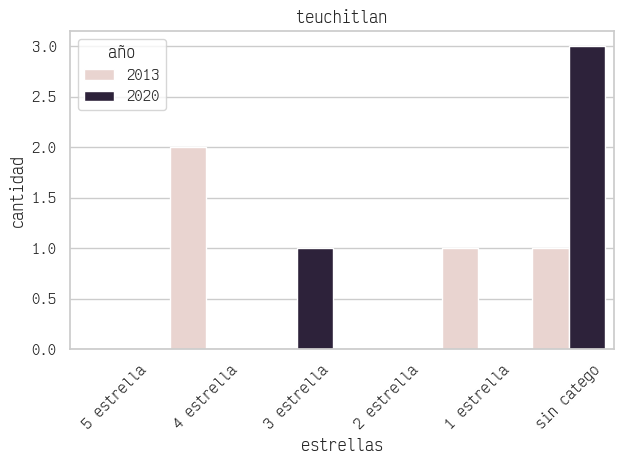

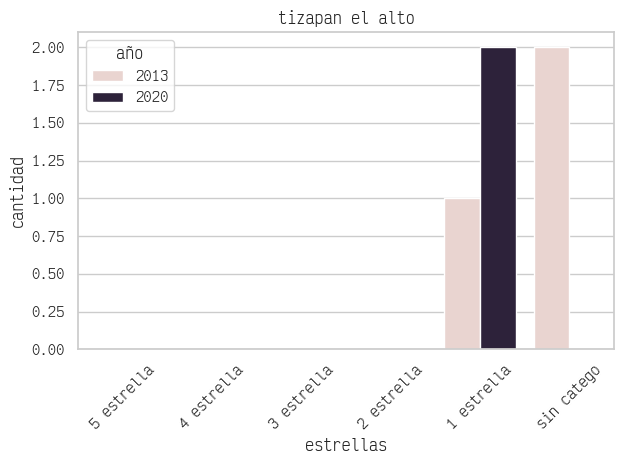

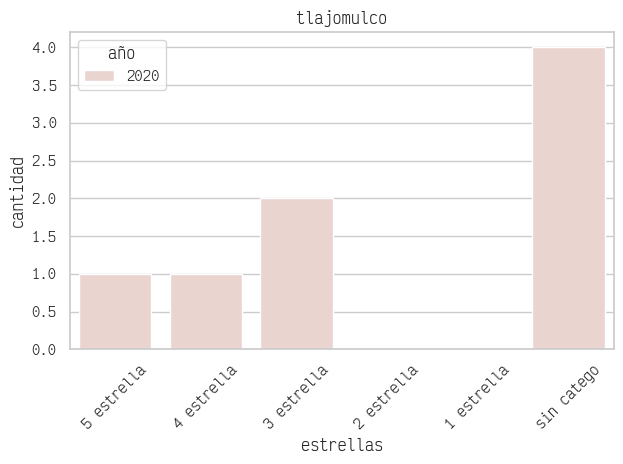

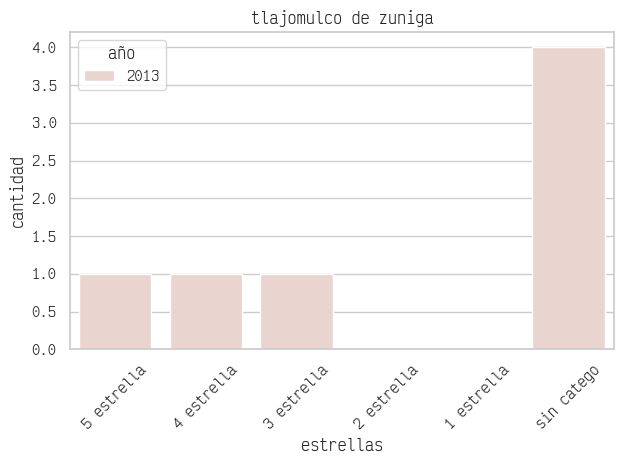

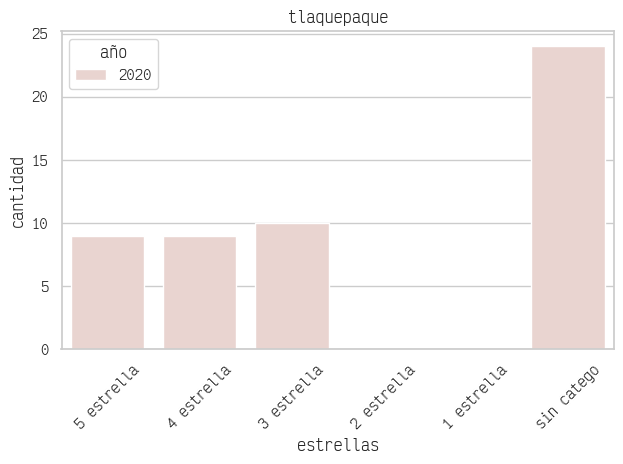

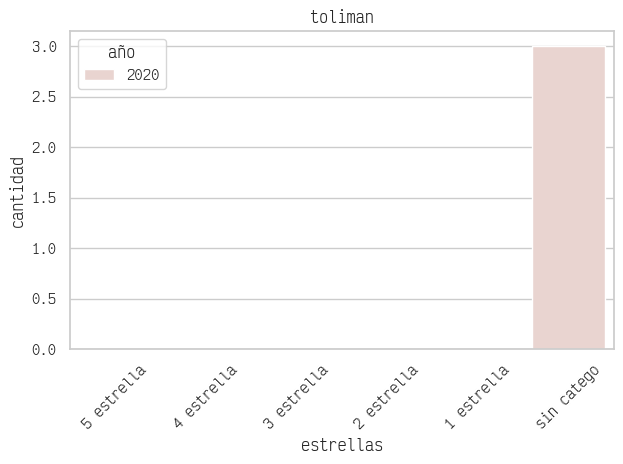

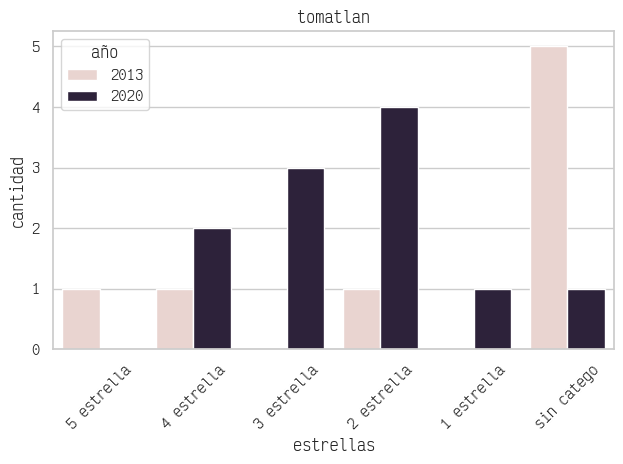

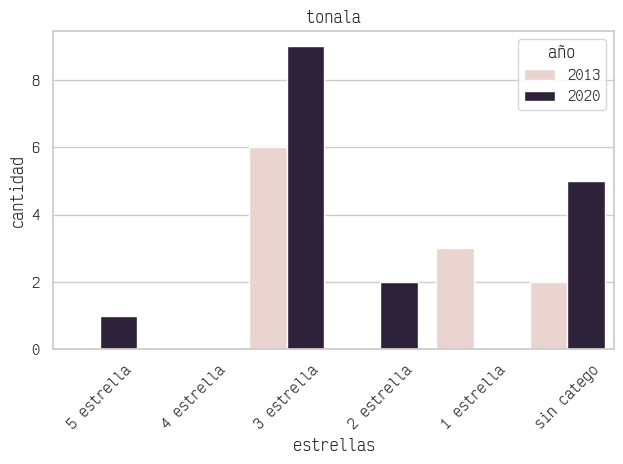

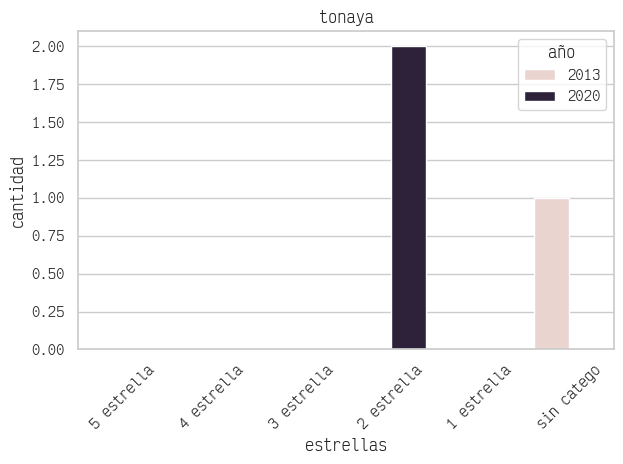

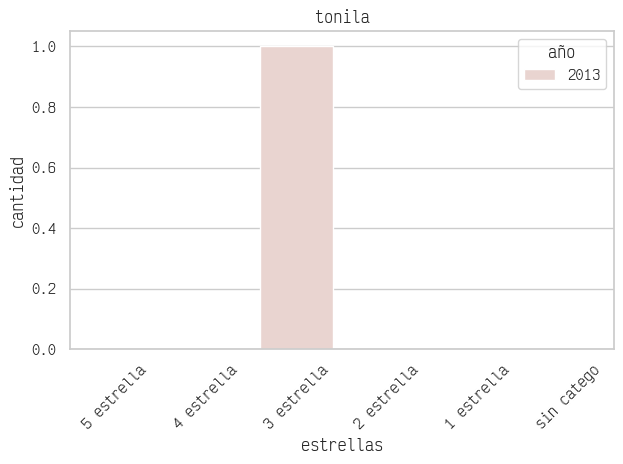

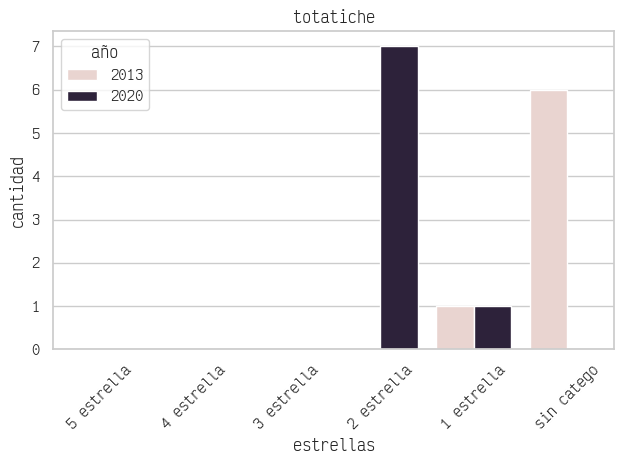

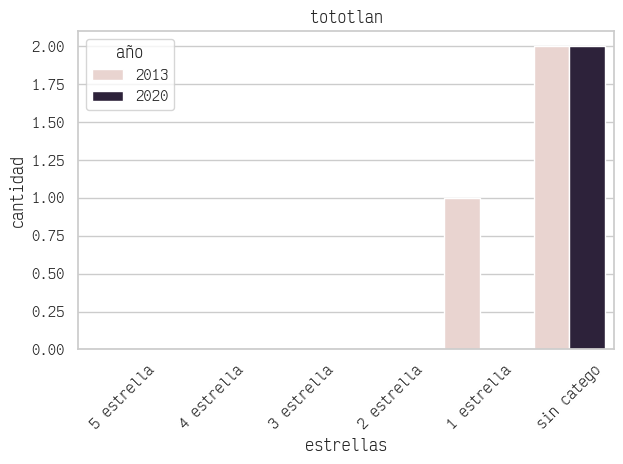

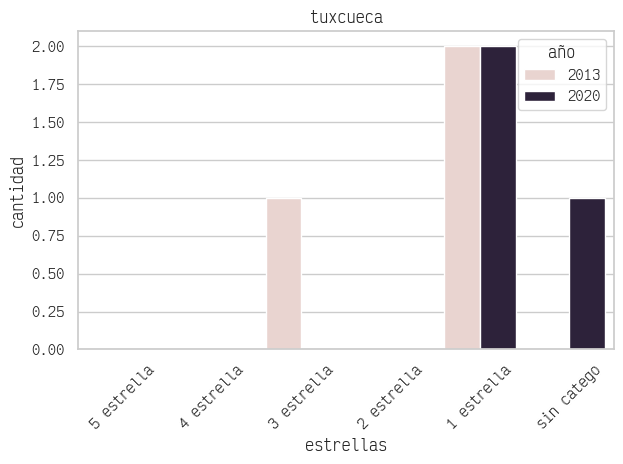

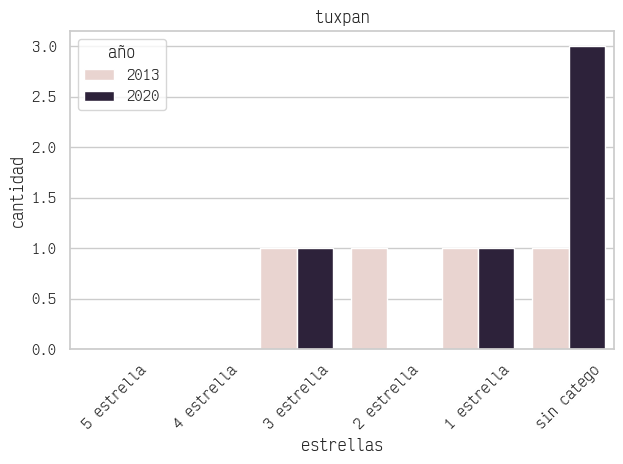

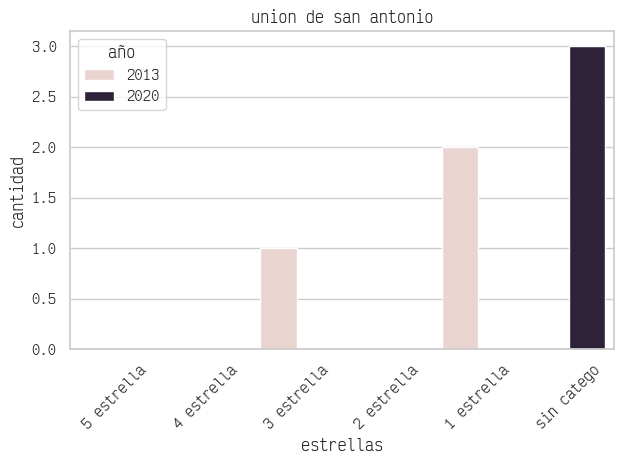

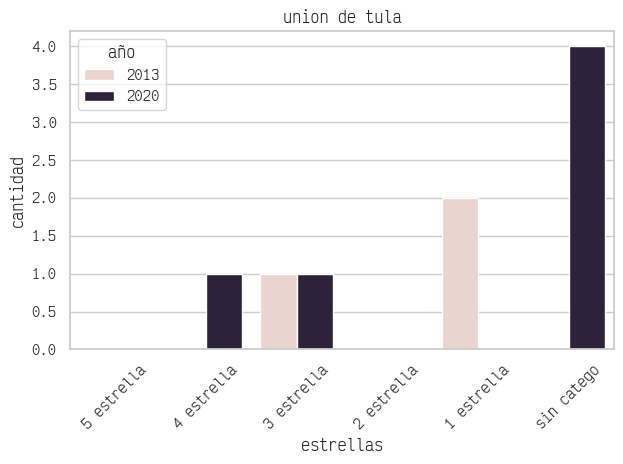

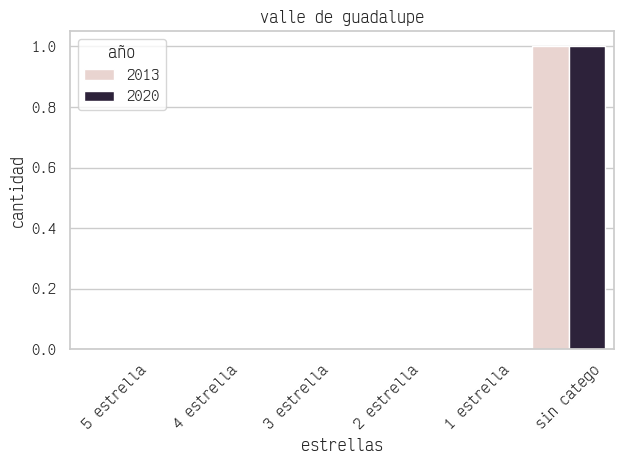

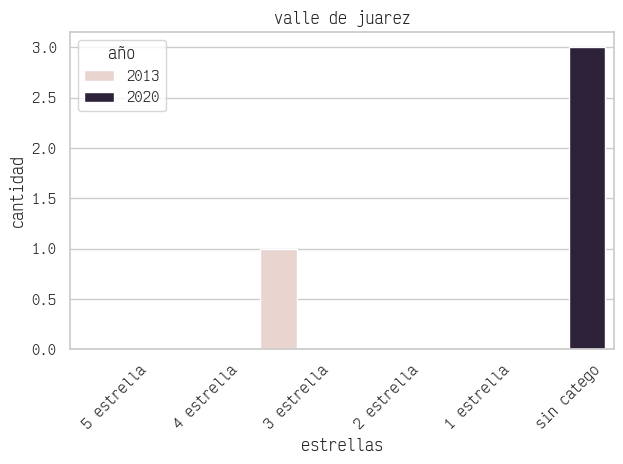

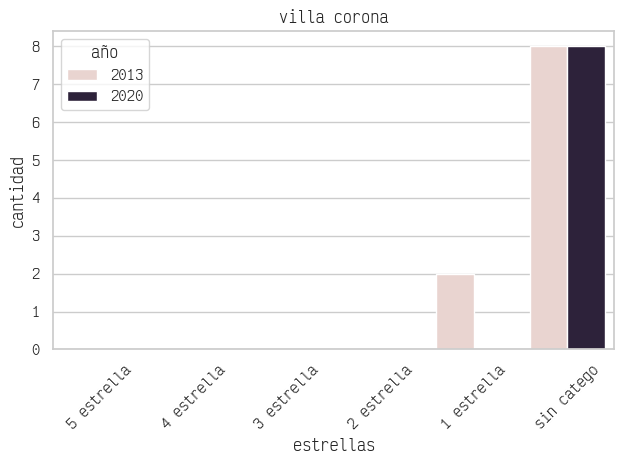

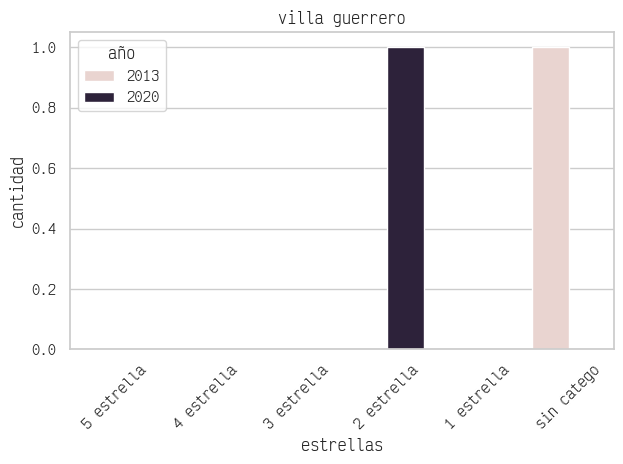

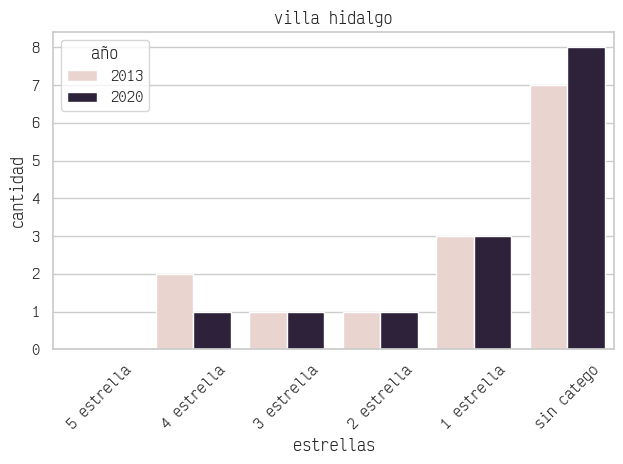

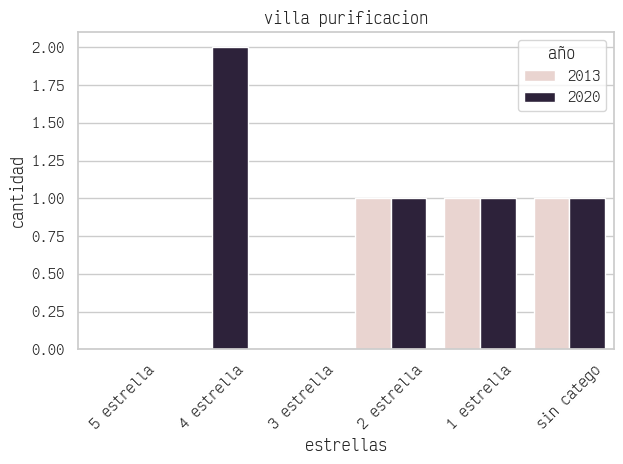

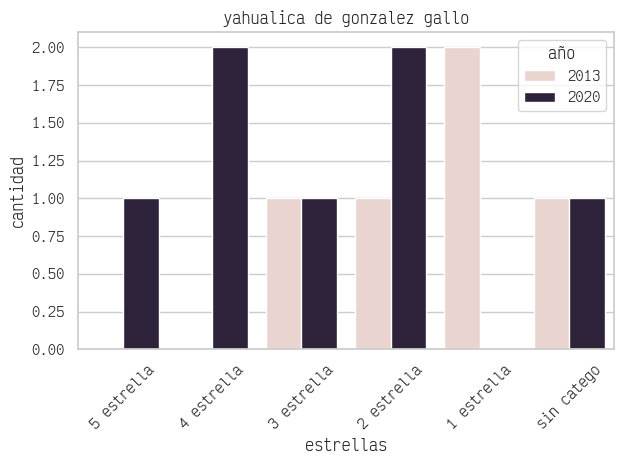

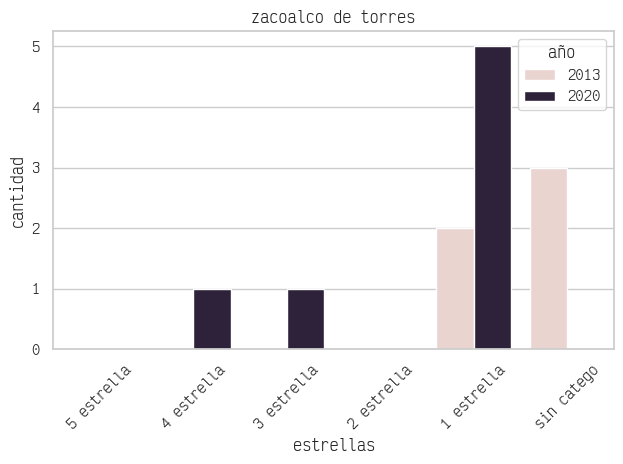

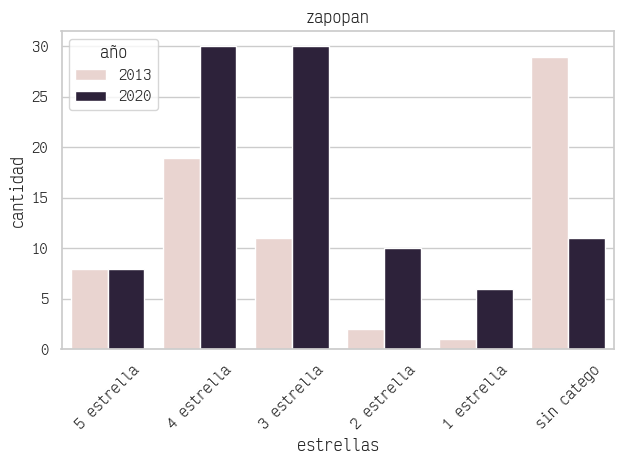

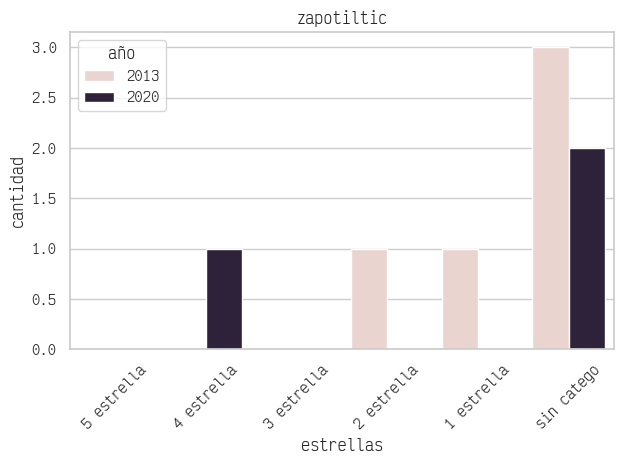

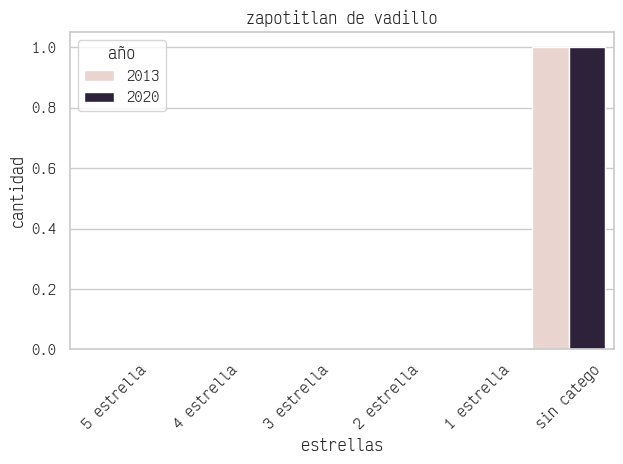

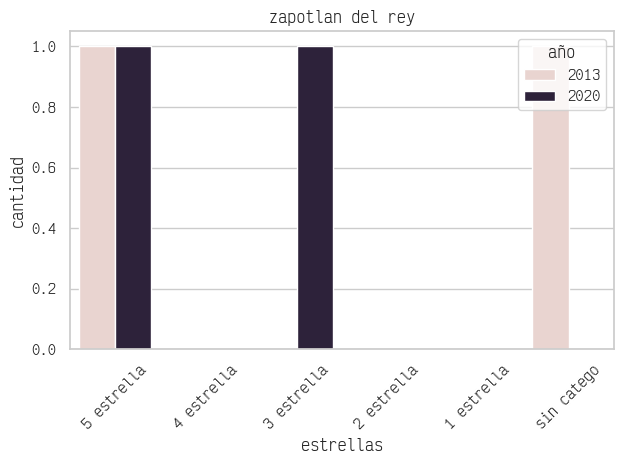

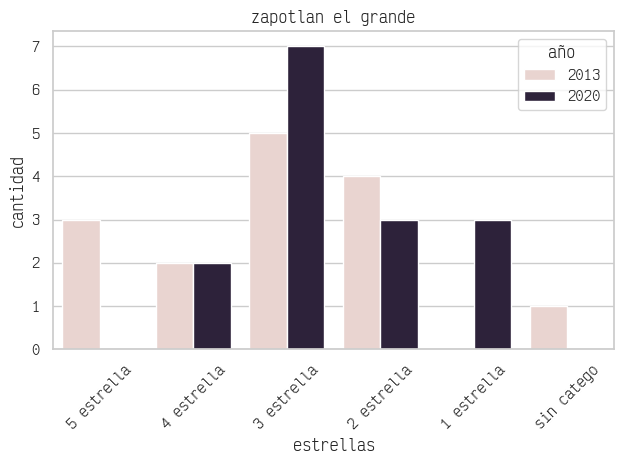

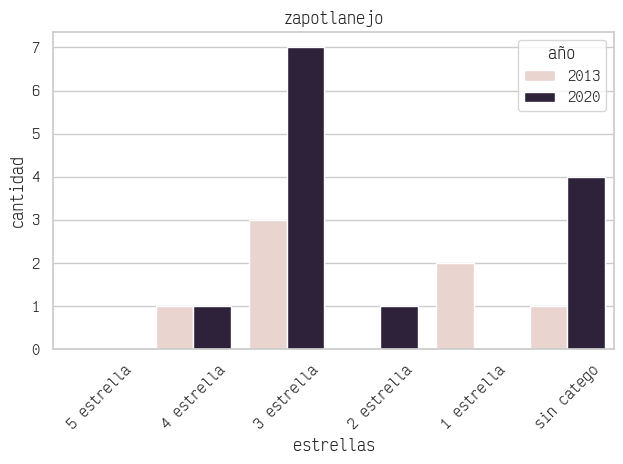

In [8]:
order = ['5 estrella','4 estrella','3 estrella','2 estrella','1 estrella','sin catego']

for mun in df_hoteles_rel:
    # print(mun[1])
    df = mun[1].melt(
    id_vars=['municipio', 'año','region'], 
    value_vars=['5 estrella', '4 estrella', '3 estrella', '2 estrella', '1 estrella', 'sin catego'],
    var_name='estrellas', 
    value_name="cantidad"
    )

    
    
    fig,ax = plt.subplots(1,1)

    sns.barplot(
        data=df,
        x="estrellas",
        y="cantidad",
        hue="año",
        order=order,
        ax=ax
    )
    
    ax.set_title(mun[0])
    plt.xticks(rotation=45)
    plt.tight_layout()

# Analisis por regiones

## Numero de cuartos

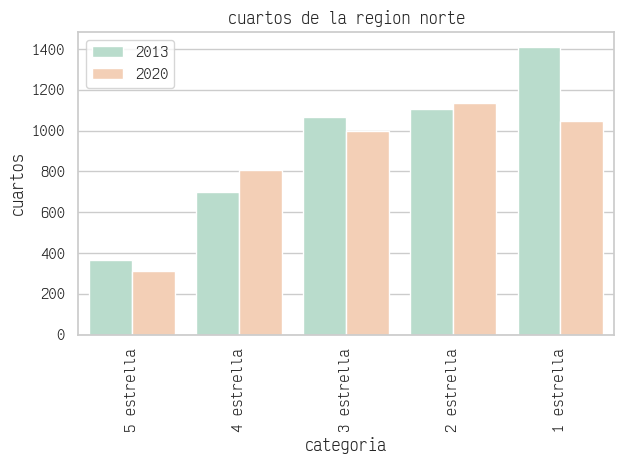

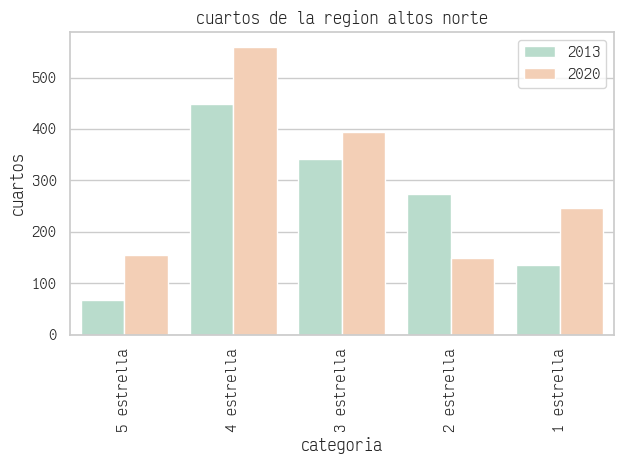

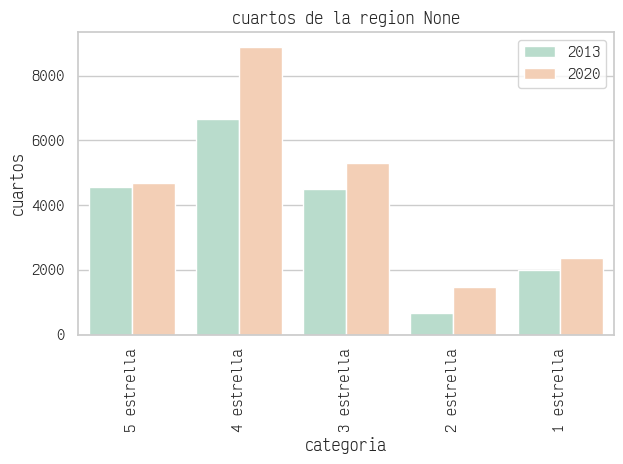

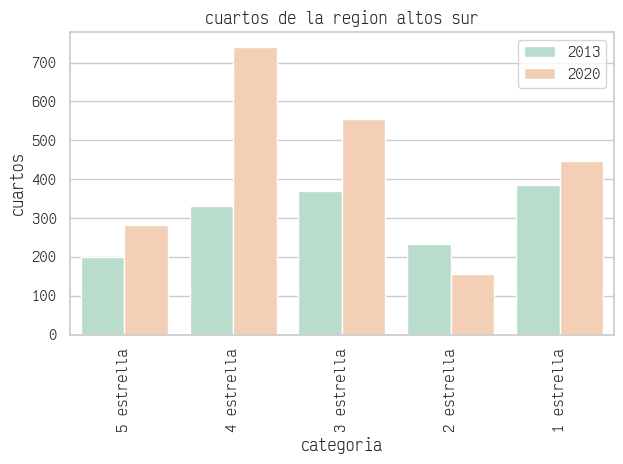

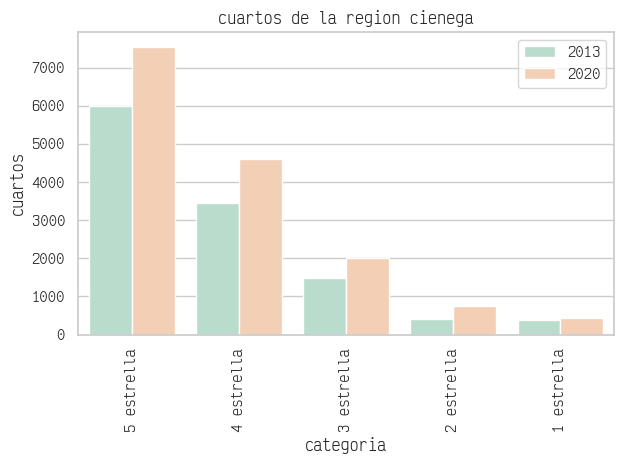

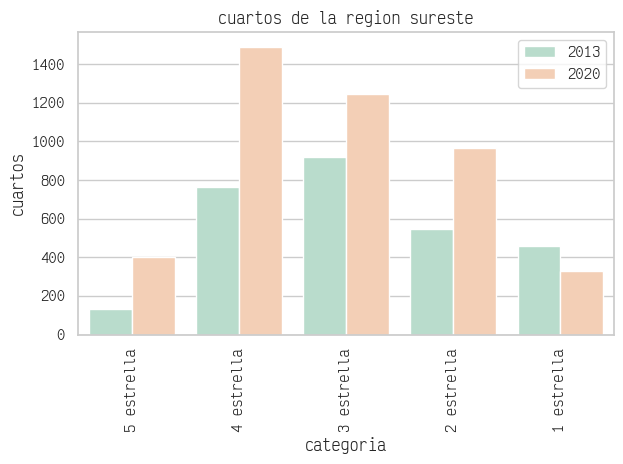

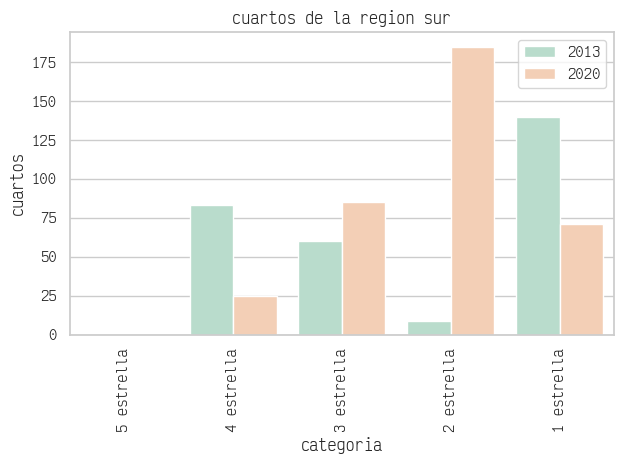

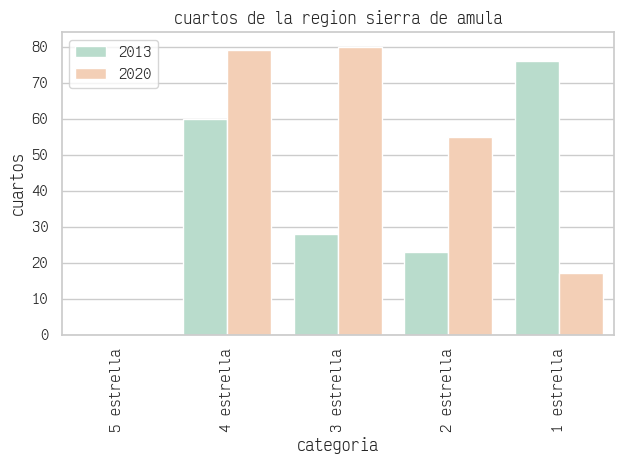

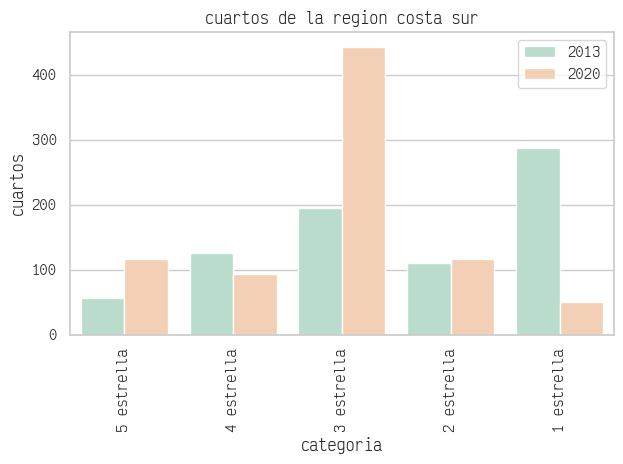

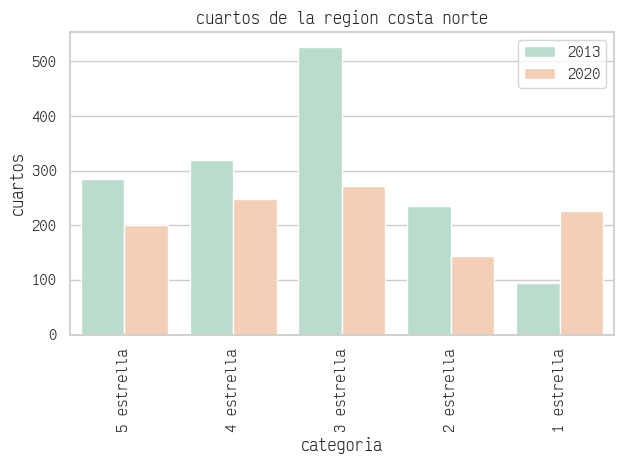

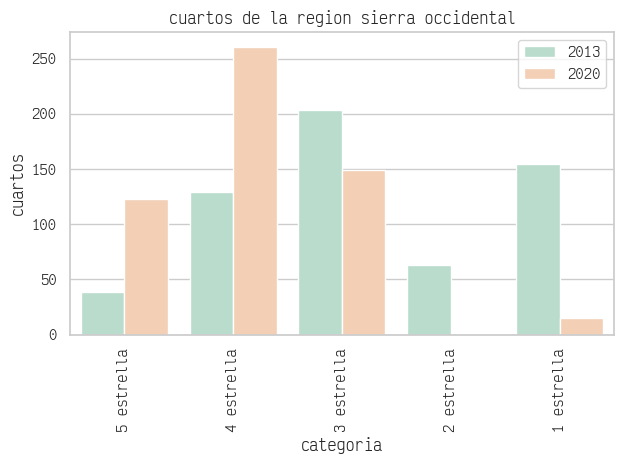

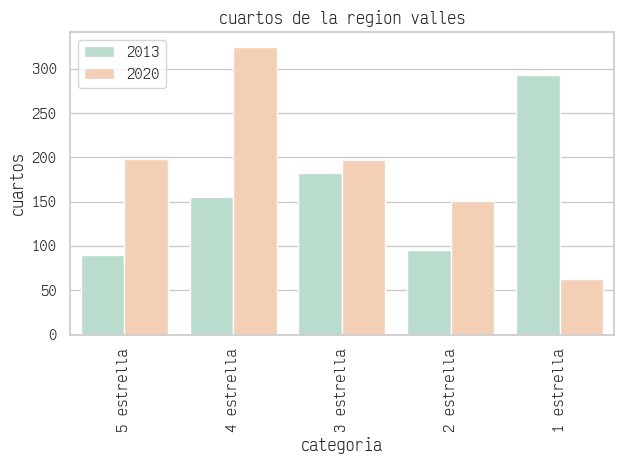

In [9]:
categorias = ['5 estrella', '4 estrella', '3 estrella', '2 estrella', '1 estrella']

for (df_region, name) in zip(df_cuartos.groupby('region'), df_cuartos['region'].unique()):
    df_region = df_region[1]
    df_region = df_region[(df_region['año'] == 2013) | (df_region['año'] == 2020)]
    suma_13 = df_region[df_region['año'] == 2013][categorias].sum()
    suma_20 = df_region[df_region['año'] == 2020][categorias].sum()
    
    df_plot = pd.DataFrame({
        'categoria': categorias * 2,
        'cuartos': suma_13.values.tolist() + suma_20.values.tolist(),
        'año': ['2013'] * len(categorias) + ['2020'] * len(categorias)
    })

    
    fig, ax = plt.subplots()
    sns.barplot(data=df_plot, x='categoria', y='cuartos', hue='año', ax=ax)
    ax.set_title(f'cuartos de la region {name}')
    plt.xticks(rotation=90)
    ax.legend()
    plt.tight_layout()


C:\Users\fofoy\AppData\Local\Temp\ipykernel_20356\2653781379.py:31: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(np.arange(2012,2021),rotation=90)


Text(0.5, 1.0, 'cantidad total de cuartos por region')

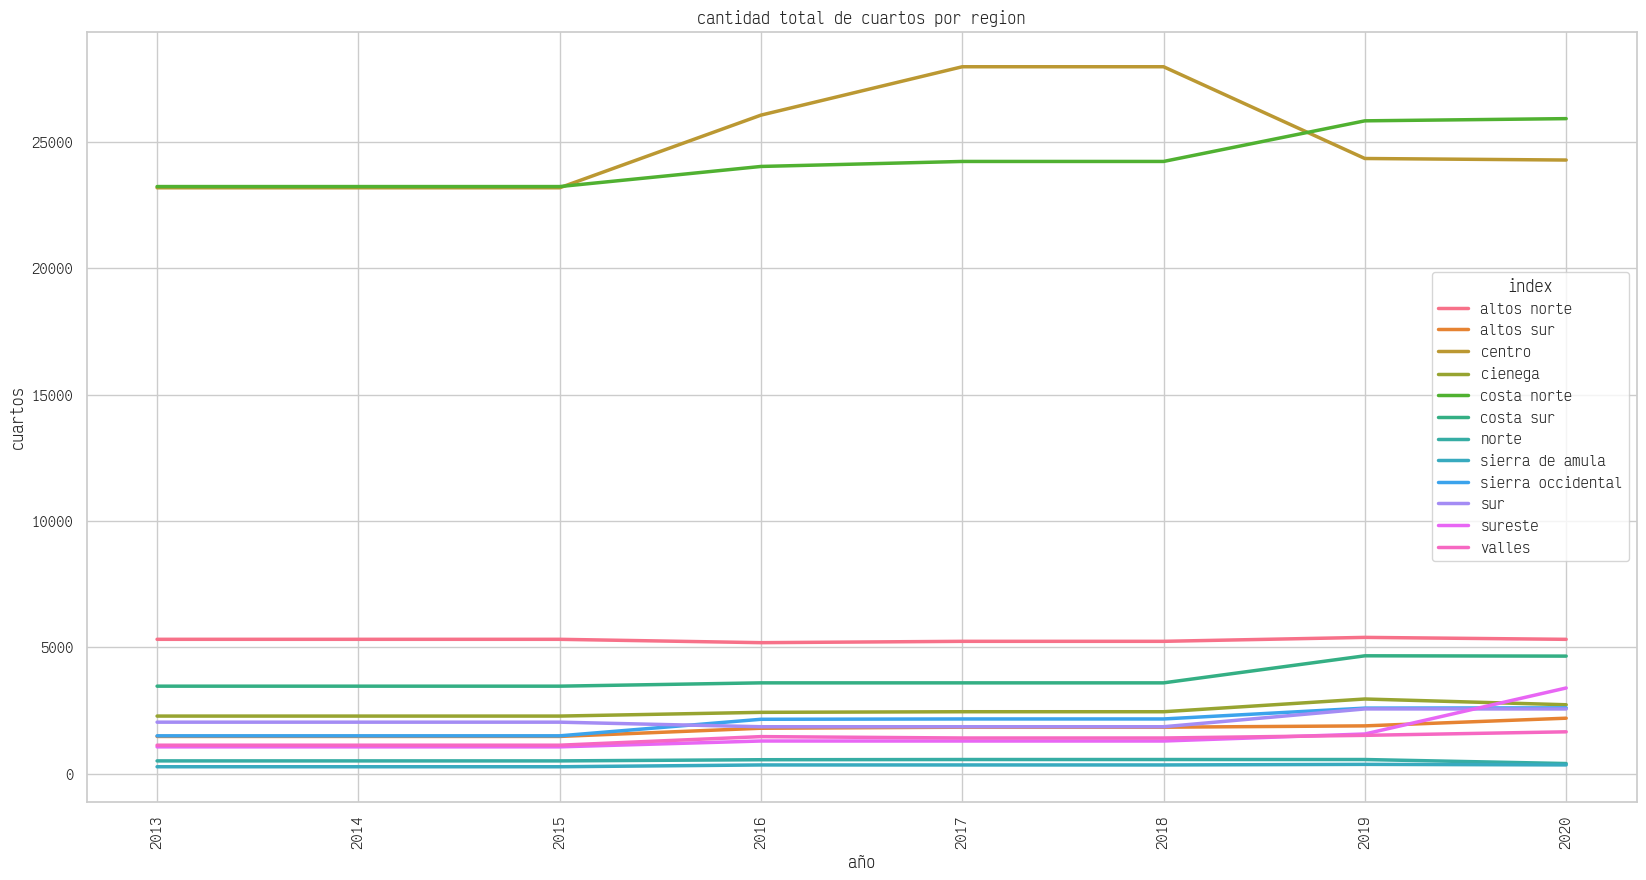

In [10]:
# Numero de cuartos por categoria agrupados por region

rooms_category_by_region = {}

for (df,name) in zip(df_cuartos.groupby('region'),df_cuartos['region'].unique()):
    name = df[0]
    df = df[1]
    # display(df)
    for (grouped_df,year) in zip(df.groupby('año'),df['año'].unique()):
        year = grouped_df[0]
        grouped_df = grouped_df[1]
        suma = grouped_df['total'].sum()
        if year not in rooms_category_by_region.keys():
            rooms_category_by_region[year] = {name:suma}
        
        rooms_category_by_region[year][name] = [suma] 

dfs = []
for k,v in rooms_category_by_region.items():
    df_temp = pd.DataFrame(v)
    df_temp = df_temp.T
    df_temp.columns = ['cuartos']
    df_temp['año'] = k
    dfs.append(df_temp)


final_df_cuartos = pd.concat(dfs)
final_df_cuartos.reset_index(inplace=True)
fig,ax = plt.subplots(figsize=(20,10))
sns.lineplot(final_df_cuartos,x='año',y='cuartos',hue='index',ax=ax,linewidth=2.5) 
ax.set_xticklabels(np.arange(2012,2021),rotation=90)
ax.set_title(f'cantidad total de cuartos por region')

C:\Users\fofoy\AppData\Local\Temp\ipykernel_20356\3630051464.py:5: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(np.arange(2012,2021),rotation=90)


Text(0.5, 1.0, 'cantidad total de cuartos por region sin las mayores regiones')

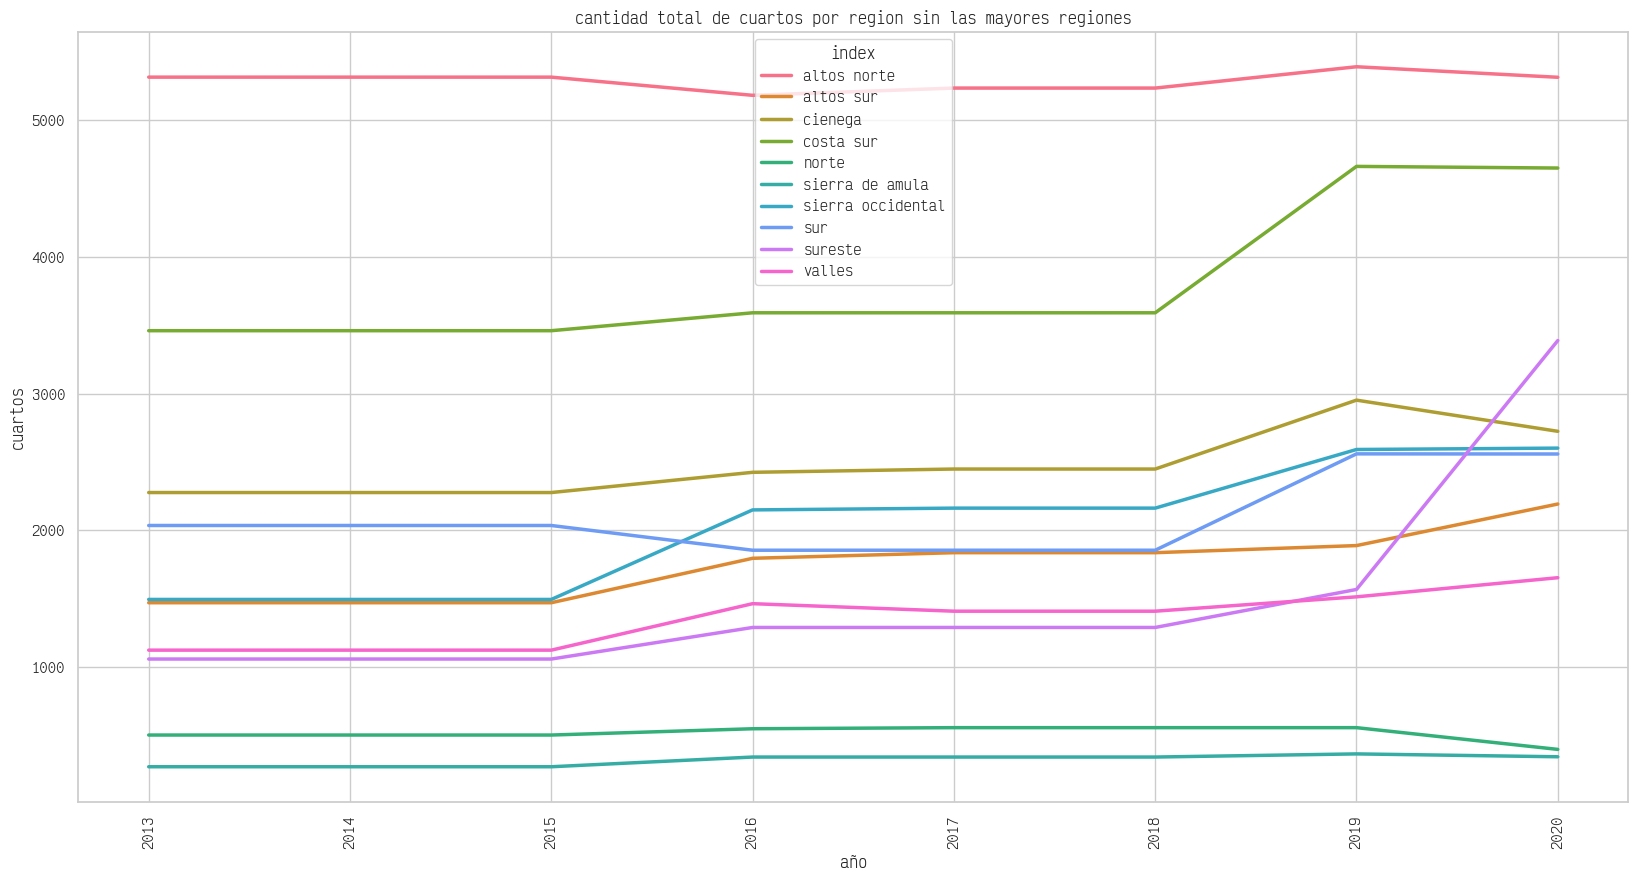

In [11]:

final_df_cuartos = final_df_cuartos[(final_df_cuartos['index'] != 'centro') & (final_df_cuartos['index'] != 'costa norte')]
final_df_cuartos.reset_index(inplace=True)
fig,ax = plt.subplots(figsize=(20,10))
sns.lineplot(final_df_cuartos,x='año',y='cuartos',hue='index',ax=ax,linewidth=2.5) 
ax.set_xticklabels(np.arange(2012,2021),rotation=90)
ax.set_title(f'cantidad total de cuartos por region sin las mayores regiones')


## numero de hoteles

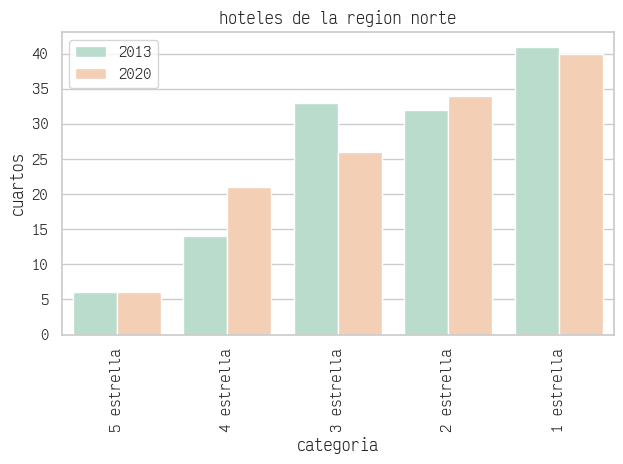

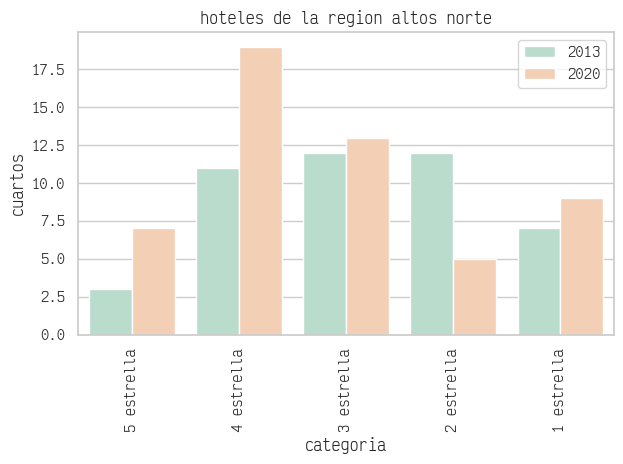

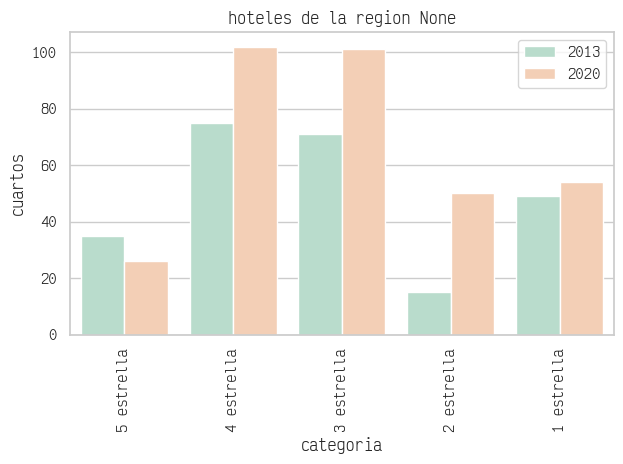

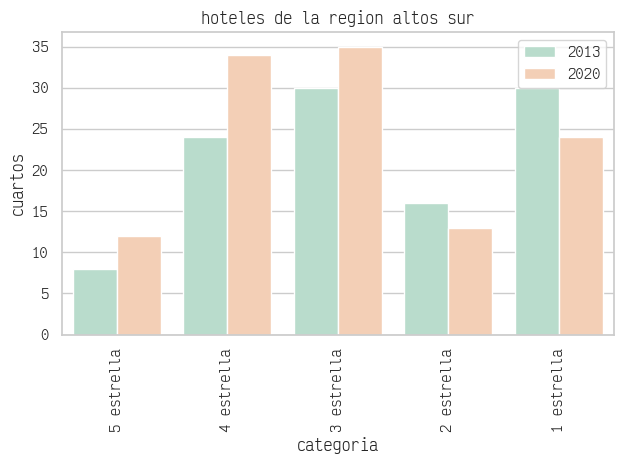

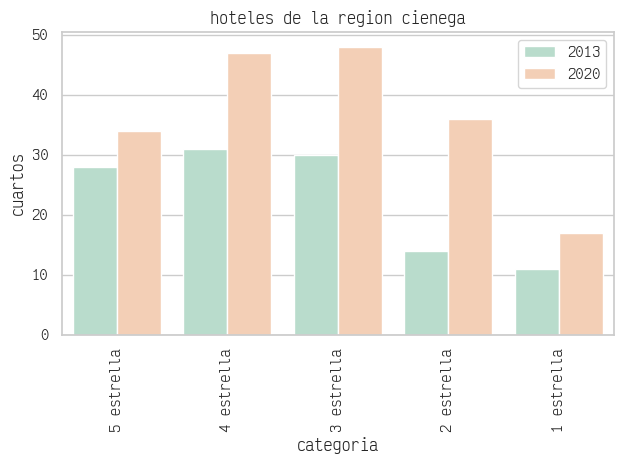

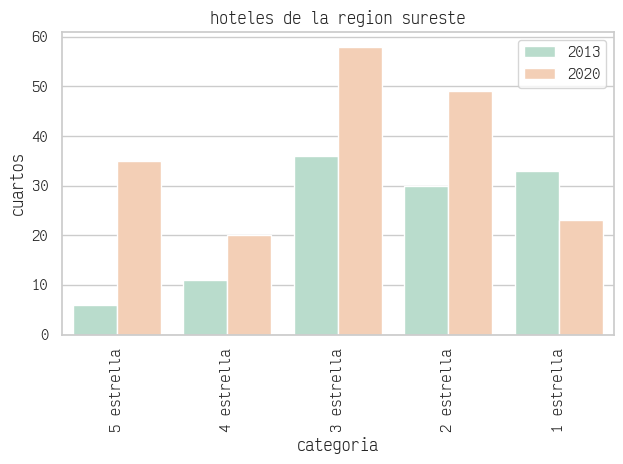

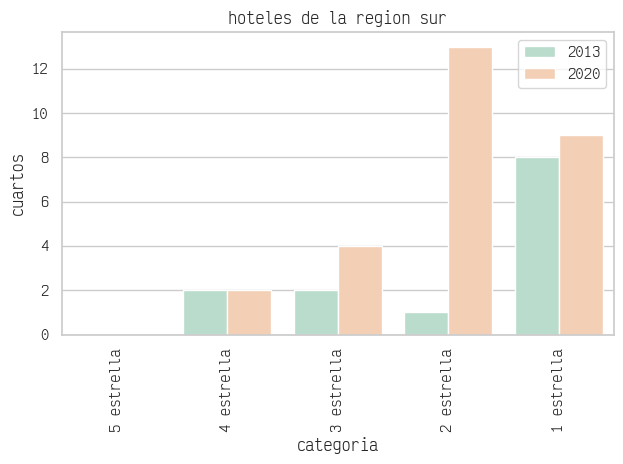

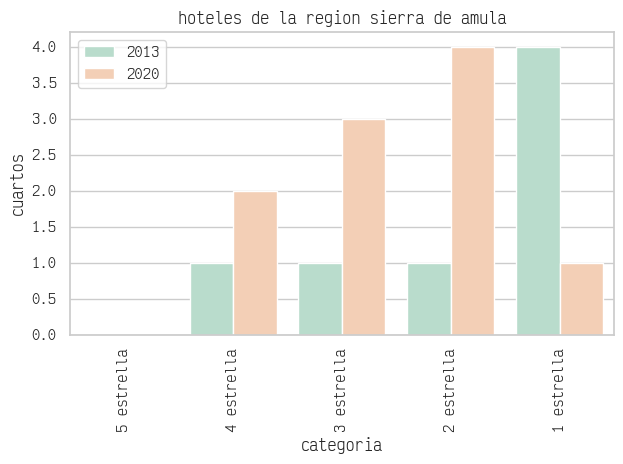

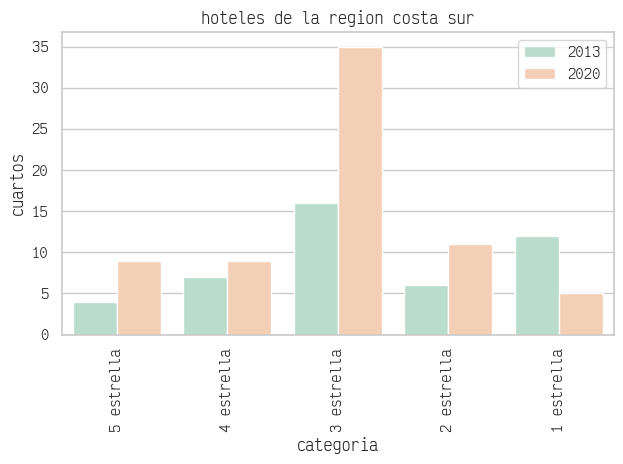

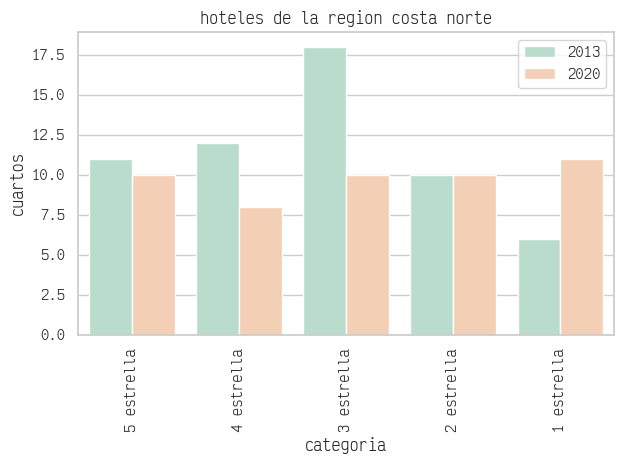

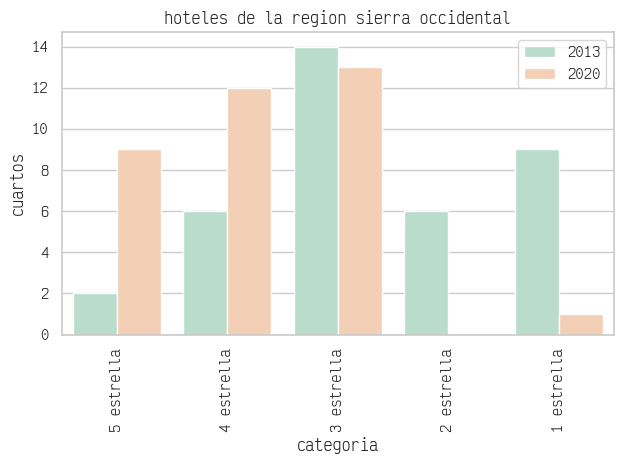

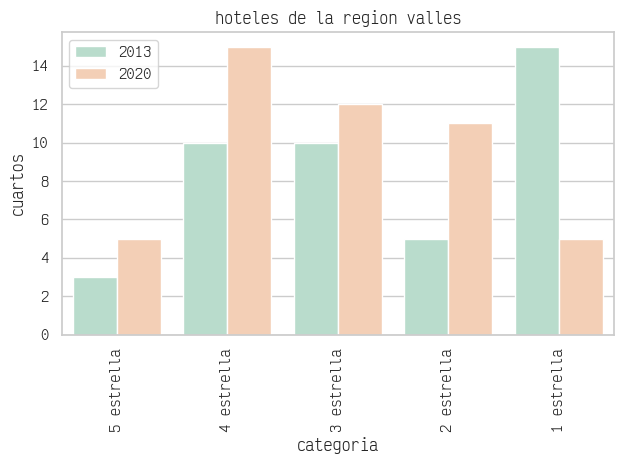

In [12]:
categorias = ['5 estrella', '4 estrella', '3 estrella', '2 estrella', '1 estrella']

for (df_region, name) in zip(df_hoteles.groupby('region'), df_hoteles['region'].unique()):
    df_region = df_region[1]
    df_region = df_region[(df_region['año'] == 2013) | (df_region['año'] == 2020)]
    suma_13 = df_region[df_region['año'] == 2013][categorias].sum()
    suma_20 = df_region[df_region['año'] == 2020][categorias].sum()
    
    df_plot = pd.DataFrame({
        'categoria': categorias * 2,
        'cuartos': suma_13.values.tolist() + suma_20.values.tolist(),
        'año': ['2013'] * len(categorias) + ['2020'] * len(categorias)
    })

    
    fig, ax = plt.subplots()
    sns.barplot(data=df_plot, x='categoria', y='cuartos', hue='año', ax=ax)
    ax.set_title(f'hoteles de la region {name}')
    plt.xticks(rotation=90)
    ax.legend()
    plt.tight_layout()

C:\Users\fofoy\AppData\Local\Temp\ipykernel_20356\3530504842.py:31: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(df_temp['año'].unique(),rotation=90)


Text(0.5, 1.0, 'cantidad total de hoteles por region')

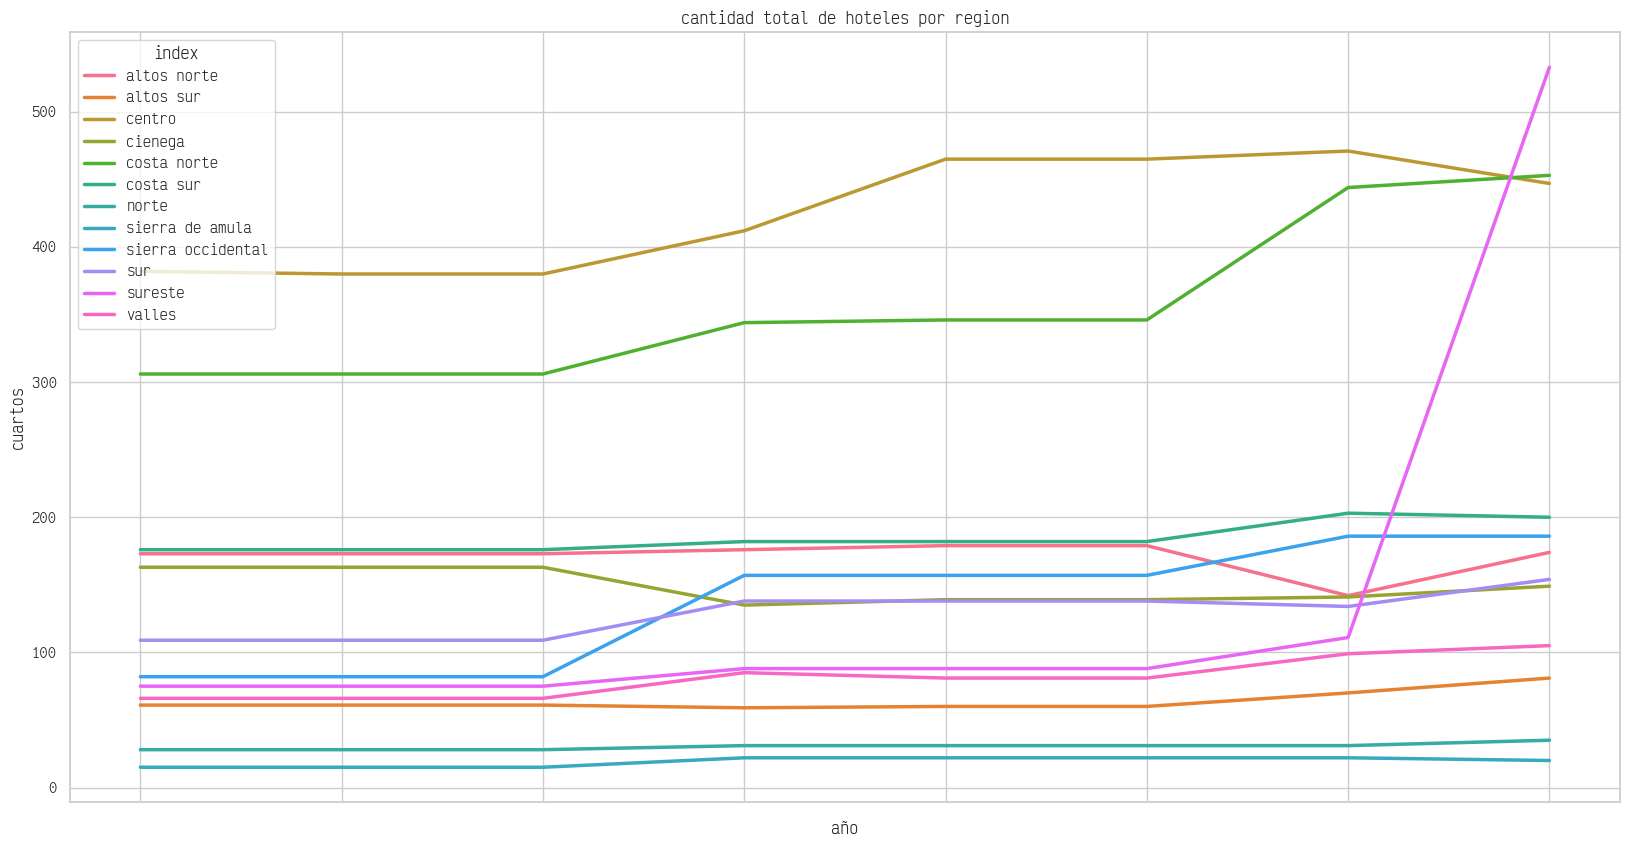

In [13]:
# Numero de cuartos por categoria agrupados por region

rooms_category_by_region = {}

for (df,name) in zip(df_hoteles.groupby('region'),df_hoteles['region'].unique()):
    name = df[0]
    df = df[1]
    # display(df)
    for (grouped_df,year) in zip(df.groupby('año'),df['año'].unique()):
        year = grouped_df[0]
        grouped_df = grouped_df[1]
        suma = grouped_df['total'].sum()
        if year not in rooms_category_by_region.keys():
            rooms_category_by_region[year] = {name:suma}
        
        rooms_category_by_region[year][name] = [suma] 

dfs = []
for k,v in rooms_category_by_region.items():
    df_temp = pd.DataFrame(v)
    df_temp = df_temp.T
    df_temp.columns = ['cuartos']
    df_temp['año'] = k
    dfs.append(df_temp)


final_df_cuartos = pd.concat(dfs)
final_df_cuartos.reset_index(inplace=True)
fig,ax = plt.subplots(figsize=(20,10))
sns.lineplot(final_df_cuartos,x='año',y='cuartos',hue='index',ax=ax,linewidth=2.5) 
ax.set_xticklabels(df_temp['año'].unique(),rotation=90)
ax.set_title(f'cantidad total de hoteles por region')

<Axes: >

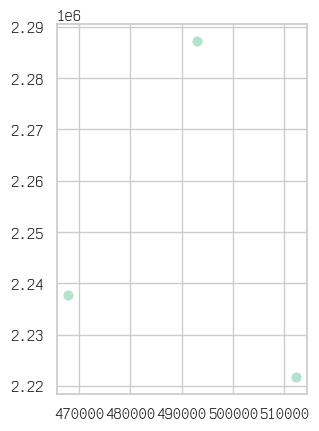

In [ ]:

df_cuartos[(df_cuartos['año'] >= 2019) & (df_cuartos['region'] == 'costa norte')]

In [ ]:

df_cuartos[(df_cuartos['año'] < 2019) & (df_cuartos['region'] == 'costa norte')]